In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from catboost import CatBoostRegressor

import main

In [21]:
## Start of Notebook

print('Starting Assignment 1')
RawData = main.ReadInData("../data/tcd ml 2019-20 income prediction training (with labels).csv")
print(RawData.shape)
print(RawData.describe())


Starting Assignment 1
(111993, 12)
            Instance  Year of Record            Age  Size of City  \
count  111993.000000   111552.000000  111499.000000  1.119930e+05   
mean    55997.000000     1999.421274      37.345304  8.388538e+05   
std     32329.738686       11.576382      16.036694  2.196879e+06   
min         1.000000     1980.000000      14.000000  7.700000e+01   
25%     27999.000000     1989.000000      24.000000  7.273400e+04   
50%     55997.000000     1999.000000      35.000000  5.060920e+05   
75%     83995.000000     2009.000000      48.000000  1.184501e+06   
max    111993.000000     2019.000000     115.000000  4.999251e+07   

       Wears Glasses  Body Height [cm]  Income in EUR  
count  111993.000000     111993.000000   1.119930e+05  
mean        0.500531        175.220192   1.092138e+05  
std         0.500002         19.913889   1.498024e+05  
min         0.000000         94.000000  -5.696906e+03  
25%         0.000000        160.000000   3.077169e+04  
50%    

In [22]:
## Dropping Features that are missing a large amount of data
## Dropping instances with missing data

RawData = main.HandleMissingData(RawData)

null_counts = RawData.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

37
1999.4212743832472
Number of null values in each column:
Year of Record       0
Gender               0
Age                  0
Country              0
Size of City         0
Profession           0
University Degree    0
Wears Glasses        0
Body Height [cm]     0
Income in EUR        0
dtype: int64


In [23]:
RawData['University Degree'] = RawData['University Degree'].replace(['0'], 'No')


In [24]:
## Scale data
columns = RawData.columns.values
tmp= RawData.drop(columns=['Country','Profession','Gender','University Degree'], axis=1)
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(tmp)
rescaledData = scaler.transform(tmp)

## Holded scaled for later.
df = pd.DataFrame(rescaledData)
print(df)

               0         1         2    3         4         5
0       0.435897  0.267327  0.024801  0.0  0.578947  0.012612
1       0.410256  0.267327  0.032073  0.0  0.538012  0.018276
2       0.974359  0.138614  0.025963  1.0  0.444444  0.030936
3       0.666667  0.188119  0.015039  1.0  0.450292  0.009770
4       0.769231  0.316832  0.001907  0.0  0.549708  0.008263
...          ...       ...       ...  ...       ...       ...
111988  0.000000  0.148515  0.004105  0.0  0.239766  0.004325
111989  0.666667  0.217822  0.020258  1.0  0.309942  0.023531
111990  0.333333  0.217822  0.001216  1.0  0.345029  0.055878
111991  1.000000  0.396040  0.016974  0.0  0.561404  0.019986
111992  0.948718  0.128713  0.006511  0.0  0.467836  0.028650

[111993 rows x 6 columns]


In [5]:
## Removing Outliers. Outliers being top and bottoms 2.5%

from scipy import stats
import numpy as np

z = np.abs(stats.zscore(RawData['Income in EUR']))
print(z)
print(z.shape)
count = []
index = []
for i in range(len(z)):
    if z[i] > 3:
        count.append(z[i])
        index.append(i)
        
RawData = RawData.drop(index)
print("Removing " + str(len(index)))
print("New Number of Instances: " + str(RawData.shape))

[0.32163766 0.12157727 0.32555287 ... 1.20651194 0.06119611 0.24480686]
(111993,)
Removing 2399
New Number of Instances: (109594, 10)


In [25]:
## Seeing the data and the unique values

for s in RawData.columns.values:
    print("Features in " + s)
    print(RawData[s].unique())
    print(len(RawData[s].unique()))


Features in Year of Record
[1997. 1996. 2018. 2006. 2010. 1991. 1982. 2008. 2015. 2019. 1981. 1989.
 2003. 1987. 1995. 1992. 1980. 1983. 2011. 2014. 1985. 2005. 1998. 2001.
 2017. 2007. 1988. 1994. 2012. 2009. 2013. 2004. 1999. 2002. 1993. 2000.
 1990. 2016. 1986. 1984.]
40
Features in Gender
['0' 'other' 'female' 'male' 'unknown']
5
Features in Age
[ 41.  28.  33.  46.  60.  71.  36.  43.  16.  51.  15.  22.  32.  40.
  31.  27.  25.  35.  63.  38.  34.  20.  23.  14.  37.  62.  52.  47.
  24.  26.  50.  49.  18.  19.  39.  66.  21.  44.  29.  64.  65.  53.
  78.  42.  58.  17.  30.  79.  48.  56.  83.  54.  74.  87.  90.  67.
  45.  77.  73.  55.  92.  80.  72.  57.  70.  59.  61.  82.  69.  98.
  94.  68.  81.  97.  76.  75.  88.  91.  96.  84.  89. 107.  85.  86.
 100. 110.  95.  99.  93. 104. 102. 101. 105. 111. 108. 103. 109. 106.
 115.]
99
Features in Country
['Belarus' 'Singapore' 'Norway' 'Cuba' 'United Arab Emirates' 'Liberia'
 'State of Palestine' 'Israel' 'South Sudan' 'Kyr

In [26]:
## Section to conver to binary matrix
## Changing Country, Profession

RawData_Country = pd.get_dummies(RawData.Country)
print(type(RawData_Country))
RawData_Profession = pd.get_dummies(RawData.Profession)
print(type(RawData_Profession))
RawData_Gender = pd.get_dummies(RawData['Gender'])
print(RawData_Gender.describe())
RawData_Uni = pd.get_dummies(RawData['University Degree'])
print(RawData_Uni.describe())

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
                   0         female           male          other  \
count  111993.000000  111993.000000  111993.000000  111993.000000   
mean        0.006465       0.242604       0.381792       0.241622   
std         0.080143       0.428660       0.485828       0.428068   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       1.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

             unknown  
count  111993.000000  
mean        0.127517  
std         0.333553  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  
            Bachelor         Master             No            PhD
count  111993.000000  111993.

In [50]:
RawData.describe()

,Year of Record,Age,Size of City,Wears Glasses,Body Height [cm],Income in EUR
count,111993.000000,111993.000000,1.119930e+05,111993.000000,111993.000000,1.119930e+05
mean,1999.419616,37.343780,8.388538e+05,0.500531,175.220192,1.092138e+05
std,11.553597,16.001302,2.196879e+06,0.500002,19.913889,1.498024e+05
min,1980.000000,14.000000,7.700000e+01,0.000000,94.000000,-5.696906e+03
25%,1989.000000,24.000000,7.273400e+04,0.000000,160.000000,3.077169e+04
50%,1999.000000,35.000000,5.060920e+05,1.000000,174.000000,5.733917e+04
75%,2009.000000,48.000000,1.184501e+06,1.000000,190.000000,1.260936e+05
max,2019.000000,115.000000,4.999251e+07,1.000000,265.000000,5.285252e+06


In [27]:
## Creating clean training data
print(RawData.columns)

RawData = pd.concat([RawData, RawData_Country], axis=1)
RawData= RawData.drop('Country', axis=1)
RawData = pd.concat([RawData, RawData_Profession], axis=1)
RawData= RawData.drop('Profession', axis=1)
RawData = pd.concat([RawData, RawData_Gender], axis=1)
RawData= RawData.drop('Gender', axis=1)
RawData = pd.concat([RawData, RawData_Uni], axis=1)
RawData= RawData.drop('University Degree', axis=1)

Index(['Year of Record', 'Gender', 'Age', 'Country', 'Size of City',
       'Profession', 'University Degree', 'Wears Glasses', 'Body Height [cm]',
       'Income in EUR'],
      dtype='object')


In [28]:
RawData.describe()

,Year of Record,Age,Size of City,Wears Glasses,Body Height [cm],Income in EUR,Afghanistan,Albania,Algeria,Angola,...,youth initiatives lead advisor,0,female,male,other,unknown,Bachelor,Master,No,PhD
count,111993.000000,111993.000000,1.119930e+05,111993.000000,111993.000000,1.119930e+05,111993.000000,111993.000000,111993.000000,111993.000000,...,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000
mean,1999.419616,37.343780,8.388538e+05,0.500531,175.220192,1.092138e+05,0.000196,0.003554,0.000063,0.000473,...,0.000286,0.006465,0.242604,0.381792,0.241622,0.127517,0.385488,0.240560,0.313046,0.060906
std,11.553597,16.001302,2.196879e+06,0.500002,19.913889,1.498024e+05,0.014014,0.059508,0.007906,0.021749,...,0.016901,0.080143,0.428660,0.485828,0.428068,0.333553,0.486713,0.427425,0.463735,0.239158
min,1980.000000,14.000000,7.700000e+01,0.000000,94.000000,-5.696906e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1989.000000,24.000000,7.273400e+04,0.000000,160.000000,3.077169e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1999.000000,35.000000,5.060920e+05,1.000000,174.000000,5.733917e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2009.000000,48.000000,1.184501e+06,1.000000,190.000000,1.260936e+05,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,2019.000000,115.000000,4.999251e+07,1.000000,265.000000,5.285252e+06,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
RawData['Year of Record'] = df[0]
RawData['Age'] = df[1]
RawData['Size of City'] = df[2]
RawData['Body Height [cm]'] = df[4]

RawData.describe()

,Year of Record,Age,Size of City,Wears Glasses,Body Height [cm],Income in EUR,Afghanistan,Albania,Algeria,Angola,...,youth initiatives lead advisor,0,female,male,other,unknown,Bachelor,Master,No,PhD
count,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,1.119930e+05,111993.000000,111993.000000,111993.000000,111993.000000,...,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000,111993.000000
mean,0.497939,0.231127,0.016778,0.500531,0.474972,1.092138e+05,0.000196,0.003554,0.000063,0.000473,...,0.000286,0.006465,0.242604,0.381792,0.241622,0.127517,0.385488,0.240560,0.313046,0.060906
std,0.296246,0.158429,0.043944,0.500002,0.116455,1.498024e+05,0.014014,0.059508,0.007906,0.021749,...,0.016901,0.080143,0.428660,0.485828,0.428068,0.333553,0.486713,0.427425,0.463735,0.239158
min,0.000000,0.000000,0.000000,0.000000,0.000000,-5.696906e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.230769,0.099010,0.001453,0.000000,0.385965,3.077169e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.487179,0.207921,0.010122,1.000000,0.467836,5.733917e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.743590,0.336634,0.023692,1.000000,0.561404,1.260936e+05,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.285252e+06,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
RawData.head(10)

,Year of Record,Age,Size of City,Wears Glasses,Body Height [cm],Income in EUR,Afghanistan,Albania,Algeria,Angola,...,youth initiatives lead advisor,0,female,male,other,unknown,Bachelor,Master,No,PhD
0,0.435897,0.267327,0.024801,0,0.578947,61031.94416,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0.410256,0.267327,0.032073,0,0.538012,91001.32764,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0.974359,0.138614,0.025963,1,0.444444,157982.17670,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.666667,0.188119,0.015039,1,0.450292,45993.75793,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.769231,0.316832,0.001907,0,0.549708,38022.16217,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
5,0.282051,0.455446,0.001120,0,0.508772,125809.99030,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
6,0.051282,0.564356,0.024106,0,0.467836,150319.42260,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
7,0.717949,0.217822,0.000627,0,0.561404,11849.02876,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
8,0.897436,0.287129,0.001705,0,0.555556,48058.20607,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
9,1.000000,0.019802,0.026510,1,0.368421,90940.68912,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [31]:
## Output Training Data to new file
RawData.to_csv("../data/processedData_catboost.csv", index=False)

In [32]:
## Read in new data and model

CleanData = main.ReadInData("../data/processedData_catboost.csv")

In [33]:
CleanData.columns.unique

<bound method Index.unique of Index(['Year of Record', 'Age', 'Size of City', 'Wears Glasses',
       'Body Height [cm]', 'Income in EUR', 'Afghanistan', 'Albania',
       'Algeria', 'Angola',
       ...
       'youth initiatives lead advisor', '0', 'female', 'male', 'other',
       'unknown', 'Bachelor', 'Master', 'No', 'PhD'],
      dtype='object', length=1516)>

In [34]:
income = CleanData['Income in EUR']
# features = CleanData.drop(labels=['Income in EUR', 'Wears Glasses', 'Body Height [cm]'], axis=1)
features = CleanData.drop(labels=['Income in EUR'], axis=1)

features.head(5)

,Year of Record,Age,Size of City,Wears Glasses,Body Height [cm],Afghanistan,Albania,Algeria,Angola,Argentina,...,youth initiatives lead advisor,0,female,male,other,unknown,Bachelor,Master,No,PhD
0,0.435897,0.267327,0.024801,0,0.578947,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0.410256,0.267327,0.032073,0,0.538012,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0.974359,0.138614,0.025963,1,0.444444,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.666667,0.188119,0.015039,1,0.450292,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.769231,0.316832,0.001907,0,0.549708,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [5]:
count = 0
columnsToDrop = []
for i in range(5,features.shape[1] - 1):
    seriesAt = features.iloc[:,i].value_counts()
    posForSeries = seriesAt[1]
    if posForSeries < 5:
#         print(seriesAt.name)
        columnsToDrop.append(seriesAt.name)
        count = count + 1
        
print(len(columnsToDrop))

216


In [6]:
features = features.drop(columns=columnsToDrop)
print(features.head(5))

   Year of Record       Age  Size of City  Wears Glasses  Body Height [cm]  \
0        0.435897  0.267327      0.024801              0          0.578947   
1        0.410256  0.267327      0.032073              0          0.538012   
2        0.974359  0.138614      0.025963              1          0.444444   
3        0.666667  0.188119      0.015039              1          0.450292   
4        0.769231  0.316832      0.001907              0          0.549708   

   Afghanistan  Albania  Algeria  Angola  Argentina  ...  \
0            0        0        0       0          0  ...   
1            0        0        0       0          0  ...   
2            0        0        0       0          0  ...   
3            0        0        0       0          0  ...   
4            0        0        0       0          0  ...   

   youth initiatives lead advisor  0  female  male  other  unknown  Bachelor  \
0                               0  1       0     0      0        0         1   
1         

In [35]:
## Splitting Data

features_train, features_val, income_train, income_val = train_test_split(features, income, test_size=0.2, random_state=0)


In [36]:
## Using Linear Regression

model = LinearRegression()
model.fit(features_train, income_train)

print(model.coef_)
print(model.intercept_)

## Using Ridge Regression 
rig_model = RidgeCV()
rig_model.fit(features_train, income_train)

print(rig_model.coef_)
print(rig_model.intercept_)

# Using Random Forest Regression
# RFR = RandomForestRegressor(max_depth=200)
# RFR.fit(features_train, income_train)

# Using CatBoost
cat_model = CatBoostRegressor(iterations=20000)
cat_model.fit(features_train, income_train)


[8.27349897e+04 1.74864811e+05 6.26168894e+04 ... 1.64215225e+17
 1.64215225e+17 1.64215225e+17]
-7.405967366222057e+17
[ 83110.60459799 174896.03413137  60114.49073404 ...   4146.69996427
 -13958.06132603  14426.00442028]
298462.1309375809
0:	learn: 149577.6664142	total: 13.3ms	remaining: 4m 25s
1:	learn: 149245.5014234	total: 28.3ms	remaining: 4m 43s
2:	learn: 148958.6758895	total: 43.3ms	remaining: 4m 48s
3:	learn: 148629.7095183	total: 55.2ms	remaining: 4m 35s
4:	learn: 148321.3425418	total: 66.1ms	remaining: 4m 24s
5:	learn: 148032.6217693	total: 77ms	remaining: 4m 16s
6:	learn: 147777.5490640	total: 88.8ms	remaining: 4m 13s
7:	learn: 147520.1024449	total: 101ms	remaining: 4m 12s
8:	learn: 147253.3010922	total: 117ms	remaining: 4m 20s
9:	learn: 147014.7466713	total: 129ms	remaining: 4m 17s
10:	learn: 146788.5545297	total: 141ms	remaining: 4m 15s
11:	learn: 146562.8523198	total: 152ms	remaining: 4m 12s
12:	learn: 146334.9149030	total: 162ms	remaining: 4m 8s
13:	learn: 146115.945285

154:	learn: 127820.6713409	total: 1.85s	remaining: 3m 56s
155:	learn: 127739.4337269	total: 1.86s	remaining: 3m 56s
156:	learn: 127651.5198736	total: 1.88s	remaining: 3m 57s
157:	learn: 127588.8562995	total: 1.9s	remaining: 3m 58s
158:	learn: 127470.0610527	total: 1.91s	remaining: 3m 58s
159:	learn: 127351.4510046	total: 1.92s	remaining: 3m 58s
160:	learn: 127260.0675870	total: 1.93s	remaining: 3m 58s
161:	learn: 127163.9125331	total: 1.94s	remaining: 3m 58s
162:	learn: 127085.8745657	total: 1.96s	remaining: 3m 57s
163:	learn: 126983.1957578	total: 1.97s	remaining: 3m 57s
164:	learn: 126854.4443732	total: 1.98s	remaining: 3m 57s
165:	learn: 126746.2474900	total: 1.99s	remaining: 3m 57s
166:	learn: 126623.8035190	total: 2s	remaining: 3m 57s
167:	learn: 126542.1020871	total: 2.01s	remaining: 3m 57s
168:	learn: 126420.9302881	total: 2.02s	remaining: 3m 56s
169:	learn: 126307.9447004	total: 2.03s	remaining: 3m 56s
170:	learn: 126206.3616280	total: 2.04s	remaining: 3m 56s
171:	learn: 126127

301:	learn: 115701.7084356	total: 3.5s	remaining: 3m 48s
302:	learn: 115665.3018206	total: 3.51s	remaining: 3m 47s
303:	learn: 115580.6918672	total: 3.52s	remaining: 3m 47s
304:	learn: 115520.1371797	total: 3.53s	remaining: 3m 47s
305:	learn: 115482.1014637	total: 3.54s	remaining: 3m 47s
306:	learn: 115385.3484889	total: 3.55s	remaining: 3m 47s
307:	learn: 115295.7957418	total: 3.56s	remaining: 3m 47s
308:	learn: 115223.7234480	total: 3.57s	remaining: 3m 47s
309:	learn: 115163.3927130	total: 3.58s	remaining: 3m 47s
310:	learn: 115121.2141865	total: 3.59s	remaining: 3m 47s
311:	learn: 115042.7757119	total: 3.6s	remaining: 3m 47s
312:	learn: 114964.2700817	total: 3.61s	remaining: 3m 47s
313:	learn: 114880.4437525	total: 3.62s	remaining: 3m 47s
314:	learn: 114807.1680873	total: 3.63s	remaining: 3m 46s
315:	learn: 114722.5538259	total: 3.64s	remaining: 3m 47s
316:	learn: 114656.8817574	total: 3.65s	remaining: 3m 46s
317:	learn: 114616.0955011	total: 3.66s	remaining: 3m 46s
318:	learn: 1145

451:	learn: 106670.7047698	total: 5.12s	remaining: 3m 41s
452:	learn: 106638.9380052	total: 5.14s	remaining: 3m 41s
453:	learn: 106614.2347004	total: 5.15s	remaining: 3m 41s
454:	learn: 106571.9983265	total: 5.17s	remaining: 3m 41s
455:	learn: 106500.9613548	total: 5.17s	remaining: 3m 41s
456:	learn: 106435.3281611	total: 5.19s	remaining: 3m 41s
457:	learn: 106385.6748969	total: 5.2s	remaining: 3m 41s
458:	learn: 106310.1744917	total: 5.21s	remaining: 3m 41s
459:	learn: 106266.0195456	total: 5.22s	remaining: 3m 41s
460:	learn: 106204.6908703	total: 5.23s	remaining: 3m 41s
461:	learn: 106149.5021111	total: 5.24s	remaining: 3m 41s
462:	learn: 106073.6224820	total: 5.25s	remaining: 3m 41s
463:	learn: 106004.0044584	total: 5.26s	remaining: 3m 41s
464:	learn: 105936.5328559	total: 5.27s	remaining: 3m 41s
465:	learn: 105891.3283742	total: 5.28s	remaining: 3m 41s
466:	learn: 105840.5505903	total: 5.29s	remaining: 3m 41s
467:	learn: 105819.3613678	total: 5.3s	remaining: 3m 41s
468:	learn: 1057

593:	learn: 100035.6376173	total: 6.75s	remaining: 3m 40s
594:	learn: 100007.8698264	total: 6.76s	remaining: 3m 40s
595:	learn: 99963.5615712	total: 6.78s	remaining: 3m 40s
596:	learn: 99926.0956667	total: 6.79s	remaining: 3m 40s
597:	learn: 99899.3719672	total: 6.8s	remaining: 3m 40s
598:	learn: 99847.2629537	total: 6.81s	remaining: 3m 40s
599:	learn: 99818.2403159	total: 6.82s	remaining: 3m 40s
600:	learn: 99768.9908061	total: 6.83s	remaining: 3m 40s
601:	learn: 99711.3495714	total: 6.84s	remaining: 3m 40s
602:	learn: 99674.6328701	total: 6.85s	remaining: 3m 40s
603:	learn: 99640.5407861	total: 6.86s	remaining: 3m 40s
604:	learn: 99598.0506314	total: 6.87s	remaining: 3m 40s
605:	learn: 99547.7889251	total: 6.88s	remaining: 3m 40s
606:	learn: 99516.5077862	total: 6.89s	remaining: 3m 40s
607:	learn: 99465.1493574	total: 6.9s	remaining: 3m 40s
608:	learn: 99411.6975167	total: 6.92s	remaining: 3m 40s
609:	learn: 99391.5754077	total: 6.92s	remaining: 3m 40s
610:	learn: 99359.0949360	total

746:	learn: 94692.5908505	total: 9.29s	remaining: 3m 59s
747:	learn: 94668.9873943	total: 9.3s	remaining: 3m 59s
748:	learn: 94623.3039315	total: 9.31s	remaining: 3m 59s
749:	learn: 94613.6639104	total: 9.32s	remaining: 3m 59s
750:	learn: 94597.6483466	total: 9.34s	remaining: 3m 59s
751:	learn: 94567.7351385	total: 9.35s	remaining: 3m 59s
752:	learn: 94528.2078315	total: 9.36s	remaining: 3m 59s
753:	learn: 94492.8294478	total: 9.37s	remaining: 3m 59s
754:	learn: 94458.7177882	total: 9.38s	remaining: 3m 59s
755:	learn: 94405.0099196	total: 9.39s	remaining: 3m 59s
756:	learn: 94382.3531394	total: 9.4s	remaining: 3m 58s
757:	learn: 94352.8570263	total: 9.41s	remaining: 3m 58s
758:	learn: 94325.6611739	total: 9.42s	remaining: 3m 58s
759:	learn: 94299.3985543	total: 9.43s	remaining: 3m 58s
760:	learn: 94284.9838559	total: 9.44s	remaining: 3m 58s
761:	learn: 94267.5053878	total: 9.45s	remaining: 3m 58s
762:	learn: 94239.4349797	total: 9.46s	remaining: 3m 58s
763:	learn: 94214.8796842	total: 

893:	learn: 90550.7963961	total: 10.9s	remaining: 3m 53s
894:	learn: 90525.9908150	total: 10.9s	remaining: 3m 53s
895:	learn: 90506.4793949	total: 10.9s	remaining: 3m 53s
896:	learn: 90484.0000430	total: 11s	remaining: 3m 53s
897:	learn: 90459.0150897	total: 11s	remaining: 3m 53s
898:	learn: 90427.4500162	total: 11s	remaining: 3m 53s
899:	learn: 90406.7253700	total: 11s	remaining: 3m 53s
900:	learn: 90387.6949229	total: 11s	remaining: 3m 53s
901:	learn: 90368.8224076	total: 11s	remaining: 3m 53s
902:	learn: 90342.9504903	total: 11s	remaining: 3m 53s
903:	learn: 90323.3972304	total: 11s	remaining: 3m 53s
904:	learn: 90298.3762957	total: 11s	remaining: 3m 52s
905:	learn: 90285.3128328	total: 11.1s	remaining: 3m 52s
906:	learn: 90267.6181540	total: 11.1s	remaining: 3m 52s
907:	learn: 90233.0164639	total: 11.1s	remaining: 3m 52s
908:	learn: 90207.0738283	total: 11.1s	remaining: 3m 52s
909:	learn: 90192.4940187	total: 11.1s	remaining: 3m 52s
910:	learn: 90172.2365930	total: 11.1s	remaining:

1051:	learn: 87106.4258742	total: 12.8s	remaining: 3m 49s
1052:	learn: 87062.3736562	total: 12.8s	remaining: 3m 49s
1053:	learn: 87054.3369804	total: 12.8s	remaining: 3m 49s
1054:	learn: 87032.1726173	total: 12.8s	remaining: 3m 49s
1055:	learn: 87001.0112212	total: 12.8s	remaining: 3m 49s
1056:	learn: 86977.0815946	total: 12.8s	remaining: 3m 49s
1057:	learn: 86955.3764401	total: 12.8s	remaining: 3m 49s
1058:	learn: 86925.6502795	total: 12.8s	remaining: 3m 49s
1059:	learn: 86893.3860663	total: 12.9s	remaining: 3m 49s
1060:	learn: 86872.5980481	total: 12.9s	remaining: 3m 49s
1061:	learn: 86838.7420839	total: 12.9s	remaining: 3m 49s
1062:	learn: 86824.1259157	total: 12.9s	remaining: 3m 49s
1063:	learn: 86794.8569312	total: 12.9s	remaining: 3m 49s
1064:	learn: 86784.9885411	total: 12.9s	remaining: 3m 49s
1065:	learn: 86764.4828573	total: 12.9s	remaining: 3m 49s
1066:	learn: 86735.1016945	total: 12.9s	remaining: 3m 49s
1067:	learn: 86709.3566312	total: 12.9s	remaining: 3m 49s
1068:	learn: 8

1194:	learn: 84241.4054431	total: 14.4s	remaining: 3m 46s
1195:	learn: 84234.9309399	total: 14.4s	remaining: 3m 46s
1196:	learn: 84224.0237424	total: 14.4s	remaining: 3m 46s
1197:	learn: 84199.7868284	total: 14.4s	remaining: 3m 46s
1198:	learn: 84185.9616800	total: 14.4s	remaining: 3m 46s
1199:	learn: 84153.5146839	total: 14.5s	remaining: 3m 46s
1200:	learn: 84137.2173270	total: 14.5s	remaining: 3m 46s
1201:	learn: 84112.2592447	total: 14.5s	remaining: 3m 46s
1202:	learn: 84091.6689158	total: 14.5s	remaining: 3m 46s
1203:	learn: 84074.4766051	total: 14.5s	remaining: 3m 46s
1204:	learn: 84051.7796665	total: 14.5s	remaining: 3m 46s
1205:	learn: 84045.0755396	total: 14.5s	remaining: 3m 46s
1206:	learn: 84021.6094233	total: 14.5s	remaining: 3m 46s
1207:	learn: 84006.9830361	total: 14.5s	remaining: 3m 46s
1208:	learn: 83990.3335824	total: 14.6s	remaining: 3m 46s
1209:	learn: 83975.4022644	total: 14.6s	remaining: 3m 46s
1210:	learn: 83956.2791189	total: 14.6s	remaining: 3m 46s
1211:	learn: 8

1342:	learn: 81900.9536056	total: 16s	remaining: 3m 42s
1343:	learn: 81878.7332559	total: 16s	remaining: 3m 42s
1344:	learn: 81861.6457071	total: 16s	remaining: 3m 42s
1345:	learn: 81852.1746586	total: 16s	remaining: 3m 42s
1346:	learn: 81845.3897142	total: 16.1s	remaining: 3m 42s
1347:	learn: 81840.1971623	total: 16.1s	remaining: 3m 42s
1348:	learn: 81815.3482499	total: 16.1s	remaining: 3m 42s
1349:	learn: 81804.5456417	total: 16.1s	remaining: 3m 42s
1350:	learn: 81793.0378975	total: 16.1s	remaining: 3m 42s
1351:	learn: 81782.3654629	total: 16.1s	remaining: 3m 42s
1352:	learn: 81771.0834247	total: 16.1s	remaining: 3m 42s
1353:	learn: 81766.3346086	total: 16.1s	remaining: 3m 42s
1354:	learn: 81757.4729757	total: 16.1s	remaining: 3m 42s
1355:	learn: 81746.7301374	total: 16.1s	remaining: 3m 42s
1356:	learn: 81741.6740320	total: 16.2s	remaining: 3m 41s
1357:	learn: 81729.6561133	total: 16.2s	remaining: 3m 41s
1358:	learn: 81706.7206468	total: 16.2s	remaining: 3m 41s
1359:	learn: 81696.323

1488:	learn: 79880.5487299	total: 17.6s	remaining: 3m 39s
1489:	learn: 79854.5997340	total: 17.7s	remaining: 3m 39s
1490:	learn: 79834.2132802	total: 17.7s	remaining: 3m 39s
1491:	learn: 79823.4871095	total: 17.7s	remaining: 3m 39s
1492:	learn: 79795.7458318	total: 17.7s	remaining: 3m 39s
1493:	learn: 79786.4649205	total: 17.7s	remaining: 3m 39s
1494:	learn: 79778.4669960	total: 17.7s	remaining: 3m 39s
1495:	learn: 79765.2441935	total: 17.7s	remaining: 3m 39s
1496:	learn: 79752.6604703	total: 17.7s	remaining: 3m 39s
1497:	learn: 79742.5117099	total: 17.7s	remaining: 3m 39s
1498:	learn: 79731.6844975	total: 17.8s	remaining: 3m 39s
1499:	learn: 79726.7385190	total: 17.8s	remaining: 3m 39s
1500:	learn: 79716.6465438	total: 17.8s	remaining: 3m 39s
1501:	learn: 79703.7411632	total: 17.8s	remaining: 3m 39s
1502:	learn: 79693.6720256	total: 17.8s	remaining: 3m 38s
1503:	learn: 79689.2501283	total: 17.8s	remaining: 3m 38s
1504:	learn: 79681.6786546	total: 17.8s	remaining: 3m 38s
1505:	learn: 7

1636:	learn: 78145.3867311	total: 19.3s	remaining: 3m 36s
1637:	learn: 78141.0919473	total: 19.3s	remaining: 3m 36s
1638:	learn: 78135.2032497	total: 19.3s	remaining: 3m 36s
1639:	learn: 78127.9342368	total: 19.3s	remaining: 3m 36s
1640:	learn: 78117.3337194	total: 19.3s	remaining: 3m 36s
1641:	learn: 78111.6594218	total: 19.3s	remaining: 3m 36s
1642:	learn: 78105.0017432	total: 19.3s	remaining: 3m 36s
1643:	learn: 78095.8937060	total: 19.4s	remaining: 3m 36s
1644:	learn: 78077.2278998	total: 19.4s	remaining: 3m 36s
1645:	learn: 78065.8278690	total: 19.4s	remaining: 3m 36s
1646:	learn: 78049.8484921	total: 19.4s	remaining: 3m 36s
1647:	learn: 78043.6870422	total: 19.4s	remaining: 3m 36s
1648:	learn: 78026.4067024	total: 19.4s	remaining: 3m 36s
1649:	learn: 78015.2085852	total: 19.4s	remaining: 3m 35s
1650:	learn: 78004.7930839	total: 19.4s	remaining: 3m 35s
1651:	learn: 77995.4528098	total: 19.4s	remaining: 3m 35s
1652:	learn: 77982.4610695	total: 19.5s	remaining: 3m 35s
1653:	learn: 7

1784:	learn: 76556.2100948	total: 20.9s	remaining: 3m 33s
1785:	learn: 76540.5424462	total: 20.9s	remaining: 3m 33s
1786:	learn: 76531.8160769	total: 20.9s	remaining: 3m 33s
1787:	learn: 76525.2902265	total: 20.9s	remaining: 3m 33s
1788:	learn: 76508.1857689	total: 21s	remaining: 3m 33s
1789:	learn: 76502.5464899	total: 21s	remaining: 3m 33s
1790:	learn: 76492.3233299	total: 21s	remaining: 3m 33s
1791:	learn: 76479.0644106	total: 21s	remaining: 3m 33s
1792:	learn: 76467.0257932	total: 21s	remaining: 3m 33s
1793:	learn: 76457.2621512	total: 21s	remaining: 3m 33s
1794:	learn: 76447.1094037	total: 21s	remaining: 3m 33s
1795:	learn: 76434.5300984	total: 21s	remaining: 3m 33s
1796:	learn: 76421.0709070	total: 21s	remaining: 3m 33s
1797:	learn: 76399.8311859	total: 21.1s	remaining: 3m 33s
1798:	learn: 76394.0751549	total: 21.1s	remaining: 3m 33s
1799:	learn: 76389.1776851	total: 21.1s	remaining: 3m 33s
1800:	learn: 76374.6180951	total: 21.1s	remaining: 3m 33s
1801:	learn: 76356.8826507	total

1932:	learn: 75192.1638842	total: 22.5s	remaining: 3m 30s
1933:	learn: 75183.1289185	total: 22.6s	remaining: 3m 30s
1934:	learn: 75171.5505360	total: 22.6s	remaining: 3m 30s
1935:	learn: 75162.6096391	total: 22.6s	remaining: 3m 30s
1936:	learn: 75157.0472820	total: 22.6s	remaining: 3m 30s
1937:	learn: 75153.2809351	total: 22.6s	remaining: 3m 30s
1938:	learn: 75149.9504299	total: 22.6s	remaining: 3m 30s
1939:	learn: 75143.2721747	total: 22.6s	remaining: 3m 30s
1940:	learn: 75128.7407858	total: 22.6s	remaining: 3m 30s
1941:	learn: 75122.5564414	total: 22.6s	remaining: 3m 30s
1942:	learn: 75111.7678729	total: 22.7s	remaining: 3m 30s
1943:	learn: 75103.3998977	total: 22.7s	remaining: 3m 30s
1944:	learn: 75099.8818646	total: 22.7s	remaining: 3m 30s
1945:	learn: 75093.2396927	total: 22.7s	remaining: 3m 30s
1946:	learn: 75079.1533474	total: 22.7s	remaining: 3m 30s
1947:	learn: 75073.3089355	total: 22.7s	remaining: 3m 30s
1948:	learn: 75063.8060758	total: 22.7s	remaining: 3m 30s
1949:	learn: 7

2077:	learn: 73936.7112205	total: 24.2s	remaining: 3m 28s
2078:	learn: 73929.3191079	total: 24.2s	remaining: 3m 28s
2079:	learn: 73921.5952873	total: 24.2s	remaining: 3m 28s
2080:	learn: 73917.4102680	total: 24.2s	remaining: 3m 28s
2081:	learn: 73909.1572459	total: 24.2s	remaining: 3m 28s
2082:	learn: 73898.8824760	total: 24.2s	remaining: 3m 28s
2083:	learn: 73889.8443295	total: 24.2s	remaining: 3m 28s
2084:	learn: 73882.6957473	total: 24.3s	remaining: 3m 28s
2085:	learn: 73877.9184046	total: 24.3s	remaining: 3m 28s
2086:	learn: 73868.1988621	total: 24.3s	remaining: 3m 28s
2087:	learn: 73865.2818656	total: 24.3s	remaining: 3m 28s
2088:	learn: 73858.7944859	total: 24.3s	remaining: 3m 28s
2089:	learn: 73850.0644551	total: 24.3s	remaining: 3m 28s
2090:	learn: 73846.3495619	total: 24.3s	remaining: 3m 28s
2091:	learn: 73841.6152570	total: 24.3s	remaining: 3m 28s
2092:	learn: 73834.5034893	total: 24.3s	remaining: 3m 28s
2093:	learn: 73825.9168961	total: 24.4s	remaining: 3m 28s
2094:	learn: 7

2229:	learn: 72830.6935255	total: 26.7s	remaining: 3m 32s
2230:	learn: 72825.0521818	total: 26.7s	remaining: 3m 32s
2231:	learn: 72820.4238443	total: 26.7s	remaining: 3m 32s
2232:	learn: 72813.7082237	total: 26.8s	remaining: 3m 32s
2233:	learn: 72810.8166802	total: 26.8s	remaining: 3m 32s
2234:	learn: 72793.8760722	total: 26.8s	remaining: 3m 32s
2235:	learn: 72783.1321980	total: 26.8s	remaining: 3m 33s
2236:	learn: 72769.2660584	total: 26.8s	remaining: 3m 33s
2237:	learn: 72757.3076463	total: 26.9s	remaining: 3m 33s
2238:	learn: 72754.3749844	total: 26.9s	remaining: 3m 33s
2239:	learn: 72748.7480856	total: 26.9s	remaining: 3m 33s
2240:	learn: 72743.1371170	total: 27s	remaining: 3m 33s
2241:	learn: 72739.2651142	total: 27s	remaining: 3m 33s
2242:	learn: 72735.2279787	total: 27s	remaining: 3m 33s
2243:	learn: 72732.1038069	total: 27s	remaining: 3m 33s
2244:	learn: 72722.3633703	total: 27s	remaining: 3m 33s
2245:	learn: 72712.1767212	total: 27s	remaining: 3m 33s
2246:	learn: 72697.0801575

2380:	learn: 71845.7883644	total: 29.1s	remaining: 3m 35s
2381:	learn: 71840.1463821	total: 29.2s	remaining: 3m 35s
2382:	learn: 71830.8411298	total: 29.2s	remaining: 3m 35s
2383:	learn: 71825.9028646	total: 29.2s	remaining: 3m 35s
2384:	learn: 71823.3266045	total: 29.2s	remaining: 3m 35s
2385:	learn: 71819.9334735	total: 29.2s	remaining: 3m 35s
2386:	learn: 71811.4073836	total: 29.2s	remaining: 3m 35s
2387:	learn: 71808.0453384	total: 29.2s	remaining: 3m 35s
2388:	learn: 71798.6358182	total: 29.3s	remaining: 3m 35s
2389:	learn: 71786.7697874	total: 29.3s	remaining: 3m 35s
2390:	learn: 71779.8868394	total: 29.3s	remaining: 3m 35s
2391:	learn: 71776.1770575	total: 29.3s	remaining: 3m 35s
2392:	learn: 71770.4823783	total: 29.3s	remaining: 3m 35s
2393:	learn: 71765.0271410	total: 29.3s	remaining: 3m 35s
2394:	learn: 71759.5998766	total: 29.3s	remaining: 3m 35s
2395:	learn: 71755.7285427	total: 29.3s	remaining: 3m 35s
2396:	learn: 71737.5712876	total: 29.3s	remaining: 3m 35s
2397:	learn: 7

2530:	learn: 70890.2842720	total: 31s	remaining: 3m 34s
2531:	learn: 70887.1500557	total: 31s	remaining: 3m 34s
2532:	learn: 70880.4235437	total: 31s	remaining: 3m 34s
2533:	learn: 70874.0676507	total: 31.1s	remaining: 3m 34s
2534:	learn: 70863.0914672	total: 31.1s	remaining: 3m 34s
2535:	learn: 70858.6869969	total: 31.1s	remaining: 3m 34s
2536:	learn: 70854.0044863	total: 31.1s	remaining: 3m 33s
2537:	learn: 70843.6548295	total: 31.1s	remaining: 3m 33s
2538:	learn: 70836.9375647	total: 31.1s	remaining: 3m 33s
2539:	learn: 70831.8982536	total: 31.1s	remaining: 3m 33s
2540:	learn: 70827.9689254	total: 31.1s	remaining: 3m 33s
2541:	learn: 70824.6881824	total: 31.1s	remaining: 3m 33s
2542:	learn: 70809.8504344	total: 31.2s	remaining: 3m 33s
2543:	learn: 70807.0695742	total: 31.2s	remaining: 3m 33s
2544:	learn: 70804.7652035	total: 31.2s	remaining: 3m 33s
2545:	learn: 70797.0961419	total: 31.2s	remaining: 3m 33s
2546:	learn: 70788.2929034	total: 31.2s	remaining: 3m 33s
2547:	learn: 70783.4

2687:	learn: 69973.4546571	total: 32.9s	remaining: 3m 31s
2688:	learn: 69968.6911025	total: 32.9s	remaining: 3m 31s
2689:	learn: 69967.0359672	total: 32.9s	remaining: 3m 31s
2690:	learn: 69963.1112225	total: 32.9s	remaining: 3m 31s
2691:	learn: 69960.6417159	total: 32.9s	remaining: 3m 31s
2692:	learn: 69957.8287858	total: 32.9s	remaining: 3m 31s
2693:	learn: 69955.2221008	total: 32.9s	remaining: 3m 31s
2694:	learn: 69950.5553693	total: 33s	remaining: 3m 31s
2695:	learn: 69947.3700583	total: 33s	remaining: 3m 31s
2696:	learn: 69938.6161509	total: 33s	remaining: 3m 31s
2697:	learn: 69934.2476081	total: 33s	remaining: 3m 31s
2698:	learn: 69928.2531305	total: 33s	remaining: 3m 31s
2699:	learn: 69923.6291666	total: 33s	remaining: 3m 31s
2700:	learn: 69920.1087682	total: 33s	remaining: 3m 31s
2701:	learn: 69913.1889992	total: 33s	remaining: 3m 31s
2702:	learn: 69909.6896401	total: 33s	remaining: 3m 31s
2703:	learn: 69903.4444438	total: 33.1s	remaining: 3m 31s
2704:	learn: 69897.3488047	total

2829:	learn: 69229.7940210	total: 34.5s	remaining: 3m 29s
2830:	learn: 69226.4527732	total: 34.6s	remaining: 3m 29s
2831:	learn: 69224.6299637	total: 34.6s	remaining: 3m 29s
2832:	learn: 69220.3092096	total: 34.6s	remaining: 3m 29s
2833:	learn: 69218.4506944	total: 34.6s	remaining: 3m 29s
2834:	learn: 69206.9645236	total: 34.6s	remaining: 3m 29s
2835:	learn: 69201.6431400	total: 34.6s	remaining: 3m 29s
2836:	learn: 69192.1622476	total: 34.6s	remaining: 3m 29s
2837:	learn: 69190.5185960	total: 34.6s	remaining: 3m 29s
2838:	learn: 69182.3562763	total: 34.6s	remaining: 3m 29s
2839:	learn: 69174.8242275	total: 34.7s	remaining: 3m 29s
2840:	learn: 69170.9804052	total: 34.7s	remaining: 3m 29s
2841:	learn: 69162.4208294	total: 34.7s	remaining: 3m 29s
2842:	learn: 69160.4195810	total: 34.7s	remaining: 3m 29s
2843:	learn: 69157.7277564	total: 34.7s	remaining: 3m 29s
2844:	learn: 69151.0362710	total: 34.7s	remaining: 3m 29s
2845:	learn: 69145.2862581	total: 34.7s	remaining: 3m 29s
2846:	learn: 6

2973:	learn: 68554.3901558	total: 36.2s	remaining: 3m 27s
2974:	learn: 68551.3951692	total: 36.2s	remaining: 3m 27s
2975:	learn: 68547.5277858	total: 36.2s	remaining: 3m 27s
2976:	learn: 68543.7421997	total: 36.3s	remaining: 3m 27s
2977:	learn: 68539.1536522	total: 36.3s	remaining: 3m 27s
2978:	learn: 68530.7690729	total: 36.3s	remaining: 3m 27s
2979:	learn: 68526.5208846	total: 36.3s	remaining: 3m 27s
2980:	learn: 68523.1423099	total: 36.3s	remaining: 3m 27s
2981:	learn: 68513.4961445	total: 36.3s	remaining: 3m 27s
2982:	learn: 68511.5571012	total: 36.3s	remaining: 3m 27s
2983:	learn: 68507.1310540	total: 36.3s	remaining: 3m 27s
2984:	learn: 68501.8767519	total: 36.4s	remaining: 3m 27s
2985:	learn: 68499.3906466	total: 36.4s	remaining: 3m 27s
2986:	learn: 68498.0458782	total: 36.4s	remaining: 3m 27s
2987:	learn: 68490.9977005	total: 36.4s	remaining: 3m 27s
2988:	learn: 68486.3682478	total: 36.4s	remaining: 3m 27s
2989:	learn: 68481.7127427	total: 36.4s	remaining: 3m 27s
2990:	learn: 6

3115:	learn: 67901.3058452	total: 37.9s	remaining: 3m 25s
3116:	learn: 67897.2751149	total: 37.9s	remaining: 3m 25s
3117:	learn: 67890.1386606	total: 37.9s	remaining: 3m 25s
3118:	learn: 67886.9512706	total: 38s	remaining: 3m 25s
3119:	learn: 67885.5453823	total: 38s	remaining: 3m 25s
3120:	learn: 67879.6248461	total: 38s	remaining: 3m 25s
3121:	learn: 67870.0580083	total: 38s	remaining: 3m 25s
3122:	learn: 67864.7392589	total: 38s	remaining: 3m 25s
3123:	learn: 67862.2772751	total: 38s	remaining: 3m 25s
3124:	learn: 67858.8991240	total: 38s	remaining: 3m 25s
3125:	learn: 67846.2046414	total: 38s	remaining: 3m 25s
3126:	learn: 67842.9788272	total: 38s	remaining: 3m 25s
3127:	learn: 67837.6074631	total: 38.1s	remaining: 3m 25s
3128:	learn: 67835.0128690	total: 38.1s	remaining: 3m 25s
3129:	learn: 67832.2541909	total: 38.1s	remaining: 3m 25s
3130:	learn: 67827.0051662	total: 38.1s	remaining: 3m 25s
3131:	learn: 67819.7307143	total: 38.1s	remaining: 3m 25s
3132:	learn: 67817.1135454	total

3261:	learn: 67307.6976402	total: 39.6s	remaining: 3m 23s
3262:	learn: 67305.6344494	total: 39.6s	remaining: 3m 23s
3263:	learn: 67304.0038607	total: 39.6s	remaining: 3m 23s
3264:	learn: 67299.7672163	total: 39.6s	remaining: 3m 23s
3265:	learn: 67296.3346572	total: 39.6s	remaining: 3m 23s
3266:	learn: 67291.9986196	total: 39.6s	remaining: 3m 23s
3267:	learn: 67290.1078702	total: 39.6s	remaining: 3m 22s
3268:	learn: 67286.1071456	total: 39.7s	remaining: 3m 22s
3269:	learn: 67283.9350491	total: 39.7s	remaining: 3m 22s
3270:	learn: 67280.7678016	total: 39.7s	remaining: 3m 22s
3271:	learn: 67269.8893472	total: 39.7s	remaining: 3m 22s
3272:	learn: 67265.9209292	total: 39.7s	remaining: 3m 22s
3273:	learn: 67261.6530551	total: 39.7s	remaining: 3m 22s
3274:	learn: 67258.2420762	total: 39.7s	remaining: 3m 22s
3275:	learn: 67256.1632980	total: 39.7s	remaining: 3m 22s
3276:	learn: 67253.9721884	total: 39.7s	remaining: 3m 22s
3277:	learn: 67252.2874755	total: 39.8s	remaining: 3m 22s
3278:	learn: 6

3419:	learn: 66658.3179542	total: 41.5s	remaining: 3m 20s
3420:	learn: 66656.9556930	total: 41.5s	remaining: 3m 21s
3421:	learn: 66655.1315660	total: 41.5s	remaining: 3m 21s
3422:	learn: 66650.9292597	total: 41.5s	remaining: 3m 21s
3423:	learn: 66644.0055104	total: 41.5s	remaining: 3m 21s
3424:	learn: 66639.4714012	total: 41.5s	remaining: 3m 20s
3425:	learn: 66636.4880839	total: 41.5s	remaining: 3m 20s
3426:	learn: 66630.7316817	total: 41.6s	remaining: 3m 20s
3427:	learn: 66628.6084525	total: 41.6s	remaining: 3m 20s
3428:	learn: 66622.8118892	total: 41.6s	remaining: 3m 20s
3429:	learn: 66620.0752565	total: 41.6s	remaining: 3m 20s
3430:	learn: 66616.7273471	total: 41.6s	remaining: 3m 20s
3431:	learn: 66610.9451556	total: 41.6s	remaining: 3m 20s
3432:	learn: 66608.8522899	total: 41.6s	remaining: 3m 20s
3433:	learn: 66605.6995191	total: 41.6s	remaining: 3m 20s
3434:	learn: 66602.8658371	total: 41.6s	remaining: 3m 20s
3435:	learn: 66597.8494833	total: 41.6s	remaining: 3m 20s
3436:	learn: 6

3578:	learn: 66056.8407078	total: 43.3s	remaining: 3m 18s
3579:	learn: 66053.5293361	total: 43.4s	remaining: 3m 18s
3580:	learn: 66048.5766948	total: 43.4s	remaining: 3m 18s
3581:	learn: 66043.6067840	total: 43.4s	remaining: 3m 18s
3582:	learn: 66040.1307140	total: 43.4s	remaining: 3m 18s
3583:	learn: 66037.7995759	total: 43.4s	remaining: 3m 18s
3584:	learn: 66033.2857399	total: 43.4s	remaining: 3m 18s
3585:	learn: 66029.6202892	total: 43.4s	remaining: 3m 18s
3586:	learn: 66027.4700557	total: 43.4s	remaining: 3m 18s
3587:	learn: 66024.7532548	total: 43.5s	remaining: 3m 18s
3588:	learn: 66021.3931798	total: 43.5s	remaining: 3m 18s
3589:	learn: 66017.5236322	total: 43.5s	remaining: 3m 18s
3590:	learn: 66010.7755435	total: 43.5s	remaining: 3m 18s
3591:	learn: 66009.4130305	total: 43.5s	remaining: 3m 18s
3592:	learn: 66006.0839523	total: 43.5s	remaining: 3m 18s
3593:	learn: 66003.6786874	total: 43.5s	remaining: 3m 18s
3594:	learn: 66000.6224751	total: 43.5s	remaining: 3m 18s
3595:	learn: 6

3737:	learn: 65506.9159782	total: 45.2s	remaining: 3m 16s
3738:	learn: 65504.7376080	total: 45.2s	remaining: 3m 16s
3739:	learn: 65501.7248510	total: 45.2s	remaining: 3m 16s
3740:	learn: 65497.6129291	total: 45.2s	remaining: 3m 16s
3741:	learn: 65493.2925876	total: 45.3s	remaining: 3m 16s
3742:	learn: 65490.6484803	total: 45.3s	remaining: 3m 16s
3743:	learn: 65487.7619149	total: 45.3s	remaining: 3m 16s
3744:	learn: 65485.3273940	total: 45.3s	remaining: 3m 16s
3745:	learn: 65481.8242680	total: 45.3s	remaining: 3m 16s
3746:	learn: 65477.8320911	total: 45.3s	remaining: 3m 16s
3747:	learn: 65476.5177848	total: 45.3s	remaining: 3m 16s
3748:	learn: 65474.8351611	total: 45.3s	remaining: 3m 16s
3749:	learn: 65472.4971145	total: 45.3s	remaining: 3m 16s
3750:	learn: 65470.7448161	total: 45.4s	remaining: 3m 16s
3751:	learn: 65467.7360353	total: 45.4s	remaining: 3m 16s
3752:	learn: 65464.1274589	total: 45.4s	remaining: 3m 16s
3753:	learn: 65462.1985810	total: 45.4s	remaining: 3m 16s
3754:	learn: 6

3892:	learn: 64986.7775359	total: 47.1s	remaining: 3m 14s
3893:	learn: 64982.5016230	total: 47.1s	remaining: 3m 14s
3894:	learn: 64980.1437688	total: 47.1s	remaining: 3m 14s
3895:	learn: 64976.3321032	total: 47.1s	remaining: 3m 14s
3896:	learn: 64971.2223865	total: 47.1s	remaining: 3m 14s
3897:	learn: 64968.8080714	total: 47.1s	remaining: 3m 14s
3898:	learn: 64966.1720732	total: 47.1s	remaining: 3m 14s
3899:	learn: 64964.8098919	total: 47.2s	remaining: 3m 14s
3900:	learn: 64960.9768460	total: 47.2s	remaining: 3m 14s
3901:	learn: 64956.5443867	total: 47.2s	remaining: 3m 14s
3902:	learn: 64951.3281234	total: 47.2s	remaining: 3m 14s
3903:	learn: 64948.1175762	total: 47.2s	remaining: 3m 14s
3904:	learn: 64943.7016685	total: 47.2s	remaining: 3m 14s
3905:	learn: 64941.7841945	total: 47.2s	remaining: 3m 14s
3906:	learn: 64939.8348923	total: 47.2s	remaining: 3m 14s
3907:	learn: 64937.4401592	total: 47.2s	remaining: 3m 14s
3908:	learn: 64934.5143860	total: 47.3s	remaining: 3m 14s
3909:	learn: 6

4048:	learn: 64469.6595931	total: 48.9s	remaining: 3m 12s
4049:	learn: 64466.9387221	total: 48.9s	remaining: 3m 12s
4050:	learn: 64464.5076540	total: 49s	remaining: 3m 12s
4051:	learn: 64460.8056853	total: 49s	remaining: 3m 12s
4052:	learn: 64456.5422905	total: 49s	remaining: 3m 12s
4053:	learn: 64451.5862208	total: 49s	remaining: 3m 12s
4054:	learn: 64449.7186796	total: 49s	remaining: 3m 12s
4055:	learn: 64448.5293172	total: 49s	remaining: 3m 12s
4056:	learn: 64444.9955764	total: 49s	remaining: 3m 12s
4057:	learn: 64439.9809201	total: 49s	remaining: 3m 12s
4058:	learn: 64435.9935786	total: 49s	remaining: 3m 12s
4059:	learn: 64432.9402816	total: 49.1s	remaining: 3m 12s
4060:	learn: 64429.5511175	total: 49.1s	remaining: 3m 12s
4061:	learn: 64427.3464409	total: 49.1s	remaining: 3m 12s
4062:	learn: 64424.6552551	total: 49.1s	remaining: 3m 12s
4063:	learn: 64420.4827855	total: 49.1s	remaining: 3m 12s
4064:	learn: 64418.0561731	total: 49.1s	remaining: 3m 12s
4065:	learn: 64415.7462285	total

4205:	learn: 64009.4733908	total: 50.8s	remaining: 3m 10s
4206:	learn: 64007.5484982	total: 50.8s	remaining: 3m 10s
4207:	learn: 64005.5637542	total: 50.8s	remaining: 3m 10s
4208:	learn: 64002.1474156	total: 50.8s	remaining: 3m 10s
4209:	learn: 63999.1781092	total: 50.9s	remaining: 3m 10s
4210:	learn: 63994.8941874	total: 50.9s	remaining: 3m 10s
4211:	learn: 63992.3148381	total: 50.9s	remaining: 3m 10s
4212:	learn: 63989.1304962	total: 50.9s	remaining: 3m 10s
4213:	learn: 63987.1954794	total: 50.9s	remaining: 3m 10s
4214:	learn: 63983.8490917	total: 50.9s	remaining: 3m 10s
4215:	learn: 63981.0001595	total: 50.9s	remaining: 3m 10s
4216:	learn: 63978.7354834	total: 50.9s	remaining: 3m 10s
4217:	learn: 63976.8131740	total: 50.9s	remaining: 3m 10s
4218:	learn: 63974.5322926	total: 50.9s	remaining: 3m 10s
4219:	learn: 63973.4106322	total: 51s	remaining: 3m 10s
4220:	learn: 63971.6306036	total: 51s	remaining: 3m 10s
4221:	learn: 63969.5903534	total: 51s	remaining: 3m 10s
4222:	learn: 63968.3

4363:	learn: 63565.0616472	total: 52.7s	remaining: 3m 8s
4364:	learn: 63561.3819734	total: 52.7s	remaining: 3m 8s
4365:	learn: 63557.5333409	total: 52.7s	remaining: 3m 8s
4366:	learn: 63554.9941122	total: 52.7s	remaining: 3m 8s
4367:	learn: 63553.2489144	total: 52.7s	remaining: 3m 8s
4368:	learn: 63547.5043203	total: 52.7s	remaining: 3m 8s
4369:	learn: 63543.5196105	total: 52.7s	remaining: 3m 8s
4370:	learn: 63541.0689887	total: 52.7s	remaining: 3m 8s
4371:	learn: 63539.0797941	total: 52.8s	remaining: 3m 8s
4372:	learn: 63536.3925598	total: 52.8s	remaining: 3m 8s
4373:	learn: 63535.0325929	total: 52.8s	remaining: 3m 8s
4374:	learn: 63531.8949250	total: 52.8s	remaining: 3m 8s
4375:	learn: 63528.4840893	total: 52.8s	remaining: 3m 8s
4376:	learn: 63525.5828876	total: 52.8s	remaining: 3m 8s
4377:	learn: 63524.7825752	total: 52.8s	remaining: 3m 8s
4378:	learn: 63522.6383849	total: 52.8s	remaining: 3m 8s
4379:	learn: 63518.1588209	total: 52.8s	remaining: 3m 8s
4380:	learn: 63516.1496348	tota

4521:	learn: 63118.4148715	total: 54.5s	remaining: 3m 6s
4522:	learn: 63117.0354550	total: 54.5s	remaining: 3m 6s
4523:	learn: 63112.9244864	total: 54.6s	remaining: 3m 6s
4524:	learn: 63109.6872723	total: 54.6s	remaining: 3m 6s
4525:	learn: 63107.5606569	total: 54.6s	remaining: 3m 6s
4526:	learn: 63105.1023641	total: 54.6s	remaining: 3m 6s
4527:	learn: 63101.9041381	total: 54.6s	remaining: 3m 6s
4528:	learn: 63099.3097031	total: 54.6s	remaining: 3m 6s
4529:	learn: 63096.6832447	total: 54.6s	remaining: 3m 6s
4530:	learn: 63092.0278258	total: 54.6s	remaining: 3m 6s
4531:	learn: 63087.6262132	total: 54.6s	remaining: 3m 6s
4532:	learn: 63084.7577350	total: 54.7s	remaining: 3m 6s
4533:	learn: 63083.1632740	total: 54.7s	remaining: 3m 6s
4534:	learn: 63081.2547363	total: 54.7s	remaining: 3m 6s
4535:	learn: 63080.0873701	total: 54.7s	remaining: 3m 6s
4536:	learn: 63078.4633248	total: 54.7s	remaining: 3m 6s
4537:	learn: 63076.1930737	total: 54.7s	remaining: 3m 6s
4538:	learn: 63073.8480687	tota

4676:	learn: 62669.7401315	total: 56.4s	remaining: 3m 4s
4677:	learn: 62665.8436703	total: 56.4s	remaining: 3m 4s
4678:	learn: 62664.3831374	total: 56.4s	remaining: 3m 4s
4679:	learn: 62662.4383925	total: 56.4s	remaining: 3m 4s
4680:	learn: 62658.3628414	total: 56.5s	remaining: 3m 4s
4681:	learn: 62655.0440290	total: 56.5s	remaining: 3m 4s
4682:	learn: 62650.1889985	total: 56.5s	remaining: 3m 4s
4683:	learn: 62648.0441349	total: 56.5s	remaining: 3m 4s
4684:	learn: 62647.2180859	total: 56.5s	remaining: 3m 4s
4685:	learn: 62646.0122787	total: 56.5s	remaining: 3m 4s
4686:	learn: 62642.0668254	total: 56.5s	remaining: 3m 4s
4687:	learn: 62639.4477719	total: 56.5s	remaining: 3m 4s
4688:	learn: 62637.4148768	total: 56.5s	remaining: 3m 4s
4689:	learn: 62635.8967773	total: 56.5s	remaining: 3m 4s
4690:	learn: 62632.4294516	total: 56.6s	remaining: 3m 4s
4691:	learn: 62630.6173616	total: 56.6s	remaining: 3m 4s
4692:	learn: 62628.9227913	total: 56.6s	remaining: 3m 4s
4693:	learn: 62626.0505665	tota

4835:	learn: 62270.9909354	total: 58.3s	remaining: 3m 2s
4836:	learn: 62267.9100418	total: 58.3s	remaining: 3m 2s
4837:	learn: 62263.6194939	total: 58.3s	remaining: 3m 2s
4838:	learn: 62261.7431649	total: 58.3s	remaining: 3m 2s
4839:	learn: 62260.5309841	total: 58.3s	remaining: 3m 2s
4840:	learn: 62256.9211008	total: 58.4s	remaining: 3m 2s
4841:	learn: 62255.2590341	total: 58.4s	remaining: 3m 2s
4842:	learn: 62252.9644937	total: 58.4s	remaining: 3m 2s
4843:	learn: 62250.1702456	total: 58.4s	remaining: 3m 2s
4844:	learn: 62247.2991892	total: 58.4s	remaining: 3m 2s
4845:	learn: 62244.9018688	total: 58.4s	remaining: 3m 2s
4846:	learn: 62243.2692470	total: 58.4s	remaining: 3m 2s
4847:	learn: 62241.8010006	total: 58.4s	remaining: 3m 2s
4848:	learn: 62240.0181765	total: 58.4s	remaining: 3m 2s
4849:	learn: 62237.8620517	total: 58.4s	remaining: 3m 2s
4850:	learn: 62230.8407203	total: 58.5s	remaining: 3m 2s
4851:	learn: 62226.3912637	total: 58.5s	remaining: 3m 2s
4852:	learn: 62223.1182372	tota

4996:	learn: 61882.3676735	total: 1m	remaining: 3m
4997:	learn: 61881.1336855	total: 1m	remaining: 3m
4998:	learn: 61879.5126803	total: 1m	remaining: 3m
4999:	learn: 61877.8899930	total: 1m	remaining: 3m
5000:	learn: 61875.5350446	total: 1m	remaining: 3m
5001:	learn: 61874.0582908	total: 1m	remaining: 3m
5002:	learn: 61871.7221138	total: 1m	remaining: 3m
5003:	learn: 61869.3519204	total: 1m	remaining: 3m
5004:	learn: 61867.1857762	total: 1m	remaining: 3m
5005:	learn: 61865.2786192	total: 1m	remaining: 3m
5006:	learn: 61862.0872586	total: 1m	remaining: 3m
5007:	learn: 61860.3983498	total: 1m	remaining: 3m
5008:	learn: 61858.8966988	total: 1m	remaining: 3m
5009:	learn: 61855.8707090	total: 1m	remaining: 3m
5010:	learn: 61851.7995045	total: 1m	remaining: 3m
5011:	learn: 61849.8596243	total: 1m	remaining: 3m
5012:	learn: 61848.4791553	total: 1m	remaining: 3m
5013:	learn: 61845.0785294	total: 1m	remaining: 3m
5014:	learn: 61843.5659385	total: 1m	remaining: 3m
5015:	learn: 61841.9829506	tota

5151:	learn: 61507.2751553	total: 1m 2s	remaining: 2m 58s
5152:	learn: 61504.2686332	total: 1m 2s	remaining: 2m 58s
5153:	learn: 61501.9524364	total: 1m 2s	remaining: 2m 58s
5154:	learn: 61498.3218553	total: 1m 2s	remaining: 2m 59s
5155:	learn: 61496.7379366	total: 1m 2s	remaining: 2m 58s
5156:	learn: 61494.7750814	total: 1m 2s	remaining: 2m 58s
5157:	learn: 61493.5669587	total: 1m 2s	remaining: 2m 58s
5158:	learn: 61491.0131037	total: 1m 2s	remaining: 2m 58s
5159:	learn: 61489.6465385	total: 1m 2s	remaining: 2m 58s
5160:	learn: 61487.7682640	total: 1m 2s	remaining: 2m 58s
5161:	learn: 61484.8904777	total: 1m 2s	remaining: 2m 58s
5162:	learn: 61482.9587014	total: 1m 2s	remaining: 2m 58s
5163:	learn: 61479.8759068	total: 1m 2s	remaining: 2m 58s
5164:	learn: 61477.5038173	total: 1m 2s	remaining: 2m 58s
5165:	learn: 61472.8859445	total: 1m 2s	remaining: 2m 58s
5166:	learn: 61469.3391181	total: 1m 2s	remaining: 2m 58s
5167:	learn: 61465.4568660	total: 1m 2s	remaining: 2m 58s
5168:	learn: 6

5303:	learn: 61151.2508501	total: 1m 3s	remaining: 2m 57s
5304:	learn: 61148.7015057	total: 1m 3s	remaining: 2m 57s
5305:	learn: 61145.6294944	total: 1m 3s	remaining: 2m 57s
5306:	learn: 61143.3886801	total: 1m 3s	remaining: 2m 57s
5307:	learn: 61140.5170663	total: 1m 4s	remaining: 2m 57s
5308:	learn: 61139.0394227	total: 1m 4s	remaining: 2m 57s
5309:	learn: 61137.1267111	total: 1m 4s	remaining: 2m 57s
5310:	learn: 61134.9523093	total: 1m 4s	remaining: 2m 57s
5311:	learn: 61133.2559819	total: 1m 4s	remaining: 2m 57s
5312:	learn: 61130.9413347	total: 1m 4s	remaining: 2m 57s
5313:	learn: 61127.2766200	total: 1m 4s	remaining: 2m 57s
5314:	learn: 61125.9501086	total: 1m 4s	remaining: 2m 57s
5315:	learn: 61124.1850156	total: 1m 4s	remaining: 2m 57s
5316:	learn: 61122.7698034	total: 1m 4s	remaining: 2m 57s
5317:	learn: 61121.7559744	total: 1m 4s	remaining: 2m 57s
5318:	learn: 61119.0073121	total: 1m 4s	remaining: 2m 57s
5319:	learn: 61116.5857473	total: 1m 4s	remaining: 2m 57s
5320:	learn: 6

5462:	learn: 60812.5761475	total: 1m 5s	remaining: 2m 55s
5463:	learn: 60809.3440237	total: 1m 5s	remaining: 2m 55s
5464:	learn: 60807.7680689	total: 1m 5s	remaining: 2m 55s
5465:	learn: 60804.7806847	total: 1m 5s	remaining: 2m 55s
5466:	learn: 60802.9334799	total: 1m 5s	remaining: 2m 55s
5467:	learn: 60799.6873448	total: 1m 5s	remaining: 2m 55s
5468:	learn: 60797.9399787	total: 1m 5s	remaining: 2m 55s
5469:	learn: 60793.3976723	total: 1m 5s	remaining: 2m 55s
5470:	learn: 60792.2064191	total: 1m 5s	remaining: 2m 55s
5471:	learn: 60790.9690518	total: 1m 5s	remaining: 2m 55s
5472:	learn: 60789.7328843	total: 1m 5s	remaining: 2m 55s
5473:	learn: 60787.7997348	total: 1m 5s	remaining: 2m 55s
5474:	learn: 60785.6731481	total: 1m 5s	remaining: 2m 55s
5475:	learn: 60781.9809502	total: 1m 5s	remaining: 2m 55s
5476:	learn: 60779.4294236	total: 1m 5s	remaining: 2m 54s
5477:	learn: 60778.7680166	total: 1m 6s	remaining: 2m 54s
5478:	learn: 60776.9118279	total: 1m 6s	remaining: 2m 54s
5479:	learn: 6

5605:	learn: 60497.2322077	total: 1m 7s	remaining: 2m 53s
5606:	learn: 60494.6781822	total: 1m 7s	remaining: 2m 53s
5607:	learn: 60492.2345572	total: 1m 7s	remaining: 2m 53s
5608:	learn: 60488.9666068	total: 1m 7s	remaining: 2m 53s
5609:	learn: 60487.3417678	total: 1m 7s	remaining: 2m 53s
5610:	learn: 60486.1403324	total: 1m 7s	remaining: 2m 53s
5611:	learn: 60483.5883125	total: 1m 7s	remaining: 2m 53s
5612:	learn: 60482.1916067	total: 1m 7s	remaining: 2m 53s
5613:	learn: 60480.6957492	total: 1m 7s	remaining: 2m 53s
5614:	learn: 60479.1475224	total: 1m 7s	remaining: 2m 53s
5615:	learn: 60478.0978864	total: 1m 7s	remaining: 2m 53s
5616:	learn: 60475.9682131	total: 1m 7s	remaining: 2m 53s
5617:	learn: 60474.9448867	total: 1m 7s	remaining: 2m 53s
5618:	learn: 60472.9538922	total: 1m 7s	remaining: 2m 53s
5619:	learn: 60472.2506301	total: 1m 7s	remaining: 2m 53s
5620:	learn: 60470.4230734	total: 1m 7s	remaining: 2m 53s
5621:	learn: 60469.2007769	total: 1m 7s	remaining: 2m 53s
5622:	learn: 6

5762:	learn: 60177.3721432	total: 1m 9s	remaining: 2m 51s
5763:	learn: 60175.6795004	total: 1m 9s	remaining: 2m 51s
5764:	learn: 60173.6313642	total: 1m 9s	remaining: 2m 51s
5765:	learn: 60172.0901093	total: 1m 9s	remaining: 2m 51s
5766:	learn: 60170.4744107	total: 1m 9s	remaining: 2m 51s
5767:	learn: 60167.6790009	total: 1m 9s	remaining: 2m 51s
5768:	learn: 60166.5998234	total: 1m 9s	remaining: 2m 51s
5769:	learn: 60165.1730936	total: 1m 9s	remaining: 2m 51s
5770:	learn: 60161.7495009	total: 1m 9s	remaining: 2m 51s
5771:	learn: 60159.6012883	total: 1m 9s	remaining: 2m 51s
5772:	learn: 60157.7972735	total: 1m 9s	remaining: 2m 51s
5773:	learn: 60156.1485673	total: 1m 9s	remaining: 2m 51s
5774:	learn: 60154.0636459	total: 1m 9s	remaining: 2m 51s
5775:	learn: 60151.4745009	total: 1m 9s	remaining: 2m 51s
5776:	learn: 60150.1555656	total: 1m 9s	remaining: 2m 51s
5777:	learn: 60149.1030891	total: 1m 9s	remaining: 2m 51s
5778:	learn: 60148.3283017	total: 1m 9s	remaining: 2m 51s
5779:	learn: 6

5902:	learn: 59880.1329470	total: 1m 11s	remaining: 2m 49s
5903:	learn: 59879.2044696	total: 1m 11s	remaining: 2m 49s
5904:	learn: 59876.5469604	total: 1m 11s	remaining: 2m 49s
5905:	learn: 59875.1424331	total: 1m 11s	remaining: 2m 49s
5906:	learn: 59872.5668053	total: 1m 11s	remaining: 2m 49s
5907:	learn: 59870.6737173	total: 1m 11s	remaining: 2m 49s
5908:	learn: 59868.4345500	total: 1m 11s	remaining: 2m 49s
5909:	learn: 59866.3850130	total: 1m 11s	remaining: 2m 49s
5910:	learn: 59864.8719194	total: 1m 11s	remaining: 2m 49s
5911:	learn: 59863.9682289	total: 1m 11s	remaining: 2m 49s
5912:	learn: 59862.2435073	total: 1m 11s	remaining: 2m 49s
5913:	learn: 59857.1538368	total: 1m 11s	remaining: 2m 49s
5914:	learn: 59856.3053255	total: 1m 11s	remaining: 2m 49s
5915:	learn: 59854.8193718	total: 1m 11s	remaining: 2m 49s
5916:	learn: 59852.9255775	total: 1m 11s	remaining: 2m 49s
5917:	learn: 59850.3323118	total: 1m 11s	remaining: 2m 49s
5918:	learn: 59848.8415594	total: 1m 11s	remaining: 2m 4

6054:	learn: 59572.5516885	total: 1m 12s	remaining: 2m 47s
6055:	learn: 59567.3732680	total: 1m 12s	remaining: 2m 47s
6056:	learn: 59564.4939637	total: 1m 12s	remaining: 2m 47s
6057:	learn: 59561.5681553	total: 1m 12s	remaining: 2m 47s
6058:	learn: 59559.2248547	total: 1m 12s	remaining: 2m 47s
6059:	learn: 59556.4922433	total: 1m 12s	remaining: 2m 47s
6060:	learn: 59553.4413063	total: 1m 12s	remaining: 2m 47s
6061:	learn: 59551.2074984	total: 1m 12s	remaining: 2m 47s
6062:	learn: 59550.1120938	total: 1m 12s	remaining: 2m 47s
6063:	learn: 59547.9947589	total: 1m 13s	remaining: 2m 47s
6064:	learn: 59546.6198328	total: 1m 13s	remaining: 2m 47s
6065:	learn: 59544.9285758	total: 1m 13s	remaining: 2m 47s
6066:	learn: 59543.1369171	total: 1m 13s	remaining: 2m 47s
6067:	learn: 59541.4667056	total: 1m 13s	remaining: 2m 47s
6068:	learn: 59540.8856249	total: 1m 13s	remaining: 2m 47s
6069:	learn: 59537.9666749	total: 1m 13s	remaining: 2m 47s
6070:	learn: 59536.2020600	total: 1m 13s	remaining: 2m 4

6210:	learn: 59251.3472939	total: 1m 14s	remaining: 2m 45s
6211:	learn: 59250.1036115	total: 1m 14s	remaining: 2m 45s
6212:	learn: 59248.6360138	total: 1m 14s	remaining: 2m 45s
6213:	learn: 59247.9111626	total: 1m 14s	remaining: 2m 45s
6214:	learn: 59244.3656232	total: 1m 14s	remaining: 2m 45s
6215:	learn: 59241.1959625	total: 1m 14s	remaining: 2m 45s
6216:	learn: 59239.0540421	total: 1m 14s	remaining: 2m 45s
6217:	learn: 59236.1142615	total: 1m 14s	remaining: 2m 45s
6218:	learn: 59234.1470922	total: 1m 14s	remaining: 2m 45s
6219:	learn: 59232.5855378	total: 1m 14s	remaining: 2m 45s
6220:	learn: 59230.6278932	total: 1m 14s	remaining: 2m 45s
6221:	learn: 59229.5629476	total: 1m 14s	remaining: 2m 45s
6222:	learn: 59228.0575368	total: 1m 14s	remaining: 2m 45s
6223:	learn: 59226.8237555	total: 1m 14s	remaining: 2m 45s
6224:	learn: 59223.3329798	total: 1m 14s	remaining: 2m 45s
6225:	learn: 59219.6219227	total: 1m 14s	remaining: 2m 45s
6226:	learn: 59217.6024961	total: 1m 14s	remaining: 2m 4

6357:	learn: 58968.8298979	total: 1m 16s	remaining: 2m 44s
6358:	learn: 58967.0727849	total: 1m 16s	remaining: 2m 44s
6359:	learn: 58964.9675727	total: 1m 16s	remaining: 2m 44s
6360:	learn: 58961.2295495	total: 1m 16s	remaining: 2m 44s
6361:	learn: 58960.3696108	total: 1m 16s	remaining: 2m 44s
6362:	learn: 58959.0933116	total: 1m 16s	remaining: 2m 44s
6363:	learn: 58956.4724451	total: 1m 16s	remaining: 2m 44s
6364:	learn: 58955.5857387	total: 1m 16s	remaining: 2m 44s
6365:	learn: 58953.8534888	total: 1m 16s	remaining: 2m 44s
6366:	learn: 58952.6547399	total: 1m 16s	remaining: 2m 44s
6367:	learn: 58950.6190086	total: 1m 16s	remaining: 2m 44s
6368:	learn: 58949.1871150	total: 1m 16s	remaining: 2m 44s
6369:	learn: 58947.4166702	total: 1m 16s	remaining: 2m 44s
6370:	learn: 58944.9096067	total: 1m 16s	remaining: 2m 44s
6371:	learn: 58943.7319963	total: 1m 16s	remaining: 2m 44s
6372:	learn: 58941.7164614	total: 1m 16s	remaining: 2m 44s
6373:	learn: 58939.4088144	total: 1m 16s	remaining: 2m 4

6496:	learn: 58703.2860621	total: 1m 18s	remaining: 2m 42s
6497:	learn: 58701.1097101	total: 1m 18s	remaining: 2m 42s
6498:	learn: 58699.4882450	total: 1m 18s	remaining: 2m 42s
6499:	learn: 58696.9072415	total: 1m 18s	remaining: 2m 42s
6500:	learn: 58695.3937006	total: 1m 18s	remaining: 2m 42s
6501:	learn: 58693.6818276	total: 1m 18s	remaining: 2m 42s
6502:	learn: 58691.6706549	total: 1m 18s	remaining: 2m 42s
6503:	learn: 58689.4793990	total: 1m 18s	remaining: 2m 42s
6504:	learn: 58687.0678516	total: 1m 18s	remaining: 2m 42s
6505:	learn: 58683.1211839	total: 1m 18s	remaining: 2m 42s
6506:	learn: 58680.3706279	total: 1m 18s	remaining: 2m 42s
6507:	learn: 58678.2234972	total: 1m 18s	remaining: 2m 42s
6508:	learn: 58676.9445813	total: 1m 18s	remaining: 2m 42s
6509:	learn: 58674.9145139	total: 1m 18s	remaining: 2m 42s
6510:	learn: 58673.3306294	total: 1m 18s	remaining: 2m 42s
6511:	learn: 58671.8679837	total: 1m 18s	remaining: 2m 42s
6512:	learn: 58670.0478437	total: 1m 18s	remaining: 2m 4

6638:	learn: 58440.5814563	total: 1m 19s	remaining: 2m 40s
6639:	learn: 58439.3294722	total: 1m 19s	remaining: 2m 40s
6640:	learn: 58437.7474928	total: 1m 19s	remaining: 2m 40s
6641:	learn: 58436.0050389	total: 1m 19s	remaining: 2m 40s
6642:	learn: 58433.7949200	total: 1m 19s	remaining: 2m 40s
6643:	learn: 58432.4279607	total: 1m 19s	remaining: 2m 40s
6644:	learn: 58430.2821443	total: 1m 20s	remaining: 2m 40s
6645:	learn: 58429.4054524	total: 1m 20s	remaining: 2m 40s
6646:	learn: 58426.6321795	total: 1m 20s	remaining: 2m 40s
6647:	learn: 58424.4483459	total: 1m 20s	remaining: 2m 40s
6648:	learn: 58422.5989285	total: 1m 20s	remaining: 2m 40s
6649:	learn: 58421.7980939	total: 1m 20s	remaining: 2m 40s
6650:	learn: 58418.9273817	total: 1m 20s	remaining: 2m 40s
6651:	learn: 58416.8518077	total: 1m 20s	remaining: 2m 40s
6652:	learn: 58415.0230288	total: 1m 20s	remaining: 2m 40s
6653:	learn: 58412.7207387	total: 1m 20s	remaining: 2m 40s
6654:	learn: 58410.5070815	total: 1m 20s	remaining: 2m 4

6777:	learn: 58174.3975075	total: 1m 21s	remaining: 2m 39s
6778:	learn: 58172.1610022	total: 1m 21s	remaining: 2m 39s
6779:	learn: 58171.0054797	total: 1m 21s	remaining: 2m 39s
6780:	learn: 58170.1733244	total: 1m 21s	remaining: 2m 39s
6781:	learn: 58169.1349666	total: 1m 21s	remaining: 2m 39s
6782:	learn: 58167.0960642	total: 1m 21s	remaining: 2m 39s
6783:	learn: 58165.3783000	total: 1m 21s	remaining: 2m 39s
6784:	learn: 58164.4408253	total: 1m 21s	remaining: 2m 39s
6785:	learn: 58163.5728965	total: 1m 21s	remaining: 2m 39s
6786:	learn: 58160.3182449	total: 1m 21s	remaining: 2m 39s
6787:	learn: 58159.2685188	total: 1m 21s	remaining: 2m 39s
6788:	learn: 58158.2222195	total: 1m 21s	remaining: 2m 39s
6789:	learn: 58155.8504301	total: 1m 21s	remaining: 2m 39s
6790:	learn: 58154.3837798	total: 1m 21s	remaining: 2m 39s
6791:	learn: 58152.4235133	total: 1m 21s	remaining: 2m 39s
6792:	learn: 58149.9663162	total: 1m 21s	remaining: 2m 39s
6793:	learn: 58147.1775719	total: 1m 21s	remaining: 2m 3

6917:	learn: 57920.8827286	total: 1m 23s	remaining: 2m 37s
6918:	learn: 57918.8093182	total: 1m 23s	remaining: 2m 37s
6919:	learn: 57917.4710067	total: 1m 23s	remaining: 2m 37s
6920:	learn: 57916.0047518	total: 1m 23s	remaining: 2m 37s
6921:	learn: 57915.2429152	total: 1m 23s	remaining: 2m 37s
6922:	learn: 57913.6924431	total: 1m 23s	remaining: 2m 37s
6923:	learn: 57911.8443152	total: 1m 23s	remaining: 2m 37s
6924:	learn: 57910.8378948	total: 1m 23s	remaining: 2m 37s
6925:	learn: 57909.3482997	total: 1m 23s	remaining: 2m 37s
6926:	learn: 57908.1769732	total: 1m 23s	remaining: 2m 37s
6927:	learn: 57906.4135748	total: 1m 23s	remaining: 2m 37s
6928:	learn: 57905.1924784	total: 1m 23s	remaining: 2m 37s
6929:	learn: 57901.8218674	total: 1m 23s	remaining: 2m 37s
6930:	learn: 57900.1261709	total: 1m 23s	remaining: 2m 37s
6931:	learn: 57898.9650022	total: 1m 23s	remaining: 2m 37s
6932:	learn: 57897.8312417	total: 1m 23s	remaining: 2m 37s
6933:	learn: 57895.6021944	total: 1m 23s	remaining: 2m 3

7057:	learn: 57679.2687254	total: 1m 24s	remaining: 2m 35s
7058:	learn: 57677.3634666	total: 1m 24s	remaining: 2m 35s
7059:	learn: 57675.8132376	total: 1m 24s	remaining: 2m 35s
7060:	learn: 57674.5699455	total: 1m 24s	remaining: 2m 35s
7061:	learn: 57673.2557219	total: 1m 24s	remaining: 2m 35s
7062:	learn: 57670.7840696	total: 1m 24s	remaining: 2m 35s
7063:	learn: 57669.6409740	total: 1m 25s	remaining: 2m 35s
7064:	learn: 57668.0692271	total: 1m 25s	remaining: 2m 35s
7065:	learn: 57666.7554372	total: 1m 25s	remaining: 2m 35s
7066:	learn: 57664.2781277	total: 1m 25s	remaining: 2m 35s
7067:	learn: 57660.9658701	total: 1m 25s	remaining: 2m 35s
7068:	learn: 57657.7977739	total: 1m 25s	remaining: 2m 35s
7069:	learn: 57656.7379622	total: 1m 25s	remaining: 2m 35s
7070:	learn: 57655.1767377	total: 1m 25s	remaining: 2m 35s
7071:	learn: 57652.3943429	total: 1m 25s	remaining: 2m 35s
7072:	learn: 57651.4602732	total: 1m 25s	remaining: 2m 35s
7073:	learn: 57649.6770198	total: 1m 25s	remaining: 2m 3

7204:	learn: 57431.1043555	total: 1m 27s	remaining: 2m 35s
7205:	learn: 57429.8331319	total: 1m 27s	remaining: 2m 35s
7206:	learn: 57428.2840172	total: 1m 27s	remaining: 2m 35s
7207:	learn: 57427.3892717	total: 1m 27s	remaining: 2m 35s
7208:	learn: 57425.6068196	total: 1m 27s	remaining: 2m 35s
7209:	learn: 57424.6307674	total: 1m 27s	remaining: 2m 35s
7210:	learn: 57423.6225788	total: 1m 27s	remaining: 2m 35s
7211:	learn: 57421.6700934	total: 1m 27s	remaining: 2m 35s
7212:	learn: 57416.8547479	total: 1m 27s	remaining: 2m 35s
7213:	learn: 57414.3993635	total: 1m 27s	remaining: 2m 35s
7214:	learn: 57412.0895083	total: 1m 27s	remaining: 2m 35s
7215:	learn: 57411.0499174	total: 1m 27s	remaining: 2m 35s
7216:	learn: 57408.8231037	total: 1m 27s	remaining: 2m 34s
7217:	learn: 57408.0837704	total: 1m 27s	remaining: 2m 34s
7218:	learn: 57405.5797707	total: 1m 27s	remaining: 2m 34s
7219:	learn: 57404.0989049	total: 1m 27s	remaining: 2m 34s
7220:	learn: 57402.7206778	total: 1m 27s	remaining: 2m 3

7359:	learn: 57175.4952016	total: 1m 29s	remaining: 2m 33s
7360:	learn: 57173.9564009	total: 1m 29s	remaining: 2m 33s
7361:	learn: 57172.0833908	total: 1m 29s	remaining: 2m 33s
7362:	learn: 57169.6375592	total: 1m 29s	remaining: 2m 33s
7363:	learn: 57168.1453558	total: 1m 29s	remaining: 2m 33s
7364:	learn: 57166.6650007	total: 1m 29s	remaining: 2m 33s
7365:	learn: 57166.1278665	total: 1m 29s	remaining: 2m 33s
7366:	learn: 57164.7847567	total: 1m 29s	remaining: 2m 33s
7367:	learn: 57162.8766320	total: 1m 29s	remaining: 2m 33s
7368:	learn: 57161.4608405	total: 1m 29s	remaining: 2m 33s
7369:	learn: 57160.8872636	total: 1m 29s	remaining: 2m 33s
7370:	learn: 57159.3533026	total: 1m 29s	remaining: 2m 33s
7371:	learn: 57157.4033716	total: 1m 29s	remaining: 2m 33s
7372:	learn: 57156.3219677	total: 1m 29s	remaining: 2m 33s
7373:	learn: 57154.9887590	total: 1m 29s	remaining: 2m 33s
7374:	learn: 57153.2256111	total: 1m 29s	remaining: 2m 33s
7375:	learn: 57150.5811027	total: 1m 29s	remaining: 2m 3

7500:	learn: 56935.2184029	total: 1m 30s	remaining: 2m 31s
7501:	learn: 56933.0314714	total: 1m 30s	remaining: 2m 31s
7502:	learn: 56931.6591856	total: 1m 30s	remaining: 2m 31s
7503:	learn: 56929.6445742	total: 1m 30s	remaining: 2m 31s
7504:	learn: 56928.3161266	total: 1m 30s	remaining: 2m 31s
7505:	learn: 56927.0305643	total: 1m 30s	remaining: 2m 31s
7506:	learn: 56925.2436289	total: 1m 30s	remaining: 2m 31s
7507:	learn: 56922.5255969	total: 1m 30s	remaining: 2m 31s
7508:	learn: 56921.1647514	total: 1m 30s	remaining: 2m 31s
7509:	learn: 56919.4741103	total: 1m 30s	remaining: 2m 31s
7510:	learn: 56917.7900737	total: 1m 31s	remaining: 2m 31s
7511:	learn: 56916.0485234	total: 1m 31s	remaining: 2m 31s
7512:	learn: 56913.1409231	total: 1m 31s	remaining: 2m 31s
7513:	learn: 56911.3610591	total: 1m 31s	remaining: 2m 31s
7514:	learn: 56909.8829366	total: 1m 31s	remaining: 2m 31s
7515:	learn: 56906.7637728	total: 1m 31s	remaining: 2m 31s
7516:	learn: 56905.5773051	total: 1m 31s	remaining: 2m 3

7639:	learn: 56704.7906064	total: 1m 32s	remaining: 2m 29s
7640:	learn: 56702.8778165	total: 1m 32s	remaining: 2m 29s
7641:	learn: 56701.8941620	total: 1m 32s	remaining: 2m 29s
7642:	learn: 56699.8539670	total: 1m 32s	remaining: 2m 29s
7643:	learn: 56697.0193609	total: 1m 32s	remaining: 2m 29s
7644:	learn: 56693.9652021	total: 1m 32s	remaining: 2m 29s
7645:	learn: 56692.3370803	total: 1m 32s	remaining: 2m 29s
7646:	learn: 56691.7330008	total: 1m 32s	remaining: 2m 29s
7647:	learn: 56689.7656545	total: 1m 32s	remaining: 2m 29s
7648:	learn: 56687.8331446	total: 1m 32s	remaining: 2m 29s
7649:	learn: 56686.4449061	total: 1m 32s	remaining: 2m 29s
7650:	learn: 56685.8032357	total: 1m 32s	remaining: 2m 29s
7651:	learn: 56684.6040290	total: 1m 32s	remaining: 2m 29s
7652:	learn: 56682.7842519	total: 1m 32s	remaining: 2m 29s
7653:	learn: 56681.8562236	total: 1m 32s	remaining: 2m 29s
7654:	learn: 56680.8764657	total: 1m 32s	remaining: 2m 29s
7655:	learn: 56679.7126627	total: 1m 32s	remaining: 2m 2

7779:	learn: 56493.3006264	total: 1m 34s	remaining: 2m 27s
7780:	learn: 56491.7915037	total: 1m 34s	remaining: 2m 27s
7781:	learn: 56491.0117336	total: 1m 34s	remaining: 2m 27s
7782:	learn: 56489.7543029	total: 1m 34s	remaining: 2m 27s
7783:	learn: 56488.8343430	total: 1m 34s	remaining: 2m 27s
7784:	learn: 56486.6217739	total: 1m 34s	remaining: 2m 27s
7785:	learn: 56485.4601629	total: 1m 34s	remaining: 2m 27s
7786:	learn: 56482.7667167	total: 1m 34s	remaining: 2m 27s
7787:	learn: 56481.8966373	total: 1m 34s	remaining: 2m 27s
7788:	learn: 56479.8525047	total: 1m 34s	remaining: 2m 27s
7789:	learn: 56478.0063572	total: 1m 34s	remaining: 2m 27s
7790:	learn: 56475.0177636	total: 1m 34s	remaining: 2m 27s
7791:	learn: 56472.8928724	total: 1m 34s	remaining: 2m 27s
7792:	learn: 56471.0624660	total: 1m 34s	remaining: 2m 27s
7793:	learn: 56469.7933811	total: 1m 34s	remaining: 2m 27s
7794:	learn: 56468.7662507	total: 1m 34s	remaining: 2m 27s
7795:	learn: 56466.0903360	total: 1m 34s	remaining: 2m 2

7934:	learn: 56263.3200156	total: 1m 36s	remaining: 2m 26s
7935:	learn: 56262.3340978	total: 1m 36s	remaining: 2m 26s
7936:	learn: 56261.9450936	total: 1m 36s	remaining: 2m 26s
7937:	learn: 56260.8079757	total: 1m 36s	remaining: 2m 26s
7938:	learn: 56259.1264048	total: 1m 36s	remaining: 2m 26s
7939:	learn: 56258.1017659	total: 1m 36s	remaining: 2m 26s
7940:	learn: 56257.0922048	total: 1m 36s	remaining: 2m 25s
7941:	learn: 56255.7268181	total: 1m 36s	remaining: 2m 25s
7942:	learn: 56254.5331323	total: 1m 36s	remaining: 2m 25s
7943:	learn: 56252.8132519	total: 1m 36s	remaining: 2m 25s
7944:	learn: 56251.1984358	total: 1m 36s	remaining: 2m 25s
7945:	learn: 56249.9212801	total: 1m 36s	remaining: 2m 25s
7946:	learn: 56249.4188510	total: 1m 36s	remaining: 2m 25s
7947:	learn: 56247.2591248	total: 1m 36s	remaining: 2m 25s
7948:	learn: 56246.2898069	total: 1m 36s	remaining: 2m 25s
7949:	learn: 56245.1178117	total: 1m 36s	remaining: 2m 25s
7950:	learn: 56243.0165969	total: 1m 36s	remaining: 2m 2

8074:	learn: 56061.8979159	total: 1m 37s	remaining: 2m 24s
8075:	learn: 56060.2009331	total: 1m 37s	remaining: 2m 24s
8076:	learn: 56058.0006923	total: 1m 37s	remaining: 2m 24s
8077:	learn: 56056.6611844	total: 1m 37s	remaining: 2m 24s
8078:	learn: 56054.4417514	total: 1m 37s	remaining: 2m 24s
8079:	learn: 56053.4149186	total: 1m 37s	remaining: 2m 24s
8080:	learn: 56051.9107466	total: 1m 37s	remaining: 2m 24s
8081:	learn: 56050.7892916	total: 1m 37s	remaining: 2m 24s
8082:	learn: 56049.3905953	total: 1m 37s	remaining: 2m 24s
8083:	learn: 56048.0752022	total: 1m 37s	remaining: 2m 24s
8084:	learn: 56047.2703775	total: 1m 37s	remaining: 2m 24s
8085:	learn: 56045.7236347	total: 1m 37s	remaining: 2m 24s
8086:	learn: 56044.0485758	total: 1m 37s	remaining: 2m 24s
8087:	learn: 56041.9793392	total: 1m 37s	remaining: 2m 24s
8088:	learn: 56039.0515507	total: 1m 37s	remaining: 2m 24s
8089:	learn: 56036.4097171	total: 1m 37s	remaining: 2m 24s
8090:	learn: 56035.0733993	total: 1m 37s	remaining: 2m 2

8217:	learn: 55835.9547221	total: 1m 39s	remaining: 2m 22s
8218:	learn: 55835.0774546	total: 1m 39s	remaining: 2m 22s
8219:	learn: 55833.5464592	total: 1m 39s	remaining: 2m 22s
8220:	learn: 55831.3462350	total: 1m 39s	remaining: 2m 22s
8221:	learn: 55830.0439854	total: 1m 39s	remaining: 2m 22s
8222:	learn: 55828.2928347	total: 1m 39s	remaining: 2m 22s
8223:	learn: 55826.5498901	total: 1m 39s	remaining: 2m 22s
8224:	learn: 55824.6887918	total: 1m 39s	remaining: 2m 22s
8225:	learn: 55823.2938185	total: 1m 39s	remaining: 2m 22s
8226:	learn: 55822.4147226	total: 1m 39s	remaining: 2m 22s
8227:	learn: 55820.9664510	total: 1m 39s	remaining: 2m 22s
8228:	learn: 55819.8651936	total: 1m 39s	remaining: 2m 22s
8229:	learn: 55818.0651359	total: 1m 39s	remaining: 2m 22s
8230:	learn: 55816.4782954	total: 1m 39s	remaining: 2m 22s
8231:	learn: 55814.3449104	total: 1m 39s	remaining: 2m 22s
8232:	learn: 55812.5618900	total: 1m 39s	remaining: 2m 22s
8233:	learn: 55811.5442482	total: 1m 39s	remaining: 2m 2

8358:	learn: 55626.5222419	total: 1m 41s	remaining: 2m 20s
8359:	learn: 55624.7522145	total: 1m 41s	remaining: 2m 20s
8360:	learn: 55623.4488879	total: 1m 41s	remaining: 2m 20s
8361:	learn: 55622.8542463	total: 1m 41s	remaining: 2m 20s
8362:	learn: 55621.7992385	total: 1m 41s	remaining: 2m 20s
8363:	learn: 55619.2209011	total: 1m 41s	remaining: 2m 20s
8364:	learn: 55618.3591778	total: 1m 41s	remaining: 2m 20s
8365:	learn: 55616.9549062	total: 1m 41s	remaining: 2m 20s
8366:	learn: 55615.4005650	total: 1m 41s	remaining: 2m 20s
8367:	learn: 55613.5168380	total: 1m 41s	remaining: 2m 20s
8368:	learn: 55611.8328574	total: 1m 41s	remaining: 2m 20s
8369:	learn: 55610.8159463	total: 1m 41s	remaining: 2m 20s
8370:	learn: 55608.7886454	total: 1m 41s	remaining: 2m 20s
8371:	learn: 55606.8922260	total: 1m 41s	remaining: 2m 20s
8372:	learn: 55605.6166842	total: 1m 41s	remaining: 2m 20s
8373:	learn: 55604.7555703	total: 1m 41s	remaining: 2m 20s
8374:	learn: 55602.4761375	total: 1m 41s	remaining: 2m 2

8501:	learn: 55420.8454089	total: 1m 42s	remaining: 2m 19s
8502:	learn: 55419.1434599	total: 1m 42s	remaining: 2m 19s
8503:	learn: 55418.1601246	total: 1m 42s	remaining: 2m 18s
8504:	learn: 55416.3215531	total: 1m 42s	remaining: 2m 18s
8505:	learn: 55413.5311949	total: 1m 42s	remaining: 2m 18s
8506:	learn: 55412.4284890	total: 1m 42s	remaining: 2m 18s
8507:	learn: 55411.4502107	total: 1m 42s	remaining: 2m 18s
8508:	learn: 55408.4039417	total: 1m 42s	remaining: 2m 18s
8509:	learn: 55407.2944099	total: 1m 42s	remaining: 2m 18s
8510:	learn: 55405.5152851	total: 1m 42s	remaining: 2m 18s
8511:	learn: 55404.3434574	total: 1m 42s	remaining: 2m 18s
8512:	learn: 55403.3521002	total: 1m 42s	remaining: 2m 18s
8513:	learn: 55402.0720082	total: 1m 42s	remaining: 2m 18s
8514:	learn: 55401.1972078	total: 1m 42s	remaining: 2m 18s
8515:	learn: 55399.9046763	total: 1m 42s	remaining: 2m 18s
8516:	learn: 55398.6975360	total: 1m 42s	remaining: 2m 18s
8517:	learn: 55397.7300937	total: 1m 42s	remaining: 2m 1

8640:	learn: 55224.4242569	total: 1m 44s	remaining: 2m 17s
8641:	learn: 55223.1796135	total: 1m 44s	remaining: 2m 17s
8642:	learn: 55221.6872648	total: 1m 44s	remaining: 2m 17s
8643:	learn: 55220.8178920	total: 1m 44s	remaining: 2m 17s
8644:	learn: 55218.0396442	total: 1m 44s	remaining: 2m 17s
8645:	learn: 55217.2738553	total: 1m 44s	remaining: 2m 17s
8646:	learn: 55216.0787001	total: 1m 44s	remaining: 2m 17s
8647:	learn: 55214.7123078	total: 1m 44s	remaining: 2m 17s
8648:	learn: 55213.3369652	total: 1m 44s	remaining: 2m 17s
8649:	learn: 55211.7271602	total: 1m 44s	remaining: 2m 17s
8650:	learn: 55210.6933586	total: 1m 44s	remaining: 2m 17s
8651:	learn: 55209.4237637	total: 1m 44s	remaining: 2m 17s
8652:	learn: 55208.2297274	total: 1m 44s	remaining: 2m 17s
8653:	learn: 55206.3619178	total: 1m 44s	remaining: 2m 17s
8654:	learn: 55205.7127543	total: 1m 44s	remaining: 2m 17s
8655:	learn: 55204.7409257	total: 1m 44s	remaining: 2m 17s
8656:	learn: 55203.7337668	total: 1m 44s	remaining: 2m 1

8795:	learn: 55009.3357048	total: 1m 46s	remaining: 2m 15s
8796:	learn: 55008.3708342	total: 1m 46s	remaining: 2m 15s
8797:	learn: 55005.7220924	total: 1m 46s	remaining: 2m 15s
8798:	learn: 55004.6396352	total: 1m 46s	remaining: 2m 15s
8799:	learn: 55003.9075366	total: 1m 46s	remaining: 2m 15s
8800:	learn: 55002.9771043	total: 1m 46s	remaining: 2m 15s
8801:	learn: 55001.5477232	total: 1m 46s	remaining: 2m 15s
8802:	learn: 54999.9080362	total: 1m 46s	remaining: 2m 15s
8803:	learn: 54998.9190399	total: 1m 46s	remaining: 2m 15s
8804:	learn: 54998.4054550	total: 1m 46s	remaining: 2m 15s
8805:	learn: 54997.4041024	total: 1m 46s	remaining: 2m 15s
8806:	learn: 54996.2486210	total: 1m 46s	remaining: 2m 15s
8807:	learn: 54995.3985339	total: 1m 46s	remaining: 2m 15s
8808:	learn: 54994.5260121	total: 1m 46s	remaining: 2m 15s
8809:	learn: 54993.6441235	total: 1m 46s	remaining: 2m 15s
8810:	learn: 54993.0399532	total: 1m 46s	remaining: 2m 15s
8811:	learn: 54991.0386116	total: 1m 46s	remaining: 2m 1

8936:	learn: 54813.9725793	total: 1m 47s	remaining: 2m 13s
8937:	learn: 54812.6443536	total: 1m 48s	remaining: 2m 13s
8938:	learn: 54811.4742670	total: 1m 48s	remaining: 2m 13s
8939:	learn: 54809.2101284	total: 1m 48s	remaining: 2m 13s
8940:	learn: 54807.6642282	total: 1m 48s	remaining: 2m 13s
8941:	learn: 54806.4579085	total: 1m 48s	remaining: 2m 13s
8942:	learn: 54804.9610050	total: 1m 48s	remaining: 2m 13s
8943:	learn: 54803.0300964	total: 1m 48s	remaining: 2m 13s
8944:	learn: 54801.8543025	total: 1m 48s	remaining: 2m 13s
8945:	learn: 54800.2587617	total: 1m 48s	remaining: 2m 13s
8946:	learn: 54799.3289530	total: 1m 48s	remaining: 2m 13s
8947:	learn: 54798.2923313	total: 1m 48s	remaining: 2m 13s
8948:	learn: 54796.7523790	total: 1m 48s	remaining: 2m 13s
8949:	learn: 54793.7283849	total: 1m 48s	remaining: 2m 13s
8950:	learn: 54792.5094990	total: 1m 48s	remaining: 2m 13s
8951:	learn: 54790.8409644	total: 1m 48s	remaining: 2m 13s
8952:	learn: 54788.3453161	total: 1m 48s	remaining: 2m 1

9079:	learn: 54622.8440382	total: 1m 49s	remaining: 2m 11s
9080:	learn: 54621.1332106	total: 1m 49s	remaining: 2m 11s
9081:	learn: 54619.7372121	total: 1m 49s	remaining: 2m 11s
9082:	learn: 54617.9949984	total: 1m 49s	remaining: 2m 11s
9083:	learn: 54617.4295476	total: 1m 49s	remaining: 2m 11s
9084:	learn: 54615.4849859	total: 1m 49s	remaining: 2m 11s
9085:	learn: 54614.9276746	total: 1m 49s	remaining: 2m 11s
9086:	learn: 54613.9692097	total: 1m 49s	remaining: 2m 11s
9087:	learn: 54612.7596382	total: 1m 49s	remaining: 2m 11s
9088:	learn: 54611.9729326	total: 1m 49s	remaining: 2m 11s
9089:	learn: 54610.5142986	total: 1m 49s	remaining: 2m 11s
9090:	learn: 54609.3376092	total: 1m 49s	remaining: 2m 11s
9091:	learn: 54608.1287465	total: 1m 49s	remaining: 2m 11s
9092:	learn: 54606.0719525	total: 1m 49s	remaining: 2m 11s
9093:	learn: 54605.0996189	total: 1m 49s	remaining: 2m 11s
9094:	learn: 54603.5649927	total: 1m 49s	remaining: 2m 11s
9095:	learn: 54602.0197649	total: 1m 49s	remaining: 2m 1

9218:	learn: 54439.2179179	total: 1m 51s	remaining: 2m 10s
9219:	learn: 54438.2374058	total: 1m 51s	remaining: 2m 10s
9220:	learn: 54437.0726298	total: 1m 51s	remaining: 2m 10s
9221:	learn: 54436.2211419	total: 1m 51s	remaining: 2m 10s
9222:	learn: 54434.6272299	total: 1m 51s	remaining: 2m 10s
9223:	learn: 54433.5758783	total: 1m 51s	remaining: 2m 10s
9224:	learn: 54432.3489070	total: 1m 51s	remaining: 2m 10s
9225:	learn: 54431.3152827	total: 1m 51s	remaining: 2m 10s
9226:	learn: 54429.4665169	total: 1m 51s	remaining: 2m 10s
9227:	learn: 54428.5015883	total: 1m 51s	remaining: 2m 10s
9228:	learn: 54427.7878105	total: 1m 51s	remaining: 2m 10s
9229:	learn: 54426.9351376	total: 1m 51s	remaining: 2m 10s
9230:	learn: 54426.3128490	total: 1m 51s	remaining: 2m 10s
9231:	learn: 54424.0510858	total: 1m 51s	remaining: 2m 10s
9232:	learn: 54422.9186367	total: 1m 51s	remaining: 2m 10s
9233:	learn: 54421.4193249	total: 1m 51s	remaining: 2m 9s
9234:	learn: 54420.4307060	total: 1m 51s	remaining: 2m 9s

9374:	learn: 54226.6657573	total: 1m 53s	remaining: 2m 8s
9375:	learn: 54225.3165316	total: 1m 53s	remaining: 2m 8s
9376:	learn: 54223.7818098	total: 1m 53s	remaining: 2m 8s
9377:	learn: 54222.3445974	total: 1m 53s	remaining: 2m 8s
9378:	learn: 54221.6887519	total: 1m 53s	remaining: 2m 8s
9379:	learn: 54219.9567784	total: 1m 53s	remaining: 2m 8s
9380:	learn: 54216.4953152	total: 1m 53s	remaining: 2m 8s
9381:	learn: 54213.7813631	total: 1m 53s	remaining: 2m 8s
9382:	learn: 54212.7982908	total: 1m 53s	remaining: 2m 8s
9383:	learn: 54211.4023501	total: 1m 53s	remaining: 2m 8s
9384:	learn: 54209.6644622	total: 1m 53s	remaining: 2m 8s
9385:	learn: 54207.7358592	total: 1m 53s	remaining: 2m 8s
9386:	learn: 54207.0113088	total: 1m 53s	remaining: 2m 8s
9387:	learn: 54204.2097865	total: 1m 53s	remaining: 2m 8s
9388:	learn: 54202.2617517	total: 1m 53s	remaining: 2m 8s
9389:	learn: 54200.7370073	total: 1m 53s	remaining: 2m 8s
9390:	learn: 54200.0204096	total: 1m 53s	remaining: 2m 8s
9391:	learn: 5

9516:	learn: 54035.9920599	total: 1m 54s	remaining: 2m 6s
9517:	learn: 54034.8724006	total: 1m 54s	remaining: 2m 6s
9518:	learn: 54033.5491110	total: 1m 54s	remaining: 2m 6s
9519:	learn: 54032.7476719	total: 1m 54s	remaining: 2m 6s
9520:	learn: 54032.0555516	total: 1m 54s	remaining: 2m 6s
9521:	learn: 54031.2906792	total: 1m 54s	remaining: 2m 6s
9522:	learn: 54029.6175298	total: 1m 54s	remaining: 2m 6s
9523:	learn: 54028.6251154	total: 1m 54s	remaining: 2m 6s
9524:	learn: 54027.6399713	total: 1m 54s	remaining: 2m 6s
9525:	learn: 54026.1683921	total: 1m 54s	remaining: 2m 6s
9526:	learn: 54025.6335770	total: 1m 54s	remaining: 2m 6s
9527:	learn: 54024.5467656	total: 1m 54s	remaining: 2m 6s
9528:	learn: 54024.1122220	total: 1m 54s	remaining: 2m 6s
9529:	learn: 54021.9100540	total: 1m 55s	remaining: 2m 6s
9530:	learn: 54020.2950717	total: 1m 55s	remaining: 2m 6s
9531:	learn: 54019.0339035	total: 1m 55s	remaining: 2m 6s
9532:	learn: 54016.9231444	total: 1m 55s	remaining: 2m 6s
9533:	learn: 5

9666:	learn: 53840.3490290	total: 1m 56s	remaining: 2m 4s
9667:	learn: 53838.9278035	total: 1m 56s	remaining: 2m 4s
9668:	learn: 53837.8915534	total: 1m 56s	remaining: 2m 4s
9669:	learn: 53836.7667840	total: 1m 56s	remaining: 2m 4s
9670:	learn: 53835.0397236	total: 1m 56s	remaining: 2m 4s
9671:	learn: 53833.4500892	total: 1m 56s	remaining: 2m 4s
9672:	learn: 53831.4997036	total: 1m 56s	remaining: 2m 4s
9673:	learn: 53830.1798623	total: 1m 56s	remaining: 2m 4s
9674:	learn: 53828.9544869	total: 1m 56s	remaining: 2m 4s
9675:	learn: 53827.3642259	total: 1m 56s	remaining: 2m 4s
9676:	learn: 53825.9522941	total: 1m 56s	remaining: 2m 4s
9677:	learn: 53825.5863689	total: 1m 56s	remaining: 2m 4s
9678:	learn: 53824.4496636	total: 1m 56s	remaining: 2m 4s
9679:	learn: 53823.6913468	total: 1m 56s	remaining: 2m 4s
9680:	learn: 53822.9550377	total: 1m 56s	remaining: 2m 4s
9681:	learn: 53821.6687278	total: 1m 56s	remaining: 2m 4s
9682:	learn: 53820.8537701	total: 1m 56s	remaining: 2m 4s
9683:	learn: 5

9820:	learn: 53646.6950718	total: 1m 58s	remaining: 2m 2s
9821:	learn: 53644.8986005	total: 1m 58s	remaining: 2m 2s
9822:	learn: 53643.6464525	total: 1m 58s	remaining: 2m 2s
9823:	learn: 53642.4698096	total: 1m 58s	remaining: 2m 2s
9824:	learn: 53641.1855819	total: 1m 58s	remaining: 2m 2s
9825:	learn: 53638.8260017	total: 1m 58s	remaining: 2m 2s
9826:	learn: 53637.8371851	total: 1m 58s	remaining: 2m 2s
9827:	learn: 53636.2869537	total: 1m 58s	remaining: 2m 2s
9828:	learn: 53635.6969572	total: 1m 58s	remaining: 2m 2s
9829:	learn: 53634.1419370	total: 1m 58s	remaining: 2m 2s
9830:	learn: 53633.1106370	total: 1m 58s	remaining: 2m 2s
9831:	learn: 53631.9763021	total: 1m 58s	remaining: 2m 2s
9832:	learn: 53630.6625769	total: 1m 58s	remaining: 2m 2s
9833:	learn: 53629.3592414	total: 1m 58s	remaining: 2m 2s
9834:	learn: 53628.2537168	total: 1m 58s	remaining: 2m 2s
9835:	learn: 53625.7016960	total: 1m 58s	remaining: 2m 2s
9836:	learn: 53624.1547722	total: 1m 58s	remaining: 2m 2s
9837:	learn: 5

9973:	learn: 53453.5843191	total: 2m	remaining: 2m 1s
9974:	learn: 53452.0075781	total: 2m	remaining: 2m 1s
9975:	learn: 53448.9166516	total: 2m	remaining: 2m 1s
9976:	learn: 53448.3807606	total: 2m	remaining: 2m 1s
9977:	learn: 53447.7327436	total: 2m	remaining: 2m 1s
9978:	learn: 53446.5894108	total: 2m	remaining: 2m 1s
9979:	learn: 53445.8936014	total: 2m	remaining: 2m 1s
9980:	learn: 53444.2086919	total: 2m	remaining: 2m 1s
9981:	learn: 53442.8821060	total: 2m	remaining: 2m
9982:	learn: 53441.4363635	total: 2m	remaining: 2m
9983:	learn: 53439.9559680	total: 2m	remaining: 2m
9984:	learn: 53437.4245821	total: 2m	remaining: 2m
9985:	learn: 53436.3501696	total: 2m	remaining: 2m
9986:	learn: 53435.6350626	total: 2m	remaining: 2m
9987:	learn: 53434.8159567	total: 2m	remaining: 2m
9988:	learn: 53433.0208239	total: 2m	remaining: 2m
9989:	learn: 53432.0589559	total: 2m	remaining: 2m
9990:	learn: 53431.5270463	total: 2m	remaining: 2m
9991:	learn: 53430.8406975	total: 2m	remaining: 2m
9992:	l

10132:	learn: 53249.5083117	total: 2m 2s	remaining: 1m 59s
10133:	learn: 53247.4876670	total: 2m 2s	remaining: 1m 59s
10134:	learn: 53245.6806135	total: 2m 2s	remaining: 1m 59s
10135:	learn: 53244.2871254	total: 2m 2s	remaining: 1m 59s
10136:	learn: 53243.5248808	total: 2m 2s	remaining: 1m 59s
10137:	learn: 53241.7208073	total: 2m 2s	remaining: 1m 59s
10138:	learn: 53240.1277227	total: 2m 2s	remaining: 1m 59s
10139:	learn: 53239.1361916	total: 2m 2s	remaining: 1m 59s
10140:	learn: 53238.5682438	total: 2m 2s	remaining: 1m 59s
10141:	learn: 53237.9123338	total: 2m 2s	remaining: 1m 59s
10142:	learn: 53236.0741060	total: 2m 2s	remaining: 1m 58s
10143:	learn: 53233.9402991	total: 2m 2s	remaining: 1m 58s
10144:	learn: 53233.5158868	total: 2m 2s	remaining: 1m 58s
10145:	learn: 53232.0551131	total: 2m 2s	remaining: 1m 58s
10146:	learn: 53230.6405691	total: 2m 2s	remaining: 1m 58s
10147:	learn: 53229.6305699	total: 2m 2s	remaining: 1m 58s
10148:	learn: 53229.0951668	total: 2m 2s	remaining: 1m 5

10274:	learn: 53081.6535448	total: 2m 4s	remaining: 1m 57s
10275:	learn: 53080.7522952	total: 2m 4s	remaining: 1m 57s
10276:	learn: 53079.8436602	total: 2m 4s	remaining: 1m 57s
10277:	learn: 53078.9118163	total: 2m 4s	remaining: 1m 57s
10278:	learn: 53078.5492309	total: 2m 4s	remaining: 1m 57s
10279:	learn: 53077.6025165	total: 2m 4s	remaining: 1m 57s
10280:	learn: 53076.2258554	total: 2m 4s	remaining: 1m 57s
10281:	learn: 53074.0717971	total: 2m 4s	remaining: 1m 57s
10282:	learn: 53073.1335069	total: 2m 4s	remaining: 1m 57s
10283:	learn: 53071.2640685	total: 2m 4s	remaining: 1m 57s
10284:	learn: 53069.7004286	total: 2m 4s	remaining: 1m 57s
10285:	learn: 53068.2754558	total: 2m 4s	remaining: 1m 57s
10286:	learn: 53066.3532487	total: 2m 4s	remaining: 1m 57s
10287:	learn: 53065.2802521	total: 2m 4s	remaining: 1m 57s
10288:	learn: 53063.5064813	total: 2m 4s	remaining: 1m 57s
10289:	learn: 53061.7280887	total: 2m 4s	remaining: 1m 57s
10290:	learn: 53060.3130822	total: 2m 4s	remaining: 1m 5

10417:	learn: 52894.0623430	total: 2m 5s	remaining: 1m 55s
10418:	learn: 52893.2405347	total: 2m 5s	remaining: 1m 55s
10419:	learn: 52891.6706909	total: 2m 5s	remaining: 1m 55s
10420:	learn: 52890.2949159	total: 2m 5s	remaining: 1m 55s
10421:	learn: 52889.5001478	total: 2m 5s	remaining: 1m 55s
10422:	learn: 52888.3408803	total: 2m 5s	remaining: 1m 55s
10423:	learn: 52887.2287296	total: 2m 5s	remaining: 1m 55s
10424:	learn: 52886.2795393	total: 2m 5s	remaining: 1m 55s
10425:	learn: 52884.1355628	total: 2m 5s	remaining: 1m 55s
10426:	learn: 52881.4128199	total: 2m 5s	remaining: 1m 55s
10427:	learn: 52879.8591218	total: 2m 5s	remaining: 1m 55s
10428:	learn: 52879.0358631	total: 2m 5s	remaining: 1m 55s
10429:	learn: 52878.0297672	total: 2m 5s	remaining: 1m 55s
10430:	learn: 52876.2552111	total: 2m 5s	remaining: 1m 55s
10431:	learn: 52875.0468864	total: 2m 5s	remaining: 1m 55s
10432:	learn: 52874.1761469	total: 2m 5s	remaining: 1m 55s
10433:	learn: 52872.9384030	total: 2m 5s	remaining: 1m 5

10560:	learn: 52723.5083912	total: 2m 7s	remaining: 1m 53s
10561:	learn: 52722.9855613	total: 2m 7s	remaining: 1m 53s
10562:	learn: 52721.5544122	total: 2m 7s	remaining: 1m 53s
10563:	learn: 52720.9569381	total: 2m 7s	remaining: 1m 53s
10564:	learn: 52719.6151858	total: 2m 7s	remaining: 1m 53s
10565:	learn: 52718.3842065	total: 2m 7s	remaining: 1m 53s
10566:	learn: 52717.6141669	total: 2m 7s	remaining: 1m 53s
10567:	learn: 52715.9560604	total: 2m 7s	remaining: 1m 53s
10568:	learn: 52715.1299083	total: 2m 7s	remaining: 1m 53s
10569:	learn: 52714.3921267	total: 2m 7s	remaining: 1m 53s
10570:	learn: 52713.5508357	total: 2m 7s	remaining: 1m 53s
10571:	learn: 52711.9281750	total: 2m 7s	remaining: 1m 53s
10572:	learn: 52711.1976582	total: 2m 7s	remaining: 1m 53s
10573:	learn: 52709.9306328	total: 2m 7s	remaining: 1m 53s
10574:	learn: 52709.2751441	total: 2m 7s	remaining: 1m 53s
10575:	learn: 52708.1970826	total: 2m 7s	remaining: 1m 53s
10576:	learn: 52707.4520546	total: 2m 7s	remaining: 1m 5

10715:	learn: 52541.5182080	total: 2m 9s	remaining: 1m 51s
10716:	learn: 52540.4362677	total: 2m 9s	remaining: 1m 51s
10717:	learn: 52539.5923743	total: 2m 9s	remaining: 1m 51s
10718:	learn: 52538.8552784	total: 2m 9s	remaining: 1m 51s
10719:	learn: 52537.4680625	total: 2m 9s	remaining: 1m 51s
10720:	learn: 52535.9327836	total: 2m 9s	remaining: 1m 51s
10721:	learn: 52534.8876340	total: 2m 9s	remaining: 1m 51s
10722:	learn: 52533.0821516	total: 2m 9s	remaining: 1m 51s
10723:	learn: 52532.1638327	total: 2m 9s	remaining: 1m 51s
10724:	learn: 52529.9040759	total: 2m 9s	remaining: 1m 51s
10725:	learn: 52529.5802010	total: 2m 9s	remaining: 1m 51s
10726:	learn: 52528.2739546	total: 2m 9s	remaining: 1m 51s
10727:	learn: 52527.7178004	total: 2m 9s	remaining: 1m 51s
10728:	learn: 52526.4218763	total: 2m 9s	remaining: 1m 51s
10729:	learn: 52525.6749375	total: 2m 9s	remaining: 1m 51s
10730:	learn: 52523.8849479	total: 2m 9s	remaining: 1m 51s
10731:	learn: 52522.5882141	total: 2m 9s	remaining: 1m 5

10854:	learn: 52372.8201251	total: 2m 10s	remaining: 1m 50s
10855:	learn: 52371.3870392	total: 2m 10s	remaining: 1m 50s
10856:	learn: 52369.1861187	total: 2m 10s	remaining: 1m 50s
10857:	learn: 52367.4202119	total: 2m 10s	remaining: 1m 50s
10858:	learn: 52366.3809498	total: 2m 10s	remaining: 1m 50s
10859:	learn: 52364.8187582	total: 2m 10s	remaining: 1m 50s
10860:	learn: 52363.1818941	total: 2m 10s	remaining: 1m 50s
10861:	learn: 52362.4351725	total: 2m 10s	remaining: 1m 50s
10862:	learn: 52360.7289147	total: 2m 10s	remaining: 1m 50s
10863:	learn: 52359.5740945	total: 2m 10s	remaining: 1m 50s
10864:	learn: 52358.4867966	total: 2m 10s	remaining: 1m 50s
10865:	learn: 52357.4124410	total: 2m 11s	remaining: 1m 50s
10866:	learn: 52356.6534820	total: 2m 11s	remaining: 1m 50s
10867:	learn: 52355.4553764	total: 2m 11s	remaining: 1m 50s
10868:	learn: 52354.5724835	total: 2m 11s	remaining: 1m 50s
10869:	learn: 52353.6521959	total: 2m 11s	remaining: 1m 50s
10870:	learn: 52352.6066568	total: 2m 11

10992:	learn: 52208.4546110	total: 2m 12s	remaining: 1m 48s
10993:	learn: 52207.1656791	total: 2m 12s	remaining: 1m 48s
10994:	learn: 52206.0116449	total: 2m 12s	remaining: 1m 48s
10995:	learn: 52205.2339216	total: 2m 12s	remaining: 1m 48s
10996:	learn: 52203.6878410	total: 2m 12s	remaining: 1m 48s
10997:	learn: 52202.5034080	total: 2m 12s	remaining: 1m 48s
10998:	learn: 52201.4591803	total: 2m 12s	remaining: 1m 48s
10999:	learn: 52200.4080099	total: 2m 12s	remaining: 1m 48s
11000:	learn: 52199.0637606	total: 2m 12s	remaining: 1m 48s
11001:	learn: 52197.9387690	total: 2m 12s	remaining: 1m 48s
11002:	learn: 52196.9816095	total: 2m 12s	remaining: 1m 48s
11003:	learn: 52196.5710614	total: 2m 12s	remaining: 1m 48s
11004:	learn: 52194.8035589	total: 2m 12s	remaining: 1m 48s
11005:	learn: 52194.0621572	total: 2m 12s	remaining: 1m 48s
11006:	learn: 52192.9036854	total: 2m 12s	remaining: 1m 48s
11007:	learn: 52191.8355042	total: 2m 12s	remaining: 1m 48s
11008:	learn: 52190.6193265	total: 2m 12

11132:	learn: 52033.9051466	total: 2m 14s	remaining: 1m 46s
11133:	learn: 52031.9764894	total: 2m 14s	remaining: 1m 46s
11134:	learn: 52030.7358015	total: 2m 14s	remaining: 1m 46s
11135:	learn: 52029.5835135	total: 2m 14s	remaining: 1m 46s
11136:	learn: 52028.8939004	total: 2m 14s	remaining: 1m 46s
11137:	learn: 52027.7663375	total: 2m 14s	remaining: 1m 46s
11138:	learn: 52026.8692863	total: 2m 14s	remaining: 1m 46s
11139:	learn: 52025.6229328	total: 2m 14s	remaining: 1m 46s
11140:	learn: 52024.8547711	total: 2m 14s	remaining: 1m 46s
11141:	learn: 52024.3961074	total: 2m 14s	remaining: 1m 46s
11142:	learn: 52023.4345964	total: 2m 14s	remaining: 1m 46s
11143:	learn: 52022.7820993	total: 2m 14s	remaining: 1m 46s
11144:	learn: 52022.2155793	total: 2m 14s	remaining: 1m 46s
11145:	learn: 52020.6105592	total: 2m 14s	remaining: 1m 46s
11146:	learn: 52019.5179103	total: 2m 14s	remaining: 1m 46s
11147:	learn: 52018.6493443	total: 2m 14s	remaining: 1m 46s
11148:	learn: 52018.0620758	total: 2m 14

11269:	learn: 51879.7293808	total: 2m 15s	remaining: 1m 45s
11270:	learn: 51877.9835713	total: 2m 15s	remaining: 1m 45s
11271:	learn: 51876.3283550	total: 2m 15s	remaining: 1m 45s
11272:	learn: 51875.2880833	total: 2m 15s	remaining: 1m 45s
11273:	learn: 51874.8051067	total: 2m 15s	remaining: 1m 45s
11274:	learn: 51873.3434784	total: 2m 15s	remaining: 1m 45s
11275:	learn: 51872.4934549	total: 2m 15s	remaining: 1m 45s
11276:	learn: 51871.0648789	total: 2m 15s	remaining: 1m 45s
11277:	learn: 51870.5140242	total: 2m 15s	remaining: 1m 45s
11278:	learn: 51869.2198756	total: 2m 15s	remaining: 1m 45s
11279:	learn: 51868.4030405	total: 2m 15s	remaining: 1m 45s
11280:	learn: 51867.3725633	total: 2m 15s	remaining: 1m 45s
11281:	learn: 51866.2628394	total: 2m 15s	remaining: 1m 45s
11282:	learn: 51864.6192006	total: 2m 15s	remaining: 1m 45s
11283:	learn: 51863.9518441	total: 2m 15s	remaining: 1m 45s
11284:	learn: 51863.2933889	total: 2m 15s	remaining: 1m 45s
11285:	learn: 51862.6901766	total: 2m 15

11409:	learn: 51719.7480483	total: 2m 17s	remaining: 1m 43s
11410:	learn: 51718.5579862	total: 2m 17s	remaining: 1m 43s
11411:	learn: 51717.1598898	total: 2m 17s	remaining: 1m 43s
11412:	learn: 51715.8858522	total: 2m 17s	remaining: 1m 43s
11413:	learn: 51714.6847569	total: 2m 17s	remaining: 1m 43s
11414:	learn: 51713.5906996	total: 2m 17s	remaining: 1m 43s
11415:	learn: 51712.7453353	total: 2m 17s	remaining: 1m 43s
11416:	learn: 51711.8897511	total: 2m 17s	remaining: 1m 43s
11417:	learn: 51711.0181047	total: 2m 17s	remaining: 1m 43s
11418:	learn: 51709.3843252	total: 2m 17s	remaining: 1m 43s
11419:	learn: 51707.6820482	total: 2m 17s	remaining: 1m 43s
11420:	learn: 51706.7803813	total: 2m 17s	remaining: 1m 43s
11421:	learn: 51705.4084474	total: 2m 17s	remaining: 1m 43s
11422:	learn: 51704.6428578	total: 2m 17s	remaining: 1m 43s
11423:	learn: 51703.7315114	total: 2m 17s	remaining: 1m 43s
11424:	learn: 51701.6575649	total: 2m 17s	remaining: 1m 43s
11425:	learn: 51700.8955166	total: 2m 17

11560:	learn: 51539.3132101	total: 2m 19s	remaining: 1m 41s
11561:	learn: 51538.3811430	total: 2m 19s	remaining: 1m 41s
11562:	learn: 51537.4428933	total: 2m 19s	remaining: 1m 41s
11563:	learn: 51535.8815261	total: 2m 19s	remaining: 1m 41s
11564:	learn: 51534.6613316	total: 2m 19s	remaining: 1m 41s
11565:	learn: 51533.1573466	total: 2m 19s	remaining: 1m 41s
11566:	learn: 51532.2682307	total: 2m 19s	remaining: 1m 41s
11567:	learn: 51531.5489270	total: 2m 19s	remaining: 1m 41s
11568:	learn: 51530.7679340	total: 2m 19s	remaining: 1m 41s
11569:	learn: 51529.7376985	total: 2m 19s	remaining: 1m 41s
11570:	learn: 51528.5477136	total: 2m 19s	remaining: 1m 41s
11571:	learn: 51527.4744524	total: 2m 19s	remaining: 1m 41s
11572:	learn: 51526.3251865	total: 2m 19s	remaining: 1m 41s
11573:	learn: 51524.3518797	total: 2m 19s	remaining: 1m 41s
11574:	learn: 51523.5203438	total: 2m 19s	remaining: 1m 41s
11575:	learn: 51522.1369194	total: 2m 19s	remaining: 1m 41s
11576:	learn: 51521.3310478	total: 2m 19

11706:	learn: 51376.3526469	total: 2m 21s	remaining: 1m 40s
11707:	learn: 51375.4291413	total: 2m 21s	remaining: 1m 40s
11708:	learn: 51374.5477618	total: 2m 21s	remaining: 1m 40s
11709:	learn: 51373.0841430	total: 2m 21s	remaining: 1m 40s
11710:	learn: 51372.1154471	total: 2m 21s	remaining: 1m 39s
11711:	learn: 51371.3214780	total: 2m 21s	remaining: 1m 39s
11712:	learn: 51369.7874439	total: 2m 21s	remaining: 1m 39s
11713:	learn: 51368.6211543	total: 2m 21s	remaining: 1m 39s
11714:	learn: 51367.7910843	total: 2m 21s	remaining: 1m 39s
11715:	learn: 51367.0237796	total: 2m 21s	remaining: 1m 39s
11716:	learn: 51365.8166456	total: 2m 21s	remaining: 1m 39s
11717:	learn: 51364.3887342	total: 2m 21s	remaining: 1m 39s
11718:	learn: 51363.4891875	total: 2m 21s	remaining: 1m 39s
11719:	learn: 51362.6412637	total: 2m 21s	remaining: 1m 39s
11720:	learn: 51361.1964729	total: 2m 21s	remaining: 1m 39s
11721:	learn: 51359.7591632	total: 2m 21s	remaining: 1m 39s
11722:	learn: 51358.4320419	total: 2m 21

11853:	learn: 51217.3702890	total: 2m 23s	remaining: 1m 38s
11854:	learn: 51216.5511141	total: 2m 23s	remaining: 1m 38s
11855:	learn: 51215.7431598	total: 2m 23s	remaining: 1m 38s
11856:	learn: 51215.0455030	total: 2m 23s	remaining: 1m 38s
11857:	learn: 51213.7868429	total: 2m 23s	remaining: 1m 38s
11858:	learn: 51213.1095837	total: 2m 23s	remaining: 1m 38s
11859:	learn: 51212.2453726	total: 2m 23s	remaining: 1m 38s
11860:	learn: 51210.5533000	total: 2m 23s	remaining: 1m 38s
11861:	learn: 51209.2967178	total: 2m 23s	remaining: 1m 38s
11862:	learn: 51208.3635896	total: 2m 23s	remaining: 1m 38s
11863:	learn: 51207.6647947	total: 2m 23s	remaining: 1m 38s
11864:	learn: 51206.2424913	total: 2m 23s	remaining: 1m 38s
11865:	learn: 51205.1770619	total: 2m 23s	remaining: 1m 38s
11866:	learn: 51203.4308060	total: 2m 23s	remaining: 1m 38s
11867:	learn: 51202.4685130	total: 2m 23s	remaining: 1m 38s
11868:	learn: 51200.9639518	total: 2m 23s	remaining: 1m 38s
11869:	learn: 51199.8931992	total: 2m 23

11996:	learn: 51067.3306190	total: 2m 24s	remaining: 1m 36s
11997:	learn: 51066.7742343	total: 2m 24s	remaining: 1m 36s
11998:	learn: 51065.3877223	total: 2m 24s	remaining: 1m 36s
11999:	learn: 51064.6447524	total: 2m 24s	remaining: 1m 36s
12000:	learn: 51063.6037697	total: 2m 24s	remaining: 1m 36s
12001:	learn: 51060.7891667	total: 2m 24s	remaining: 1m 36s
12002:	learn: 51059.6994312	total: 2m 24s	remaining: 1m 36s
12003:	learn: 51059.1562003	total: 2m 24s	remaining: 1m 36s
12004:	learn: 51058.2828190	total: 2m 24s	remaining: 1m 36s
12005:	learn: 51057.3081432	total: 2m 24s	remaining: 1m 36s
12006:	learn: 51055.8601078	total: 2m 24s	remaining: 1m 36s
12007:	learn: 51055.0840280	total: 2m 24s	remaining: 1m 36s
12008:	learn: 51054.1591692	total: 2m 24s	remaining: 1m 36s
12009:	learn: 51053.1711733	total: 2m 24s	remaining: 1m 36s
12010:	learn: 51052.5938561	total: 2m 24s	remaining: 1m 36s
12011:	learn: 51051.8368710	total: 2m 24s	remaining: 1m 36s
12012:	learn: 51050.8706882	total: 2m 24

12137:	learn: 50915.6475553	total: 2m 26s	remaining: 1m 34s
12138:	learn: 50914.6385079	total: 2m 26s	remaining: 1m 34s
12139:	learn: 50913.8061497	total: 2m 26s	remaining: 1m 34s
12140:	learn: 50913.3113416	total: 2m 26s	remaining: 1m 34s
12141:	learn: 50912.4291116	total: 2m 26s	remaining: 1m 34s
12142:	learn: 50911.2291394	total: 2m 26s	remaining: 1m 34s
12143:	learn: 50909.1728885	total: 2m 26s	remaining: 1m 34s
12144:	learn: 50908.1136191	total: 2m 26s	remaining: 1m 34s
12145:	learn: 50906.6036202	total: 2m 26s	remaining: 1m 34s
12146:	learn: 50905.4193146	total: 2m 26s	remaining: 1m 34s
12147:	learn: 50903.5283327	total: 2m 26s	remaining: 1m 34s
12148:	learn: 50902.4247668	total: 2m 26s	remaining: 1m 34s
12149:	learn: 50901.7399610	total: 2m 26s	remaining: 1m 34s
12150:	learn: 50899.8993388	total: 2m 26s	remaining: 1m 34s
12151:	learn: 50898.9851198	total: 2m 26s	remaining: 1m 34s
12152:	learn: 50898.3553589	total: 2m 26s	remaining: 1m 34s
12153:	learn: 50896.4554144	total: 2m 26

12277:	learn: 50767.5365923	total: 2m 28s	remaining: 1m 33s
12278:	learn: 50766.1084105	total: 2m 28s	remaining: 1m 33s
12279:	learn: 50765.6522792	total: 2m 28s	remaining: 1m 33s
12280:	learn: 50764.8271270	total: 2m 28s	remaining: 1m 33s
12281:	learn: 50763.1834559	total: 2m 28s	remaining: 1m 33s
12282:	learn: 50762.4649323	total: 2m 28s	remaining: 1m 33s
12283:	learn: 50760.3942995	total: 2m 28s	remaining: 1m 33s
12284:	learn: 50760.0583071	total: 2m 28s	remaining: 1m 33s
12285:	learn: 50759.1749367	total: 2m 28s	remaining: 1m 33s
12286:	learn: 50758.0669164	total: 2m 28s	remaining: 1m 33s
12287:	learn: 50757.6315774	total: 2m 28s	remaining: 1m 33s
12288:	learn: 50757.0478633	total: 2m 28s	remaining: 1m 32s
12289:	learn: 50755.2326329	total: 2m 28s	remaining: 1m 32s
12290:	learn: 50754.3015054	total: 2m 28s	remaining: 1m 32s
12291:	learn: 50753.2413048	total: 2m 28s	remaining: 1m 32s
12292:	learn: 50751.1189040	total: 2m 28s	remaining: 1m 32s
12293:	learn: 50750.4891761	total: 2m 28

12418:	learn: 50613.7514060	total: 2m 29s	remaining: 1m 31s
12419:	learn: 50612.3060824	total: 2m 29s	remaining: 1m 31s
12420:	learn: 50611.4341710	total: 2m 29s	remaining: 1m 31s
12421:	learn: 50609.4984230	total: 2m 29s	remaining: 1m 31s
12422:	learn: 50608.8849585	total: 2m 29s	remaining: 1m 31s
12423:	learn: 50606.7994721	total: 2m 29s	remaining: 1m 31s
12424:	learn: 50605.8216915	total: 2m 29s	remaining: 1m 31s
12425:	learn: 50603.9399781	total: 2m 29s	remaining: 1m 31s
12426:	learn: 50602.1011162	total: 2m 29s	remaining: 1m 31s
12427:	learn: 50600.8114404	total: 2m 29s	remaining: 1m 31s
12428:	learn: 50599.6423765	total: 2m 29s	remaining: 1m 31s
12429:	learn: 50598.9518104	total: 2m 29s	remaining: 1m 31s
12430:	learn: 50597.8869831	total: 2m 29s	remaining: 1m 31s
12431:	learn: 50597.3861057	total: 2m 29s	remaining: 1m 31s
12432:	learn: 50595.5158858	total: 2m 29s	remaining: 1m 31s
12433:	learn: 50594.1167060	total: 2m 29s	remaining: 1m 31s
12434:	learn: 50592.9678110	total: 2m 29

12563:	learn: 50460.6430308	total: 2m 31s	remaining: 1m 29s
12564:	learn: 50458.9363372	total: 2m 31s	remaining: 1m 29s
12565:	learn: 50458.3912664	total: 2m 31s	remaining: 1m 29s
12566:	learn: 50457.9747626	total: 2m 31s	remaining: 1m 29s
12567:	learn: 50456.8779665	total: 2m 31s	remaining: 1m 29s
12568:	learn: 50455.4102773	total: 2m 31s	remaining: 1m 29s
12569:	learn: 50454.8191069	total: 2m 31s	remaining: 1m 29s
12570:	learn: 50453.5975539	total: 2m 31s	remaining: 1m 29s
12571:	learn: 50452.4003259	total: 2m 31s	remaining: 1m 29s
12572:	learn: 50452.0340151	total: 2m 31s	remaining: 1m 29s
12573:	learn: 50451.5836395	total: 2m 31s	remaining: 1m 29s
12574:	learn: 50450.9205483	total: 2m 31s	remaining: 1m 29s
12575:	learn: 50449.9872920	total: 2m 31s	remaining: 1m 29s
12576:	learn: 50449.2554442	total: 2m 31s	remaining: 1m 29s
12577:	learn: 50448.1872279	total: 2m 31s	remaining: 1m 29s
12578:	learn: 50447.6740087	total: 2m 31s	remaining: 1m 29s
12579:	learn: 50446.9249932	total: 2m 31

12703:	learn: 50321.1272001	total: 2m 33s	remaining: 1m 27s
12704:	learn: 50320.3390320	total: 2m 33s	remaining: 1m 27s
12705:	learn: 50318.4438104	total: 2m 33s	remaining: 1m 27s
12706:	learn: 50317.5819264	total: 2m 33s	remaining: 1m 27s
12707:	learn: 50316.6857402	total: 2m 33s	remaining: 1m 27s
12708:	learn: 50315.8410007	total: 2m 33s	remaining: 1m 27s
12709:	learn: 50314.9427461	total: 2m 33s	remaining: 1m 27s
12710:	learn: 50314.1084363	total: 2m 33s	remaining: 1m 27s
12711:	learn: 50312.9299135	total: 2m 33s	remaining: 1m 27s
12712:	learn: 50311.9804780	total: 2m 33s	remaining: 1m 27s
12713:	learn: 50310.3118149	total: 2m 33s	remaining: 1m 27s
12714:	learn: 50309.4470175	total: 2m 33s	remaining: 1m 27s
12715:	learn: 50308.7252955	total: 2m 33s	remaining: 1m 27s
12716:	learn: 50308.1425856	total: 2m 33s	remaining: 1m 27s
12717:	learn: 50306.6956344	total: 2m 33s	remaining: 1m 27s
12718:	learn: 50305.2585131	total: 2m 33s	remaining: 1m 27s
12719:	learn: 50304.2264705	total: 2m 33

12842:	learn: 50175.9980594	total: 2m 34s	remaining: 1m 26s
12843:	learn: 50175.5978474	total: 2m 34s	remaining: 1m 26s
12844:	learn: 50174.4881272	total: 2m 34s	remaining: 1m 26s
12845:	learn: 50173.4849773	total: 2m 34s	remaining: 1m 26s
12846:	learn: 50172.8566464	total: 2m 34s	remaining: 1m 26s
12847:	learn: 50170.3979301	total: 2m 34s	remaining: 1m 26s
12848:	learn: 50168.5975864	total: 2m 34s	remaining: 1m 26s
12849:	learn: 50167.3280118	total: 2m 34s	remaining: 1m 26s
12850:	learn: 50166.6765452	total: 2m 34s	remaining: 1m 26s
12851:	learn: 50164.6175956	total: 2m 34s	remaining: 1m 26s
12852:	learn: 50163.9381621	total: 2m 34s	remaining: 1m 26s
12853:	learn: 50162.0270385	total: 2m 34s	remaining: 1m 26s
12854:	learn: 50161.0943171	total: 2m 34s	remaining: 1m 26s
12855:	learn: 50159.8106783	total: 2m 34s	remaining: 1m 26s
12856:	learn: 50157.9085992	total: 2m 34s	remaining: 1m 26s
12857:	learn: 50156.8256314	total: 2m 34s	remaining: 1m 26s
12858:	learn: 50155.5565572	total: 2m 34

12982:	learn: 50026.6258878	total: 2m 36s	remaining: 1m 24s
12983:	learn: 50025.6356864	total: 2m 36s	remaining: 1m 24s
12984:	learn: 50024.9067936	total: 2m 36s	remaining: 1m 24s
12985:	learn: 50023.9069082	total: 2m 36s	remaining: 1m 24s
12986:	learn: 50022.9418916	total: 2m 36s	remaining: 1m 24s
12987:	learn: 50022.3749489	total: 2m 36s	remaining: 1m 24s
12988:	learn: 50021.9112060	total: 2m 36s	remaining: 1m 24s
12989:	learn: 50020.7687855	total: 2m 36s	remaining: 1m 24s
12990:	learn: 50019.5608398	total: 2m 36s	remaining: 1m 24s
12991:	learn: 50018.5586230	total: 2m 36s	remaining: 1m 24s
12992:	learn: 50017.0526942	total: 2m 36s	remaining: 1m 24s
12993:	learn: 50016.4909755	total: 2m 36s	remaining: 1m 24s
12994:	learn: 50014.9812639	total: 2m 36s	remaining: 1m 24s
12995:	learn: 50014.1662215	total: 2m 36s	remaining: 1m 24s
12996:	learn: 50012.8713122	total: 2m 36s	remaining: 1m 24s
12997:	learn: 50012.1623641	total: 2m 36s	remaining: 1m 24s
12998:	learn: 50010.2891232	total: 2m 36

13125:	learn: 49886.1373218	total: 2m 38s	remaining: 1m 22s
13126:	learn: 49884.2937792	total: 2m 38s	remaining: 1m 22s
13127:	learn: 49882.8624931	total: 2m 38s	remaining: 1m 22s
13128:	learn: 49882.1147242	total: 2m 38s	remaining: 1m 22s
13129:	learn: 49881.2943215	total: 2m 38s	remaining: 1m 22s
13130:	learn: 49880.4381937	total: 2m 38s	remaining: 1m 22s
13131:	learn: 49879.4671533	total: 2m 38s	remaining: 1m 22s
13132:	learn: 49878.2387044	total: 2m 38s	remaining: 1m 22s
13133:	learn: 49877.4142877	total: 2m 38s	remaining: 1m 22s
13134:	learn: 49876.0686440	total: 2m 38s	remaining: 1m 22s
13135:	learn: 49875.0417514	total: 2m 38s	remaining: 1m 22s
13136:	learn: 49874.4716591	total: 2m 38s	remaining: 1m 22s
13137:	learn: 49873.2322012	total: 2m 38s	remaining: 1m 22s
13138:	learn: 49872.0138193	total: 2m 38s	remaining: 1m 22s
13139:	learn: 49871.1416561	total: 2m 38s	remaining: 1m 22s
13140:	learn: 49869.8721048	total: 2m 38s	remaining: 1m 22s
13141:	learn: 49869.3729480	total: 2m 38

13279:	learn: 49731.1274409	total: 2m 39s	remaining: 1m 20s
13280:	learn: 49730.5958178	total: 2m 39s	remaining: 1m 20s
13281:	learn: 49728.6554365	total: 2m 39s	remaining: 1m 20s
13282:	learn: 49727.8064704	total: 2m 39s	remaining: 1m 20s
13283:	learn: 49726.7918604	total: 2m 39s	remaining: 1m 20s
13284:	learn: 49726.2252120	total: 2m 39s	remaining: 1m 20s
13285:	learn: 49725.6127471	total: 2m 39s	remaining: 1m 20s
13286:	learn: 49725.0975395	total: 2m 40s	remaining: 1m 20s
13287:	learn: 49724.4694808	total: 2m 40s	remaining: 1m 20s
13288:	learn: 49723.5364042	total: 2m 40s	remaining: 1m 20s
13289:	learn: 49722.6190888	total: 2m 40s	remaining: 1m 20s
13290:	learn: 49721.9823614	total: 2m 40s	remaining: 1m 20s
13291:	learn: 49720.8516179	total: 2m 40s	remaining: 1m 20s
13292:	learn: 49719.2998513	total: 2m 40s	remaining: 1m 20s
13293:	learn: 49717.9869523	total: 2m 40s	remaining: 1m 20s
13294:	learn: 49716.4420263	total: 2m 40s	remaining: 1m 20s
13295:	learn: 49715.4067256	total: 2m 40

13422:	learn: 49585.3727316	total: 2m 41s	remaining: 1m 19s
13423:	learn: 49584.2265235	total: 2m 41s	remaining: 1m 19s
13424:	learn: 49583.6899799	total: 2m 41s	remaining: 1m 19s
13425:	learn: 49582.4363021	total: 2m 41s	remaining: 1m 19s
13426:	learn: 49581.4852681	total: 2m 41s	remaining: 1m 19s
13427:	learn: 49580.9449746	total: 2m 41s	remaining: 1m 19s
13428:	learn: 49580.5649831	total: 2m 41s	remaining: 1m 19s
13429:	learn: 49577.5021172	total: 2m 41s	remaining: 1m 19s
13430:	learn: 49576.4962278	total: 2m 41s	remaining: 1m 19s
13431:	learn: 49576.0477018	total: 2m 41s	remaining: 1m 19s
13432:	learn: 49575.7938415	total: 2m 41s	remaining: 1m 19s
13433:	learn: 49574.9611188	total: 2m 41s	remaining: 1m 19s
13434:	learn: 49574.4068917	total: 2m 41s	remaining: 1m 19s
13435:	learn: 49573.1838928	total: 2m 41s	remaining: 1m 19s
13436:	learn: 49572.3686576	total: 2m 41s	remaining: 1m 19s
13437:	learn: 49571.0064784	total: 2m 41s	remaining: 1m 18s
13438:	learn: 49570.5220215	total: 2m 41

13564:	learn: 49461.1063537	total: 2m 43s	remaining: 1m 17s
13565:	learn: 49459.9854770	total: 2m 43s	remaining: 1m 17s
13566:	learn: 49459.3678111	total: 2m 43s	remaining: 1m 17s
13567:	learn: 49458.8190909	total: 2m 43s	remaining: 1m 17s
13568:	learn: 49458.2945999	total: 2m 43s	remaining: 1m 17s
13569:	learn: 49457.0160853	total: 2m 43s	remaining: 1m 17s
13570:	learn: 49455.5793965	total: 2m 43s	remaining: 1m 17s
13571:	learn: 49453.8859075	total: 2m 43s	remaining: 1m 17s
13572:	learn: 49453.0639283	total: 2m 43s	remaining: 1m 17s
13573:	learn: 49451.6182635	total: 2m 43s	remaining: 1m 17s
13574:	learn: 49450.7873779	total: 2m 43s	remaining: 1m 17s
13575:	learn: 49450.0821724	total: 2m 43s	remaining: 1m 17s
13576:	learn: 49448.7167871	total: 2m 43s	remaining: 1m 17s
13577:	learn: 49447.8685795	total: 2m 43s	remaining: 1m 17s
13578:	learn: 49446.8205064	total: 2m 43s	remaining: 1m 17s
13579:	learn: 49445.7344407	total: 2m 43s	remaining: 1m 17s
13580:	learn: 49445.0210319	total: 2m 43

13706:	learn: 49316.0262145	total: 2m 45s	remaining: 1m 15s
13707:	learn: 49314.3662669	total: 2m 45s	remaining: 1m 15s
13708:	learn: 49313.7881120	total: 2m 45s	remaining: 1m 15s
13709:	learn: 49313.2925349	total: 2m 45s	remaining: 1m 15s
13710:	learn: 49312.7358419	total: 2m 45s	remaining: 1m 15s
13711:	learn: 49311.7155349	total: 2m 45s	remaining: 1m 15s
13712:	learn: 49311.0543381	total: 2m 45s	remaining: 1m 15s
13713:	learn: 49309.0599393	total: 2m 45s	remaining: 1m 15s
13714:	learn: 49308.2517162	total: 2m 45s	remaining: 1m 15s
13715:	learn: 49306.6052602	total: 2m 45s	remaining: 1m 15s
13716:	learn: 49305.8518505	total: 2m 45s	remaining: 1m 15s
13717:	learn: 49305.4524809	total: 2m 45s	remaining: 1m 15s
13718:	learn: 49304.9433631	total: 2m 45s	remaining: 1m 15s
13719:	learn: 49304.0851646	total: 2m 45s	remaining: 1m 15s
13720:	learn: 49303.2154741	total: 2m 45s	remaining: 1m 15s
13721:	learn: 49302.4638905	total: 2m 45s	remaining: 1m 15s
13722:	learn: 49301.2553304	total: 2m 45

13852:	learn: 49173.9371951	total: 2m 47s	remaining: 1m 14s
13853:	learn: 49172.8491953	total: 2m 47s	remaining: 1m 14s
13854:	learn: 49171.9129775	total: 2m 47s	remaining: 1m 14s
13855:	learn: 49171.3046754	total: 2m 47s	remaining: 1m 14s
13856:	learn: 49170.6165572	total: 2m 47s	remaining: 1m 14s
13857:	learn: 49169.7622141	total: 2m 47s	remaining: 1m 14s
13858:	learn: 49168.2019123	total: 2m 47s	remaining: 1m 14s
13859:	learn: 49167.5247907	total: 2m 47s	remaining: 1m 14s
13860:	learn: 49166.4424442	total: 2m 47s	remaining: 1m 14s
13861:	learn: 49165.6746305	total: 2m 47s	remaining: 1m 14s
13862:	learn: 49164.6743638	total: 2m 47s	remaining: 1m 14s
13863:	learn: 49162.3208677	total: 2m 47s	remaining: 1m 14s
13864:	learn: 49161.2591796	total: 2m 47s	remaining: 1m 14s
13865:	learn: 49160.5513254	total: 2m 47s	remaining: 1m 14s
13866:	learn: 49159.6757437	total: 2m 47s	remaining: 1m 14s
13867:	learn: 49158.8847713	total: 2m 47s	remaining: 1m 14s
13868:	learn: 49157.8948685	total: 2m 47

14000:	learn: 49033.4581969	total: 2m 49s	remaining: 1m 12s
14001:	learn: 49032.5623113	total: 2m 49s	remaining: 1m 12s
14002:	learn: 49031.6894899	total: 2m 49s	remaining: 1m 12s
14003:	learn: 49030.8301743	total: 2m 49s	remaining: 1m 12s
14004:	learn: 49030.1589272	total: 2m 49s	remaining: 1m 12s
14005:	learn: 49029.5813678	total: 2m 49s	remaining: 1m 12s
14006:	learn: 49028.5599544	total: 2m 49s	remaining: 1m 12s
14007:	learn: 49027.4322987	total: 2m 49s	remaining: 1m 12s
14008:	learn: 49027.0900564	total: 2m 49s	remaining: 1m 12s
14009:	learn: 49026.7480370	total: 2m 49s	remaining: 1m 12s
14010:	learn: 49026.2689601	total: 2m 49s	remaining: 1m 12s
14011:	learn: 49025.6338756	total: 2m 49s	remaining: 1m 12s
14012:	learn: 49023.9733775	total: 2m 49s	remaining: 1m 12s
14013:	learn: 49023.0084617	total: 2m 49s	remaining: 1m 12s
14014:	learn: 49021.7836573	total: 2m 49s	remaining: 1m 12s
14015:	learn: 49021.1156089	total: 2m 49s	remaining: 1m 12s
14016:	learn: 49019.1880941	total: 2m 49

14137:	learn: 48903.6820593	total: 2m 53s	remaining: 1m 11s
14138:	learn: 48902.8809305	total: 2m 53s	remaining: 1m 11s
14139:	learn: 48901.9221584	total: 2m 53s	remaining: 1m 11s
14140:	learn: 48900.8569304	total: 2m 53s	remaining: 1m 11s
14141:	learn: 48899.7255576	total: 2m 53s	remaining: 1m 11s
14142:	learn: 48898.4393272	total: 2m 53s	remaining: 1m 11s
14143:	learn: 48895.9431764	total: 2m 53s	remaining: 1m 11s
14144:	learn: 48894.6160031	total: 2m 53s	remaining: 1m 11s
14145:	learn: 48893.9793478	total: 2m 53s	remaining: 1m 11s
14146:	learn: 48892.7279636	total: 2m 53s	remaining: 1m 11s
14147:	learn: 48892.0117057	total: 2m 53s	remaining: 1m 11s
14148:	learn: 48890.7209050	total: 2m 53s	remaining: 1m 11s
14149:	learn: 48889.5473582	total: 2m 53s	remaining: 1m 11s
14150:	learn: 48889.1108917	total: 2m 53s	remaining: 1m 11s
14151:	learn: 48888.7621148	total: 2m 53s	remaining: 1m 11s
14152:	learn: 48887.4109989	total: 2m 53s	remaining: 1m 11s
14153:	learn: 48886.5744704	total: 2m 53

14277:	learn: 48774.7643595	total: 2m 55s	remaining: 1m 10s
14278:	learn: 48774.0495995	total: 2m 55s	remaining: 1m 10s
14279:	learn: 48773.2803642	total: 2m 55s	remaining: 1m 10s
14280:	learn: 48772.8330975	total: 2m 55s	remaining: 1m 10s
14281:	learn: 48772.0983353	total: 2m 55s	remaining: 1m 10s
14282:	learn: 48771.5230962	total: 2m 55s	remaining: 1m 10s
14283:	learn: 48770.5882819	total: 2m 55s	remaining: 1m 10s
14284:	learn: 48769.7661412	total: 2m 55s	remaining: 1m 10s
14285:	learn: 48769.0086195	total: 2m 55s	remaining: 1m 10s
14286:	learn: 48768.2272677	total: 2m 55s	remaining: 1m 10s
14287:	learn: 48766.0400944	total: 2m 55s	remaining: 1m 10s
14288:	learn: 48764.1565414	total: 2m 55s	remaining: 1m 10s
14289:	learn: 48763.3938465	total: 2m 55s	remaining: 1m 10s
14290:	learn: 48762.8071448	total: 2m 55s	remaining: 1m 10s
14291:	learn: 48761.8678399	total: 2m 55s	remaining: 1m 10s
14292:	learn: 48760.6531946	total: 2m 55s	remaining: 1m 10s
14293:	learn: 48759.9168446	total: 2m 56

14418:	learn: 48644.2887479	total: 2m 58s	remaining: 1m 8s
14419:	learn: 48643.3421475	total: 2m 58s	remaining: 1m 8s
14420:	learn: 48642.8177667	total: 2m 58s	remaining: 1m 8s
14421:	learn: 48641.4913427	total: 2m 58s	remaining: 1m 8s
14422:	learn: 48639.8678481	total: 2m 58s	remaining: 1m 8s
14423:	learn: 48638.9713302	total: 2m 58s	remaining: 1m 8s
14424:	learn: 48637.6387335	total: 2m 58s	remaining: 1m 8s
14425:	learn: 48636.5141611	total: 2m 58s	remaining: 1m 8s
14426:	learn: 48635.7389898	total: 2m 58s	remaining: 1m 8s
14427:	learn: 48634.6626112	total: 2m 58s	remaining: 1m 8s
14428:	learn: 48633.5641740	total: 2m 58s	remaining: 1m 8s
14429:	learn: 48633.0197476	total: 2m 58s	remaining: 1m 8s
14430:	learn: 48631.5570091	total: 2m 58s	remaining: 1m 8s
14431:	learn: 48630.6598131	total: 2m 58s	remaining: 1m 8s
14432:	learn: 48629.8871216	total: 2m 58s	remaining: 1m 8s
14433:	learn: 48629.3563679	total: 2m 58s	remaining: 1m 8s
14434:	learn: 48628.4425405	total: 2m 58s	remaining: 1m 

14564:	learn: 48509.4660619	total: 2m 59s	remaining: 1m 7s
14565:	learn: 48508.5755752	total: 2m 59s	remaining: 1m 7s
14566:	learn: 48507.5516879	total: 2m 59s	remaining: 1m 7s
14567:	learn: 48506.4701563	total: 2m 59s	remaining: 1m 7s
14568:	learn: 48505.8262195	total: 2m 59s	remaining: 1m 7s
14569:	learn: 48503.3856189	total: 3m	remaining: 1m 7s
14570:	learn: 48502.6943331	total: 3m	remaining: 1m 7s
14571:	learn: 48501.3564412	total: 3m	remaining: 1m 7s
14572:	learn: 48500.5376974	total: 3m	remaining: 1m 7s
14573:	learn: 48500.0055833	total: 3m	remaining: 1m 7s
14574:	learn: 48498.9087753	total: 3m	remaining: 1m 7s
14575:	learn: 48497.6249233	total: 3m	remaining: 1m 7s
14576:	learn: 48496.6301039	total: 3m	remaining: 1m 6s
14577:	learn: 48495.6015194	total: 3m	remaining: 1m 6s
14578:	learn: 48494.4357428	total: 3m	remaining: 1m 6s
14579:	learn: 48493.8911546	total: 3m	remaining: 1m 6s
14580:	learn: 48493.1767100	total: 3m	remaining: 1m 6s
14581:	learn: 48492.7689981	total: 3m	remaini

14723:	learn: 48367.7855253	total: 3m 1s	remaining: 1m 5s
14724:	learn: 48367.3741088	total: 3m 1s	remaining: 1m 5s
14725:	learn: 48366.8466159	total: 3m 1s	remaining: 1m 5s
14726:	learn: 48366.5913647	total: 3m 1s	remaining: 1m 5s
14727:	learn: 48365.2233573	total: 3m 1s	remaining: 1m 5s
14728:	learn: 48364.0339631	total: 3m 1s	remaining: 1m 5s
14729:	learn: 48363.1882087	total: 3m 1s	remaining: 1m 5s
14730:	learn: 48362.4465651	total: 3m 1s	remaining: 1m 5s
14731:	learn: 48361.6766287	total: 3m 1s	remaining: 1m 5s
14732:	learn: 48360.5050466	total: 3m 1s	remaining: 1m 5s
14733:	learn: 48359.6905892	total: 3m 1s	remaining: 1m 5s
14734:	learn: 48358.6877684	total: 3m 1s	remaining: 1m 5s
14735:	learn: 48358.3453760	total: 3m 1s	remaining: 1m 4s
14736:	learn: 48357.3842457	total: 3m 1s	remaining: 1m 4s
14737:	learn: 48355.3556947	total: 3m 1s	remaining: 1m 4s
14738:	learn: 48354.6124178	total: 3m 1s	remaining: 1m 4s
14739:	learn: 48353.5952709	total: 3m 1s	remaining: 1m 4s
14740:	learn: 

14880:	learn: 48223.7551601	total: 3m 3s	remaining: 1m 3s
14881:	learn: 48222.4923320	total: 3m 3s	remaining: 1m 3s
14882:	learn: 48220.8071711	total: 3m 3s	remaining: 1m 3s
14883:	learn: 48220.3541234	total: 3m 3s	remaining: 1m 3s
14884:	learn: 48219.2435517	total: 3m 3s	remaining: 1m 3s
14885:	learn: 48217.9638068	total: 3m 3s	remaining: 1m 3s
14886:	learn: 48217.4569843	total: 3m 3s	remaining: 1m 3s
14887:	learn: 48216.6833862	total: 3m 3s	remaining: 1m 3s
14888:	learn: 48215.6338917	total: 3m 3s	remaining: 1m 3s
14889:	learn: 48214.9006226	total: 3m 3s	remaining: 1m 3s
14890:	learn: 48213.9435420	total: 3m 3s	remaining: 1m 3s
14891:	learn: 48213.0384184	total: 3m 3s	remaining: 1m 3s
14892:	learn: 48212.5457594	total: 3m 3s	remaining: 1m 3s
14893:	learn: 48211.7239118	total: 3m 3s	remaining: 1m 3s
14894:	learn: 48210.1770807	total: 3m 3s	remaining: 1m 2s
14895:	learn: 48209.2641166	total: 3m 3s	remaining: 1m 2s
14896:	learn: 48208.6557936	total: 3m 3s	remaining: 1m 2s
14897:	learn: 

15026:	learn: 48097.2089920	total: 3m 5s	remaining: 1m 1s
15027:	learn: 48096.4714968	total: 3m 5s	remaining: 1m 1s
15028:	learn: 48095.8852723	total: 3m 5s	remaining: 1m 1s
15029:	learn: 48094.8072780	total: 3m 5s	remaining: 1m 1s
15030:	learn: 48093.7151788	total: 3m 5s	remaining: 1m 1s
15031:	learn: 48093.4552918	total: 3m 5s	remaining: 1m 1s
15032:	learn: 48092.8248770	total: 3m 5s	remaining: 1m 1s
15033:	learn: 48092.1223061	total: 3m 6s	remaining: 1m 1s
15034:	learn: 48091.3962854	total: 3m 6s	remaining: 1m 1s
15035:	learn: 48090.4242146	total: 3m 6s	remaining: 1m 1s
15036:	learn: 48088.8929188	total: 3m 6s	remaining: 1m 1s
15037:	learn: 48088.0818437	total: 3m 6s	remaining: 1m 1s
15038:	learn: 48087.6486724	total: 3m 6s	remaining: 1m 1s
15039:	learn: 48086.7884754	total: 3m 6s	remaining: 1m 1s
15040:	learn: 48085.9188527	total: 3m 6s	remaining: 1m 1s
15041:	learn: 48084.1563200	total: 3m 6s	remaining: 1m 1s
15042:	learn: 48083.0536662	total: 3m 6s	remaining: 1m 1s
15043:	learn: 

15184:	learn: 47959.7517898	total: 3m 8s	remaining: 59.6s
15185:	learn: 47958.2764834	total: 3m 8s	remaining: 59.6s
15186:	learn: 47957.5696789	total: 3m 8s	remaining: 59.6s
15187:	learn: 47956.4034980	total: 3m 8s	remaining: 59.6s
15188:	learn: 47954.5330182	total: 3m 8s	remaining: 59.6s
15189:	learn: 47952.9242857	total: 3m 8s	remaining: 59.6s
15190:	learn: 47952.3730530	total: 3m 8s	remaining: 59.6s
15191:	learn: 47951.6283314	total: 3m 8s	remaining: 59.5s
15192:	learn: 47950.3383557	total: 3m 8s	remaining: 59.5s
15193:	learn: 47949.6052763	total: 3m 8s	remaining: 59.5s
15194:	learn: 47949.1486157	total: 3m 8s	remaining: 59.5s
15195:	learn: 47948.5403237	total: 3m 8s	remaining: 59.5s
15196:	learn: 47947.9754036	total: 3m 8s	remaining: 59.5s
15197:	learn: 47946.7168422	total: 3m 8s	remaining: 59.5s
15198:	learn: 47945.9261164	total: 3m 8s	remaining: 59.5s
15199:	learn: 47944.7189647	total: 3m 8s	remaining: 59.4s
15200:	learn: 47944.0404438	total: 3m 8s	remaining: 59.4s
15201:	learn: 

15333:	learn: 47821.5177341	total: 3m 11s	remaining: 58.1s
15334:	learn: 47820.9727587	total: 3m 11s	remaining: 58.1s
15335:	learn: 47819.5649180	total: 3m 11s	remaining: 58.1s
15336:	learn: 47818.7817530	total: 3m 11s	remaining: 58.1s
15337:	learn: 47817.0186262	total: 3m 11s	remaining: 58.1s
15338:	learn: 47816.1004651	total: 3m 11s	remaining: 58.1s
15339:	learn: 47814.6592621	total: 3m 11s	remaining: 58.1s
15340:	learn: 47814.0047682	total: 3m 11s	remaining: 58.1s
15341:	learn: 47813.4274738	total: 3m 11s	remaining: 58.1s
15342:	learn: 47812.5966232	total: 3m 11s	remaining: 58.1s
15343:	learn: 47811.7638806	total: 3m 11s	remaining: 58s
15344:	learn: 47810.2433040	total: 3m 11s	remaining: 58s
15345:	learn: 47809.3177340	total: 3m 11s	remaining: 58s
15346:	learn: 47808.7540394	total: 3m 11s	remaining: 58s
15347:	learn: 47807.6297832	total: 3m 11s	remaining: 58s
15348:	learn: 47806.9739631	total: 3m 11s	remaining: 58s
15349:	learn: 47806.4939124	total: 3m 11s	remaining: 58s
15350:	lear

15475:	learn: 47699.2897315	total: 3m 13s	remaining: 56.6s
15476:	learn: 47698.6516953	total: 3m 13s	remaining: 56.6s
15477:	learn: 47698.0017119	total: 3m 13s	remaining: 56.6s
15478:	learn: 47697.3115340	total: 3m 13s	remaining: 56.6s
15479:	learn: 47696.2503180	total: 3m 13s	remaining: 56.6s
15480:	learn: 47695.6372871	total: 3m 13s	remaining: 56.6s
15481:	learn: 47694.4101719	total: 3m 13s	remaining: 56.5s
15482:	learn: 47693.9123898	total: 3m 13s	remaining: 56.5s
15483:	learn: 47692.8510472	total: 3m 13s	remaining: 56.5s
15484:	learn: 47691.9295534	total: 3m 13s	remaining: 56.5s
15485:	learn: 47691.0593484	total: 3m 13s	remaining: 56.5s
15486:	learn: 47690.3768431	total: 3m 13s	remaining: 56.5s
15487:	learn: 47689.5247614	total: 3m 13s	remaining: 56.5s
15488:	learn: 47688.8477431	total: 3m 13s	remaining: 56.5s
15489:	learn: 47687.5996793	total: 3m 13s	remaining: 56.5s
15490:	learn: 47685.4485198	total: 3m 13s	remaining: 56.4s
15491:	learn: 47684.3071114	total: 3m 13s	remaining: 56.

15616:	learn: 47578.8061452	total: 3m 15s	remaining: 55s
15617:	learn: 47577.1458671	total: 3m 15s	remaining: 55s
15618:	learn: 47575.6094781	total: 3m 15s	remaining: 55s
15619:	learn: 47573.7862156	total: 3m 15s	remaining: 55s
15620:	learn: 47573.2661207	total: 3m 16s	remaining: 54.9s
15621:	learn: 47571.6808388	total: 3m 16s	remaining: 54.9s
15622:	learn: 47569.8917036	total: 3m 16s	remaining: 54.9s
15623:	learn: 47568.8160681	total: 3m 16s	remaining: 54.9s
15624:	learn: 47567.0304655	total: 3m 16s	remaining: 54.9s
15625:	learn: 47566.3853924	total: 3m 16s	remaining: 54.9s
15626:	learn: 47565.8883803	total: 3m 16s	remaining: 54.9s
15627:	learn: 47565.1801615	total: 3m 16s	remaining: 54.9s
15628:	learn: 47564.7203699	total: 3m 16s	remaining: 54.8s
15629:	learn: 47564.0793014	total: 3m 16s	remaining: 54.8s
15630:	learn: 47563.7681232	total: 3m 16s	remaining: 54.8s
15631:	learn: 47563.1576269	total: 3m 16s	remaining: 54.8s
15632:	learn: 47562.3680877	total: 3m 16s	remaining: 54.8s
15633

15764:	learn: 47448.9522509	total: 3m 18s	remaining: 53.4s
15765:	learn: 47447.7781398	total: 3m 18s	remaining: 53.4s
15766:	learn: 47447.0983556	total: 3m 18s	remaining: 53.4s
15767:	learn: 47446.2039207	total: 3m 18s	remaining: 53.4s
15768:	learn: 47444.6097356	total: 3m 18s	remaining: 53.4s
15769:	learn: 47443.7161108	total: 3m 18s	remaining: 53.3s
15770:	learn: 47443.0389065	total: 3m 18s	remaining: 53.3s
15771:	learn: 47442.3126706	total: 3m 18s	remaining: 53.3s
15772:	learn: 47441.4013947	total: 3m 18s	remaining: 53.3s
15773:	learn: 47440.3906528	total: 3m 18s	remaining: 53.3s
15774:	learn: 47438.5009408	total: 3m 18s	remaining: 53.3s
15775:	learn: 47437.8345844	total: 3m 18s	remaining: 53.3s
15776:	learn: 47437.4298876	total: 3m 18s	remaining: 53.3s
15777:	learn: 47436.6730476	total: 3m 18s	remaining: 53.2s
15778:	learn: 47435.6767985	total: 3m 18s	remaining: 53.2s
15779:	learn: 47435.2207029	total: 3m 19s	remaining: 53.2s
15780:	learn: 47434.6431260	total: 3m 19s	remaining: 53.

15912:	learn: 47321.8065952	total: 3m 20s	remaining: 51.5s
15913:	learn: 47321.0435095	total: 3m 20s	remaining: 51.5s
15914:	learn: 47319.9505833	total: 3m 20s	remaining: 51.5s
15915:	learn: 47319.4415008	total: 3m 20s	remaining: 51.5s
15916:	learn: 47318.8430765	total: 3m 20s	remaining: 51.5s
15917:	learn: 47317.7291767	total: 3m 20s	remaining: 51.4s
15918:	learn: 47317.3291219	total: 3m 20s	remaining: 51.4s
15919:	learn: 47315.5081592	total: 3m 20s	remaining: 51.4s
15920:	learn: 47314.9312826	total: 3m 20s	remaining: 51.4s
15921:	learn: 47314.1106962	total: 3m 20s	remaining: 51.4s
15922:	learn: 47312.6693322	total: 3m 20s	remaining: 51.4s
15923:	learn: 47311.7807062	total: 3m 20s	remaining: 51.4s
15924:	learn: 47310.9918864	total: 3m 20s	remaining: 51.4s
15925:	learn: 47309.6966459	total: 3m 20s	remaining: 51.3s
15926:	learn: 47308.7066336	total: 3m 20s	remaining: 51.3s
15927:	learn: 47308.2554802	total: 3m 20s	remaining: 51.3s
15928:	learn: 47306.8893387	total: 3m 20s	remaining: 51.

16059:	learn: 47200.4510342	total: 3m 22s	remaining: 49.6s
16060:	learn: 47198.1733520	total: 3m 22s	remaining: 49.6s
16061:	learn: 47197.5425291	total: 3m 22s	remaining: 49.6s
16062:	learn: 47196.9300989	total: 3m 22s	remaining: 49.6s
16063:	learn: 47194.9542041	total: 3m 22s	remaining: 49.6s
16064:	learn: 47194.0696710	total: 3m 22s	remaining: 49.5s
16065:	learn: 47193.4874754	total: 3m 22s	remaining: 49.5s
16066:	learn: 47192.7529213	total: 3m 22s	remaining: 49.5s
16067:	learn: 47191.9563296	total: 3m 22s	remaining: 49.5s
16068:	learn: 47190.8219946	total: 3m 22s	remaining: 49.5s
16069:	learn: 47190.2899062	total: 3m 22s	remaining: 49.5s
16070:	learn: 47189.7804155	total: 3m 22s	remaining: 49.5s
16071:	learn: 47188.7908477	total: 3m 22s	remaining: 49.5s
16072:	learn: 47187.4816130	total: 3m 22s	remaining: 49.4s
16073:	learn: 47187.0960961	total: 3m 22s	remaining: 49.4s
16074:	learn: 47186.6790847	total: 3m 22s	remaining: 49.4s
16075:	learn: 47186.0759363	total: 3m 22s	remaining: 49.

16207:	learn: 47079.9289203	total: 3m 23s	remaining: 47.7s
16208:	learn: 47079.1268371	total: 3m 23s	remaining: 47.7s
16209:	learn: 47078.5805708	total: 3m 23s	remaining: 47.7s
16210:	learn: 47078.0381178	total: 3m 23s	remaining: 47.7s
16211:	learn: 47076.5262292	total: 3m 23s	remaining: 47.6s
16212:	learn: 47075.5325897	total: 3m 23s	remaining: 47.6s
16213:	learn: 47074.7954032	total: 3m 23s	remaining: 47.6s
16214:	learn: 47074.2071603	total: 3m 23s	remaining: 47.6s
16215:	learn: 47072.7538443	total: 3m 23s	remaining: 47.6s
16216:	learn: 47071.7154236	total: 3m 23s	remaining: 47.6s
16217:	learn: 47071.2359112	total: 3m 23s	remaining: 47.6s
16218:	learn: 47070.5425384	total: 3m 23s	remaining: 47.6s
16219:	learn: 47069.9534747	total: 3m 23s	remaining: 47.5s
16220:	learn: 47069.1767354	total: 3m 23s	remaining: 47.5s
16221:	learn: 47068.3906324	total: 3m 24s	remaining: 47.5s
16222:	learn: 47067.3638845	total: 3m 24s	remaining: 47.5s
16223:	learn: 47066.9065944	total: 3m 24s	remaining: 47.

16347:	learn: 46961.0297682	total: 3m 25s	remaining: 45.9s
16348:	learn: 46959.7127460	total: 3m 25s	remaining: 45.9s
16349:	learn: 46958.9609145	total: 3m 25s	remaining: 45.9s
16350:	learn: 46958.3335219	total: 3m 25s	remaining: 45.9s
16351:	learn: 46957.6285622	total: 3m 25s	remaining: 45.9s
16352:	learn: 46957.2994529	total: 3m 25s	remaining: 45.8s
16353:	learn: 46956.3906574	total: 3m 25s	remaining: 45.8s
16354:	learn: 46955.5816264	total: 3m 25s	remaining: 45.8s
16355:	learn: 46954.9642594	total: 3m 25s	remaining: 45.8s
16356:	learn: 46952.8987986	total: 3m 25s	remaining: 45.8s
16357:	learn: 46951.8440917	total: 3m 25s	remaining: 45.8s
16358:	learn: 46951.3389359	total: 3m 25s	remaining: 45.8s
16359:	learn: 46950.0141628	total: 3m 25s	remaining: 45.8s
16360:	learn: 46949.3458482	total: 3m 25s	remaining: 45.7s
16361:	learn: 46948.9807953	total: 3m 25s	remaining: 45.7s
16362:	learn: 46947.9292791	total: 3m 25s	remaining: 45.7s
16363:	learn: 46946.8370472	total: 3m 25s	remaining: 45.

16495:	learn: 46837.7713922	total: 3m 27s	remaining: 44s
16496:	learn: 46837.4737243	total: 3m 27s	remaining: 44s
16497:	learn: 46836.7764053	total: 3m 27s	remaining: 44s
16498:	learn: 46836.1734431	total: 3m 27s	remaining: 44s
16499:	learn: 46835.2601774	total: 3m 27s	remaining: 44s
16500:	learn: 46834.6269281	total: 3m 27s	remaining: 44s
16501:	learn: 46834.0694811	total: 3m 27s	remaining: 44s
16502:	learn: 46832.8288220	total: 3m 27s	remaining: 44s
16503:	learn: 46832.2511122	total: 3m 27s	remaining: 43.9s
16504:	learn: 46831.2034200	total: 3m 27s	remaining: 43.9s
16505:	learn: 46830.4584040	total: 3m 27s	remaining: 43.9s
16506:	learn: 46829.7430805	total: 3m 27s	remaining: 43.9s
16507:	learn: 46828.6077206	total: 3m 27s	remaining: 43.9s
16508:	learn: 46827.8096900	total: 3m 27s	remaining: 43.9s
16509:	learn: 46826.5361871	total: 3m 27s	remaining: 43.9s
16510:	learn: 46825.9893873	total: 3m 27s	remaining: 43.9s
16511:	learn: 46825.3564260	total: 3m 27s	remaining: 43.8s
16512:	learn:

16636:	learn: 46722.4125152	total: 3m 29s	remaining: 42.4s
16637:	learn: 46721.0933885	total: 3m 29s	remaining: 42.4s
16638:	learn: 46719.7740046	total: 3m 29s	remaining: 42.4s
16639:	learn: 46718.7112101	total: 3m 29s	remaining: 42.4s
16640:	learn: 46717.9943502	total: 3m 29s	remaining: 42.4s
16641:	learn: 46717.2488505	total: 3m 29s	remaining: 42.4s
16642:	learn: 46716.4710121	total: 3m 29s	remaining: 42.3s
16643:	learn: 46715.9017510	total: 3m 29s	remaining: 42.3s
16644:	learn: 46715.5327062	total: 3m 29s	remaining: 42.3s
16645:	learn: 46714.8996780	total: 3m 29s	remaining: 42.3s
16646:	learn: 46714.2769813	total: 3m 29s	remaining: 42.3s
16647:	learn: 46713.6998456	total: 3m 29s	remaining: 42.3s
16648:	learn: 46713.3289560	total: 3m 29s	remaining: 42.3s
16649:	learn: 46712.2590485	total: 3m 29s	remaining: 42.2s
16650:	learn: 46711.6228929	total: 3m 29s	remaining: 42.2s
16651:	learn: 46709.8575368	total: 3m 30s	remaining: 42.2s
16652:	learn: 46709.3163162	total: 3m 30s	remaining: 42.

16790:	learn: 46600.6821205	total: 3m 31s	remaining: 40.5s
16791:	learn: 46600.1424542	total: 3m 31s	remaining: 40.4s
16792:	learn: 46599.5730951	total: 3m 31s	remaining: 40.4s
16793:	learn: 46598.3785790	total: 3m 31s	remaining: 40.4s
16794:	learn: 46597.9378559	total: 3m 31s	remaining: 40.4s
16795:	learn: 46597.6859347	total: 3m 31s	remaining: 40.4s
16796:	learn: 46596.7391092	total: 3m 31s	remaining: 40.4s
16797:	learn: 46595.9798029	total: 3m 31s	remaining: 40.4s
16798:	learn: 46595.4354455	total: 3m 31s	remaining: 40.4s
16799:	learn: 46594.9055551	total: 3m 31s	remaining: 40.3s
16800:	learn: 46594.3289952	total: 3m 31s	remaining: 40.3s
16801:	learn: 46593.6711097	total: 3m 31s	remaining: 40.3s
16802:	learn: 46593.0088008	total: 3m 31s	remaining: 40.3s
16803:	learn: 46592.6327891	total: 3m 31s	remaining: 40.3s
16804:	learn: 46592.1059376	total: 3m 31s	remaining: 40.3s
16805:	learn: 46591.4133767	total: 3m 31s	remaining: 40.3s
16806:	learn: 46591.0958444	total: 3m 31s	remaining: 40.

16936:	learn: 46483.1751255	total: 3m 33s	remaining: 38.7s
16937:	learn: 46481.7641072	total: 3m 33s	remaining: 38.6s
16938:	learn: 46481.1389845	total: 3m 33s	remaining: 38.6s
16939:	learn: 46480.2295865	total: 3m 33s	remaining: 38.6s
16940:	learn: 46478.4347710	total: 3m 33s	remaining: 38.6s
16941:	learn: 46477.6861416	total: 3m 33s	remaining: 38.6s
16942:	learn: 46476.8887962	total: 3m 33s	remaining: 38.6s
16943:	learn: 46476.3880200	total: 3m 33s	remaining: 38.6s
16944:	learn: 46475.8467119	total: 3m 33s	remaining: 38.6s
16945:	learn: 46475.4857489	total: 3m 33s	remaining: 38.6s
16946:	learn: 46475.0675102	total: 3m 33s	remaining: 38.5s
16947:	learn: 46474.3381928	total: 3m 33s	remaining: 38.5s
16948:	learn: 46473.4561954	total: 3m 33s	remaining: 38.5s
16949:	learn: 46473.0787545	total: 3m 33s	remaining: 38.5s
16950:	learn: 46471.8365214	total: 3m 33s	remaining: 38.5s
16951:	learn: 46471.0752353	total: 3m 34s	remaining: 38.5s
16952:	learn: 46470.2671315	total: 3m 34s	remaining: 38.

17085:	learn: 46360.9015490	total: 3m 35s	remaining: 36.8s
17086:	learn: 46360.0976749	total: 3m 35s	remaining: 36.8s
17087:	learn: 46359.5372732	total: 3m 35s	remaining: 36.7s
17088:	learn: 46358.5725445	total: 3m 35s	remaining: 36.7s
17089:	learn: 46358.0409321	total: 3m 35s	remaining: 36.7s
17090:	learn: 46357.3964330	total: 3m 35s	remaining: 36.7s
17091:	learn: 46356.5317086	total: 3m 35s	remaining: 36.7s
17092:	learn: 46355.8867329	total: 3m 35s	remaining: 36.7s
17093:	learn: 46354.7711923	total: 3m 35s	remaining: 36.7s
17094:	learn: 46353.5440459	total: 3m 35s	remaining: 36.7s
17095:	learn: 46352.3717509	total: 3m 35s	remaining: 36.6s
17096:	learn: 46351.8938369	total: 3m 35s	remaining: 36.6s
17097:	learn: 46351.2562139	total: 3m 35s	remaining: 36.6s
17098:	learn: 46350.4276119	total: 3m 35s	remaining: 36.6s
17099:	learn: 46349.9524575	total: 3m 35s	remaining: 36.6s
17100:	learn: 46348.8363193	total: 3m 35s	remaining: 36.6s
17101:	learn: 46348.0901766	total: 3m 35s	remaining: 36.

17234:	learn: 46248.2620777	total: 3m 37s	remaining: 34.9s
17235:	learn: 46247.6175959	total: 3m 37s	remaining: 34.8s
17236:	learn: 46247.1352968	total: 3m 37s	remaining: 34.8s
17237:	learn: 46246.3040431	total: 3m 37s	remaining: 34.8s
17238:	learn: 46245.9421374	total: 3m 37s	remaining: 34.8s
17239:	learn: 46245.3144416	total: 3m 37s	remaining: 34.8s
17240:	learn: 46244.7305450	total: 3m 37s	remaining: 34.8s
17241:	learn: 46244.3341530	total: 3m 37s	remaining: 34.8s
17242:	learn: 46244.0489433	total: 3m 37s	remaining: 34.8s
17243:	learn: 46243.3246350	total: 3m 37s	remaining: 34.7s
17244:	learn: 46242.8003985	total: 3m 37s	remaining: 34.7s
17245:	learn: 46241.8430295	total: 3m 37s	remaining: 34.7s
17246:	learn: 46241.4442229	total: 3m 37s	remaining: 34.7s
17247:	learn: 46240.9332131	total: 3m 37s	remaining: 34.7s
17248:	learn: 46238.9638523	total: 3m 37s	remaining: 34.7s
17249:	learn: 46238.2610083	total: 3m 37s	remaining: 34.7s
17250:	learn: 46236.9574346	total: 3m 37s	remaining: 34.

17379:	learn: 46139.6149540	total: 3m 38s	remaining: 33s
17380:	learn: 46138.6906672	total: 3m 38s	remaining: 33s
17381:	learn: 46138.1199911	total: 3m 38s	remaining: 33s
17382:	learn: 46137.2678146	total: 3m 38s	remaining: 33s
17383:	learn: 46136.0967614	total: 3m 38s	remaining: 32.9s
17384:	learn: 46135.6908709	total: 3m 38s	remaining: 32.9s
17385:	learn: 46134.8181674	total: 3m 38s	remaining: 32.9s
17386:	learn: 46133.5699047	total: 3m 38s	remaining: 32.9s
17387:	learn: 46132.1066910	total: 3m 38s	remaining: 32.9s
17388:	learn: 46131.3640333	total: 3m 38s	remaining: 32.9s
17389:	learn: 46130.8757405	total: 3m 38s	remaining: 32.9s
17390:	learn: 46129.9998786	total: 3m 39s	remaining: 32.9s
17391:	learn: 46129.4485973	total: 3m 39s	remaining: 32.8s
17392:	learn: 46128.4842879	total: 3m 39s	remaining: 32.8s
17393:	learn: 46128.0756785	total: 3m 39s	remaining: 32.8s
17394:	learn: 46127.5558109	total: 3m 39s	remaining: 32.8s
17395:	learn: 46126.7423522	total: 3m 39s	remaining: 32.8s
17396

17521:	learn: 46028.4071629	total: 3m 41s	remaining: 31.3s
17522:	learn: 46027.4175273	total: 3m 41s	remaining: 31.3s
17523:	learn: 46026.4526952	total: 3m 41s	remaining: 31.3s
17524:	learn: 46025.8158308	total: 3m 41s	remaining: 31.3s
17525:	learn: 46024.2270875	total: 3m 41s	remaining: 31.2s
17526:	learn: 46023.5677524	total: 3m 41s	remaining: 31.2s
17527:	learn: 46022.9787092	total: 3m 41s	remaining: 31.2s
17528:	learn: 46022.2558380	total: 3m 41s	remaining: 31.2s
17529:	learn: 46021.4413687	total: 3m 41s	remaining: 31.2s
17530:	learn: 46020.7111176	total: 3m 41s	remaining: 31.2s
17531:	learn: 46019.4279116	total: 3m 41s	remaining: 31.2s
17532:	learn: 46018.2830737	total: 3m 41s	remaining: 31.2s
17533:	learn: 46017.7685315	total: 3m 41s	remaining: 31.2s
17534:	learn: 46016.8379119	total: 3m 41s	remaining: 31.2s
17535:	learn: 46016.3357193	total: 3m 41s	remaining: 31.1s
17536:	learn: 46015.6131772	total: 3m 41s	remaining: 31.1s
17537:	learn: 46014.6029002	total: 3m 41s	remaining: 31.

17667:	learn: 45915.3653046	total: 3m 44s	remaining: 29.6s
17668:	learn: 45914.2782842	total: 3m 44s	remaining: 29.6s
17669:	learn: 45913.1087946	total: 3m 44s	remaining: 29.6s
17670:	learn: 45912.1383286	total: 3m 44s	remaining: 29.6s
17671:	learn: 45910.7550717	total: 3m 44s	remaining: 29.5s
17672:	learn: 45910.1211755	total: 3m 44s	remaining: 29.5s
17673:	learn: 45908.7269968	total: 3m 44s	remaining: 29.5s
17674:	learn: 45908.2291014	total: 3m 44s	remaining: 29.5s
17675:	learn: 45907.1763035	total: 3m 44s	remaining: 29.5s
17676:	learn: 45906.1637997	total: 3m 44s	remaining: 29.5s
17677:	learn: 45905.6426606	total: 3m 44s	remaining: 29.5s
17678:	learn: 45905.1719149	total: 3m 44s	remaining: 29.5s
17679:	learn: 45904.5769278	total: 3m 44s	remaining: 29.5s
17680:	learn: 45903.9066454	total: 3m 44s	remaining: 29.5s
17681:	learn: 45903.3997309	total: 3m 44s	remaining: 29.4s
17682:	learn: 45902.8913963	total: 3m 44s	remaining: 29.4s
17683:	learn: 45902.4388113	total: 3m 44s	remaining: 29.

17811:	learn: 45799.9660368	total: 3m 46s	remaining: 27.8s
17812:	learn: 45799.4912786	total: 3m 46s	remaining: 27.8s
17813:	learn: 45799.0458540	total: 3m 46s	remaining: 27.8s
17814:	learn: 45798.4063821	total: 3m 46s	remaining: 27.8s
17815:	learn: 45797.7514140	total: 3m 46s	remaining: 27.8s
17816:	learn: 45796.6820695	total: 3m 46s	remaining: 27.8s
17817:	learn: 45795.4731454	total: 3m 46s	remaining: 27.8s
17818:	learn: 45795.1793993	total: 3m 46s	remaining: 27.8s
17819:	learn: 45794.3794673	total: 3m 46s	remaining: 27.7s
17820:	learn: 45793.8517308	total: 3m 46s	remaining: 27.7s
17821:	learn: 45793.3135671	total: 3m 46s	remaining: 27.7s
17822:	learn: 45791.4897983	total: 3m 46s	remaining: 27.7s
17823:	learn: 45790.7048363	total: 3m 46s	remaining: 27.7s
17824:	learn: 45790.0830058	total: 3m 46s	remaining: 27.7s
17825:	learn: 45789.3115446	total: 3m 46s	remaining: 27.7s
17826:	learn: 45788.9910060	total: 3m 46s	remaining: 27.7s
17827:	learn: 45787.7497197	total: 3m 46s	remaining: 27.

17957:	learn: 45688.4671164	total: 3m 49s	remaining: 26.1s
17958:	learn: 45688.0365971	total: 3m 49s	remaining: 26.1s
17959:	learn: 45687.1294094	total: 3m 49s	remaining: 26s
17960:	learn: 45685.6623553	total: 3m 49s	remaining: 26s
17961:	learn: 45684.8076094	total: 3m 49s	remaining: 26s
17962:	learn: 45684.3991815	total: 3m 49s	remaining: 26s
17963:	learn: 45683.6800516	total: 3m 49s	remaining: 26s
17964:	learn: 45683.0642142	total: 3m 49s	remaining: 26s
17965:	learn: 45682.4327091	total: 3m 49s	remaining: 26s
17966:	learn: 45682.1170229	total: 3m 49s	remaining: 26s
17967:	learn: 45681.6031516	total: 3m 49s	remaining: 26s
17968:	learn: 45681.2286563	total: 3m 49s	remaining: 25.9s
17969:	learn: 45680.4474270	total: 3m 49s	remaining: 25.9s
17970:	learn: 45679.8552130	total: 3m 49s	remaining: 25.9s
17971:	learn: 45679.5116170	total: 3m 49s	remaining: 25.9s
17972:	learn: 45678.8071429	total: 3m 49s	remaining: 25.9s
17973:	learn: 45678.1452280	total: 3m 49s	remaining: 25.9s
17974:	learn: 4

18110:	learn: 45575.5865333	total: 3m 52s	remaining: 24.2s
18111:	learn: 45575.1627356	total: 3m 52s	remaining: 24.2s
18112:	learn: 45574.3865903	total: 3m 52s	remaining: 24.2s
18113:	learn: 45573.8678005	total: 3m 52s	remaining: 24.2s
18114:	learn: 45573.3253377	total: 3m 52s	remaining: 24.1s
18115:	learn: 45572.2184543	total: 3m 52s	remaining: 24.1s
18116:	learn: 45571.4211706	total: 3m 52s	remaining: 24.1s
18117:	learn: 45570.7808188	total: 3m 52s	remaining: 24.1s
18118:	learn: 45570.1730402	total: 3m 52s	remaining: 24.1s
18119:	learn: 45569.4120568	total: 3m 52s	remaining: 24.1s
18120:	learn: 45568.7175486	total: 3m 52s	remaining: 24.1s
18121:	learn: 45567.9171271	total: 3m 52s	remaining: 24.1s
18122:	learn: 45567.2942645	total: 3m 52s	remaining: 24s
18123:	learn: 45566.7880153	total: 3m 52s	remaining: 24s
18124:	learn: 45565.9942231	total: 3m 52s	remaining: 24s
18125:	learn: 45565.0293053	total: 3m 52s	remaining: 24s
18126:	learn: 45563.2880320	total: 3m 52s	remaining: 24s
18127:	

18255:	learn: 45465.3035218	total: 3m 54s	remaining: 22.4s
18256:	learn: 45464.6362277	total: 3m 54s	remaining: 22.4s
18257:	learn: 45463.2724060	total: 3m 54s	remaining: 22.4s
18258:	learn: 45462.9527338	total: 3m 54s	remaining: 22.4s
18259:	learn: 45462.5766644	total: 3m 54s	remaining: 22.4s
18260:	learn: 45461.9059986	total: 3m 54s	remaining: 22.3s
18261:	learn: 45461.3479653	total: 3m 54s	remaining: 22.3s
18262:	learn: 45460.6787671	total: 3m 54s	remaining: 22.3s
18263:	learn: 45460.0328403	total: 3m 54s	remaining: 22.3s
18264:	learn: 45459.1617536	total: 3m 54s	remaining: 22.3s
18265:	learn: 45458.3802963	total: 3m 54s	remaining: 22.3s
18266:	learn: 45457.7618425	total: 3m 54s	remaining: 22.3s
18267:	learn: 45457.1508806	total: 3m 54s	remaining: 22.3s
18268:	learn: 45456.7181689	total: 3m 54s	remaining: 22.2s
18269:	learn: 45455.7565383	total: 3m 54s	remaining: 22.2s
18270:	learn: 45455.1622566	total: 3m 54s	remaining: 22.2s
18271:	learn: 45454.6018436	total: 3m 54s	remaining: 22.

18407:	learn: 45350.3223830	total: 3m 56s	remaining: 20.4s
18408:	learn: 45349.6551544	total: 3m 56s	remaining: 20.4s
18409:	learn: 45348.9549124	total: 3m 56s	remaining: 20.4s
18410:	learn: 45348.5489526	total: 3m 56s	remaining: 20.4s
18411:	learn: 45347.8904429	total: 3m 56s	remaining: 20.4s
18412:	learn: 45347.5275283	total: 3m 56s	remaining: 20.4s
18413:	learn: 45346.5552301	total: 3m 56s	remaining: 20.4s
18414:	learn: 45345.4567255	total: 3m 56s	remaining: 20.4s
18415:	learn: 45344.8293867	total: 3m 56s	remaining: 20.3s
18416:	learn: 45344.3429888	total: 3m 56s	remaining: 20.3s
18417:	learn: 45343.6344165	total: 3m 56s	remaining: 20.3s
18418:	learn: 45342.4021331	total: 3m 56s	remaining: 20.3s
18419:	learn: 45341.8919726	total: 3m 56s	remaining: 20.3s
18420:	learn: 45340.8767341	total: 3m 56s	remaining: 20.3s
18421:	learn: 45340.2678804	total: 3m 56s	remaining: 20.3s
18422:	learn: 45339.7026208	total: 3m 56s	remaining: 20.3s
18423:	learn: 45338.9542134	total: 3m 56s	remaining: 20.

18559:	learn: 45240.4610628	total: 3m 58s	remaining: 18.5s
18560:	learn: 45240.0791117	total: 3m 58s	remaining: 18.5s
18561:	learn: 45239.6010715	total: 3m 58s	remaining: 18.5s
18562:	learn: 45238.9159614	total: 3m 58s	remaining: 18.4s
18563:	learn: 45238.5712426	total: 3m 58s	remaining: 18.4s
18564:	learn: 45238.1864326	total: 3m 58s	remaining: 18.4s
18565:	learn: 45237.3603943	total: 3m 58s	remaining: 18.4s
18566:	learn: 45236.4418407	total: 3m 58s	remaining: 18.4s
18567:	learn: 45236.0788236	total: 3m 58s	remaining: 18.4s
18568:	learn: 45235.5612324	total: 3m 58s	remaining: 18.4s
18569:	learn: 45234.3970867	total: 3m 58s	remaining: 18.4s
18570:	learn: 45233.8181267	total: 3m 58s	remaining: 18.3s
18571:	learn: 45232.9862184	total: 3m 58s	remaining: 18.3s
18572:	learn: 45232.3234787	total: 3m 58s	remaining: 18.3s
18573:	learn: 45231.5010510	total: 3m 58s	remaining: 18.3s
18574:	learn: 45230.9867226	total: 3m 58s	remaining: 18.3s
18575:	learn: 45230.4356192	total: 3m 58s	remaining: 18.

18701:	learn: 45139.8640820	total: 3m 59s	remaining: 16.7s
18702:	learn: 45138.0913993	total: 3m 59s	remaining: 16.6s
18703:	learn: 45136.6245715	total: 3m 59s	remaining: 16.6s
18704:	learn: 45135.9722536	total: 3m 59s	remaining: 16.6s
18705:	learn: 45134.9111640	total: 4m	remaining: 16.6s
18706:	learn: 45134.3876807	total: 4m	remaining: 16.6s
18707:	learn: 45133.9122468	total: 4m	remaining: 16.6s
18708:	learn: 45133.4614995	total: 4m	remaining: 16.6s
18709:	learn: 45132.1549064	total: 4m	remaining: 16.6s
18710:	learn: 45131.5614540	total: 4m	remaining: 16.5s
18711:	learn: 45130.7598511	total: 4m	remaining: 16.5s
18712:	learn: 45130.2589454	total: 4m	remaining: 16.5s
18713:	learn: 45129.3646863	total: 4m	remaining: 16.5s
18714:	learn: 45128.6375890	total: 4m	remaining: 16.5s
18715:	learn: 45128.1140520	total: 4m	remaining: 16.5s
18716:	learn: 45127.6516952	total: 4m	remaining: 16.5s
18717:	learn: 45126.9064294	total: 4m	remaining: 16.4s
18718:	learn: 45125.7647481	total: 4m	remaining: 

18854:	learn: 45022.5551582	total: 4m 2s	remaining: 14.7s
18855:	learn: 45021.7117359	total: 4m 2s	remaining: 14.7s
18856:	learn: 45021.5092158	total: 4m 2s	remaining: 14.7s
18857:	learn: 45020.9657513	total: 4m 2s	remaining: 14.7s
18858:	learn: 45020.5358936	total: 4m 2s	remaining: 14.7s
18859:	learn: 45020.2191815	total: 4m 2s	remaining: 14.7s
18860:	learn: 45019.6880626	total: 4m 2s	remaining: 14.6s
18861:	learn: 45019.1427297	total: 4m 2s	remaining: 14.6s
18862:	learn: 45018.5302712	total: 4m 2s	remaining: 14.6s
18863:	learn: 45017.2873497	total: 4m 2s	remaining: 14.6s
18864:	learn: 45016.6705650	total: 4m 2s	remaining: 14.6s
18865:	learn: 45016.1664583	total: 4m 2s	remaining: 14.6s
18866:	learn: 45015.4982794	total: 4m 2s	remaining: 14.6s
18867:	learn: 45014.5331055	total: 4m 2s	remaining: 14.6s
18868:	learn: 45014.0156293	total: 4m 2s	remaining: 14.5s
18869:	learn: 45013.4049246	total: 4m 2s	remaining: 14.5s
18870:	learn: 45012.3230095	total: 4m 2s	remaining: 14.5s
18871:	learn: 

19004:	learn: 44914.5578668	total: 4m 5s	remaining: 12.8s
19005:	learn: 44913.9729367	total: 4m 5s	remaining: 12.8s
19006:	learn: 44912.8373686	total: 4m 5s	remaining: 12.8s
19007:	learn: 44912.4115534	total: 4m 5s	remaining: 12.8s
19008:	learn: 44911.8747005	total: 4m 5s	remaining: 12.8s
19009:	learn: 44911.6048827	total: 4m 5s	remaining: 12.8s
19010:	learn: 44910.5222751	total: 4m 5s	remaining: 12.8s
19011:	learn: 44910.1094433	total: 4m 5s	remaining: 12.7s
19012:	learn: 44909.5458646	total: 4m 5s	remaining: 12.7s
19013:	learn: 44909.1926173	total: 4m 5s	remaining: 12.7s
19014:	learn: 44908.8300357	total: 4m 5s	remaining: 12.7s
19015:	learn: 44908.1390376	total: 4m 5s	remaining: 12.7s
19016:	learn: 44907.6415326	total: 4m 5s	remaining: 12.7s
19017:	learn: 44907.2549011	total: 4m 5s	remaining: 12.7s
19018:	learn: 44906.5264355	total: 4m 5s	remaining: 12.7s
19019:	learn: 44905.1635099	total: 4m 5s	remaining: 12.6s
19020:	learn: 44904.7939946	total: 4m 5s	remaining: 12.6s
19021:	learn: 

19156:	learn: 44812.3035253	total: 4m 7s	remaining: 10.9s
19157:	learn: 44811.1285937	total: 4m 7s	remaining: 10.9s
19158:	learn: 44810.6094686	total: 4m 7s	remaining: 10.9s
19159:	learn: 44810.0236312	total: 4m 7s	remaining: 10.9s
19160:	learn: 44809.6552302	total: 4m 7s	remaining: 10.8s
19161:	learn: 44808.7909351	total: 4m 7s	remaining: 10.8s
19162:	learn: 44808.3149901	total: 4m 7s	remaining: 10.8s
19163:	learn: 44807.2970869	total: 4m 7s	remaining: 10.8s
19164:	learn: 44806.5738839	total: 4m 7s	remaining: 10.8s
19165:	learn: 44805.9580310	total: 4m 7s	remaining: 10.8s
19166:	learn: 44805.1046428	total: 4m 7s	remaining: 10.8s
19167:	learn: 44804.9167247	total: 4m 7s	remaining: 10.8s
19168:	learn: 44804.4438204	total: 4m 7s	remaining: 10.7s
19169:	learn: 44804.0254229	total: 4m 7s	remaining: 10.7s
19170:	learn: 44803.1796466	total: 4m 7s	remaining: 10.7s
19171:	learn: 44802.2724121	total: 4m 7s	remaining: 10.7s
19172:	learn: 44801.9591285	total: 4m 7s	remaining: 10.7s
19173:	learn: 

19304:	learn: 44697.0700762	total: 4m 9s	remaining: 8.99s
19305:	learn: 44696.4310719	total: 4m 9s	remaining: 8.98s
19306:	learn: 44694.9064061	total: 4m 9s	remaining: 8.97s
19307:	learn: 44694.3134067	total: 4m 9s	remaining: 8.95s
19308:	learn: 44693.2501205	total: 4m 9s	remaining: 8.94s
19309:	learn: 44692.6305937	total: 4m 9s	remaining: 8.93s
19310:	learn: 44692.0107895	total: 4m 9s	remaining: 8.91s
19311:	learn: 44691.3717523	total: 4m 9s	remaining: 8.9s
19312:	learn: 44690.2635528	total: 4m 9s	remaining: 8.89s
19313:	learn: 44689.4072120	total: 4m 9s	remaining: 8.88s
19314:	learn: 44688.6000324	total: 4m 9s	remaining: 8.86s
19315:	learn: 44687.3155819	total: 4m 9s	remaining: 8.85s
19316:	learn: 44686.4202092	total: 4m 9s	remaining: 8.84s
19317:	learn: 44685.6778154	total: 4m 9s	remaining: 8.82s
19318:	learn: 44685.2064682	total: 4m 9s	remaining: 8.81s
19319:	learn: 44685.0000542	total: 4m 9s	remaining: 8.8s
19320:	learn: 44683.7471747	total: 4m 9s	remaining: 8.79s
19321:	learn: 44

19452:	learn: 44591.6982712	total: 4m 11s	remaining: 7.08s
19453:	learn: 44591.2475842	total: 4m 11s	remaining: 7.06s
19454:	learn: 44590.4012378	total: 4m 11s	remaining: 7.05s
19455:	learn: 44589.8479005	total: 4m 11s	remaining: 7.04s
19456:	learn: 44589.2002416	total: 4m 11s	remaining: 7.03s
19457:	learn: 44587.9290587	total: 4m 11s	remaining: 7.01s
19458:	learn: 44587.2466176	total: 4m 11s	remaining: 7s
19459:	learn: 44586.7913117	total: 4m 11s	remaining: 6.99s
19460:	learn: 44586.3715928	total: 4m 11s	remaining: 6.97s
19461:	learn: 44585.8157166	total: 4m 11s	remaining: 6.96s
19462:	learn: 44585.4703688	total: 4m 11s	remaining: 6.95s
19463:	learn: 44584.5576835	total: 4m 11s	remaining: 6.93s
19464:	learn: 44584.0750735	total: 4m 11s	remaining: 6.92s
19465:	learn: 44582.9715520	total: 4m 11s	remaining: 6.91s
19466:	learn: 44581.8474263	total: 4m 11s	remaining: 6.9s
19467:	learn: 44580.7794034	total: 4m 11s	remaining: 6.88s
19468:	learn: 44580.3452375	total: 4m 11s	remaining: 6.87s
1

19604:	learn: 44483.4278653	total: 4m 13s	remaining: 5.11s
19605:	learn: 44482.8278264	total: 4m 13s	remaining: 5.1s
19606:	learn: 44481.9772857	total: 4m 13s	remaining: 5.08s
19607:	learn: 44481.3603052	total: 4m 13s	remaining: 5.07s
19608:	learn: 44479.2424015	total: 4m 13s	remaining: 5.06s
19609:	learn: 44478.8376055	total: 4m 13s	remaining: 5.04s
19610:	learn: 44478.3892101	total: 4m 13s	remaining: 5.03s
19611:	learn: 44477.9741732	total: 4m 13s	remaining: 5.02s
19612:	learn: 44477.3148520	total: 4m 13s	remaining: 5s
19613:	learn: 44476.6996630	total: 4m 13s	remaining: 4.99s
19614:	learn: 44476.0525446	total: 4m 13s	remaining: 4.98s
19615:	learn: 44475.6129127	total: 4m 13s	remaining: 4.97s
19616:	learn: 44475.0810310	total: 4m 13s	remaining: 4.95s
19617:	learn: 44474.3372872	total: 4m 13s	remaining: 4.94s
19618:	learn: 44472.6139995	total: 4m 13s	remaining: 4.93s
19619:	learn: 44471.7514278	total: 4m 13s	remaining: 4.91s
19620:	learn: 44470.9548981	total: 4m 13s	remaining: 4.9s
19

19744:	learn: 44387.5057995	total: 4m 15s	remaining: 3.3s
19745:	learn: 44386.9066848	total: 4m 15s	remaining: 3.28s
19746:	learn: 44386.3021147	total: 4m 15s	remaining: 3.27s
19747:	learn: 44385.5576657	total: 4m 15s	remaining: 3.26s
19748:	learn: 44384.7391763	total: 4m 15s	remaining: 3.24s
19749:	learn: 44384.1895947	total: 4m 15s	remaining: 3.23s
19750:	learn: 44383.8191040	total: 4m 15s	remaining: 3.22s
19751:	learn: 44383.1680824	total: 4m 15s	remaining: 3.21s
19752:	learn: 44382.3951358	total: 4m 15s	remaining: 3.19s
19753:	learn: 44382.1089470	total: 4m 15s	remaining: 3.18s
19754:	learn: 44381.1591843	total: 4m 15s	remaining: 3.17s
19755:	learn: 44380.1389684	total: 4m 15s	remaining: 3.15s
19756:	learn: 44379.8149312	total: 4m 15s	remaining: 3.14s
19757:	learn: 44379.5638333	total: 4m 15s	remaining: 3.13s
19758:	learn: 44378.8912737	total: 4m 15s	remaining: 3.12s
19759:	learn: 44378.0583121	total: 4m 15s	remaining: 3.1s
19760:	learn: 44377.5785298	total: 4m 15s	remaining: 3.09s

19887:	learn: 44286.7435340	total: 4m 17s	remaining: 1.45s
19888:	learn: 44286.0929258	total: 4m 17s	remaining: 1.44s
19889:	learn: 44285.5394285	total: 4m 17s	remaining: 1.43s
19890:	learn: 44285.0305718	total: 4m 17s	remaining: 1.41s
19891:	learn: 44284.7189786	total: 4m 17s	remaining: 1.4s
19892:	learn: 44284.5683089	total: 4m 18s	remaining: 1.39s
19893:	learn: 44283.9629782	total: 4m 18s	remaining: 1.38s
19894:	learn: 44283.4587700	total: 4m 18s	remaining: 1.36s
19895:	learn: 44282.7832287	total: 4m 18s	remaining: 1.35s
19896:	learn: 44282.0381905	total: 4m 18s	remaining: 1.34s
19897:	learn: 44281.3718995	total: 4m 18s	remaining: 1.32s
19898:	learn: 44280.5504146	total: 4m 18s	remaining: 1.31s
19899:	learn: 44280.1366586	total: 4m 18s	remaining: 1.3s
19900:	learn: 44278.9637716	total: 4m 18s	remaining: 1.28s
19901:	learn: 44278.4749540	total: 4m 18s	remaining: 1.27s
19902:	learn: 44277.9602665	total: 4m 18s	remaining: 1.26s
19903:	learn: 44277.4592884	total: 4m 18s	remaining: 1.25s

In [37]:
## Predict with the validation data

income_predict = model.predict(features_val)
comparison = pd.DataFrame({'Actual': income_val, 'Predicted': income_predict})

comparison

income_predict_rig = rig_model.predict(features_val)

# income_predict_RFR = RFR.predict(features_val)

income_predict_cat = cat_model.predict(features_val)

In [38]:
print('Mean Absolute Error:', metrics.mean_absolute_error(income_val, income_predict))  
print('Mean Squared Error:', metrics.mean_squared_error(income_val, income_predict))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(income_val, income_predict)))

## Mean Absolute Error: 43557.00458896904
# Mean Squared Error: 7422065078.367375
# Root Mean Squared Error: 86151.40787223025

print('Mean Absolute Error:', metrics.mean_absolute_error(income_val, income_predict_rig))  
print('Mean Squared Error:', metrics.mean_squared_error(income_val, income_predict_rig))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(income_val, income_predict_rig)))

# Mean Absolute Error: 42800.374852794565
# Mean Squared Error: 6624261842.145419
# Root Mean Squared Error: 81389.56838652863

## With Gender and University Degree
## STANDARD
# Mean Absolute Error: 42683.66765298456
# Mean Squared Error: 6611260404.6631155
# Root Mean Squared Error: 81309.65751165796

## RIDGE
# Mean Absolute Error: 42466.72095408424
# Mean Squared Error: 6546309166.8984585
# Root Mean Squared Error: 80909.26502507892

# print('Mean Absolute Error:', metrics.mean_absolute_error(income_val, income_predict_RFR))  
# print('Mean Squared Error:', metrics.mean_squared_error(income_val, income_predict_RFR))  
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(income_val, income_predict_RFR)))

print('Mean Absolute Error:', metrics.mean_absolute_error(income_val, income_predict_cat))  
print('Mean Squared Error:', metrics.mean_squared_error(income_val, income_predict_cat))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(income_val, income_predict_cat)))
## Random Forest Regressor
# Mean Absolute Error: 34068.166948849575
# Mean Squared Error: 6755748786.367559
# Root Mean Squared Error: 82193.36217948236

## On attempt in remove outlier of Country and Professions
# Mean Absolute Error: 42537.31959067379
# Mean Squared Error: 6388705859.717933
# Root Mean Squared Error: 79929.38045373511
# Mean Absolute Error: 42541.744230243545
# Mean Squared Error: 6399195869.625069
# Root Mean Squared Error: 79994.97402727917

# Catboost
# Mean Absolute Error: 31269.4598656221
# Mean Squared Error: 5062659956.418068
# Root Mean Squared Error: 71152.37140403732

Mean Absolute Error: 53598090762616.22
Mean Squared Error: 1.187783761100225e+31
Root Mean Squared Error: 3446423887307284.0
Mean Absolute Error: 42490.42981586253
Mean Squared Error: 6553579266.804877
Root Mean Squared Error: 80954.18004528782
Mean Absolute Error: 31269.4598656221
Mean Squared Error: 5062659956.418068
Root Mean Squared Error: 71152.37140403732


In [ ]:
## Graphing Difference 

df1 = comparison.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
## Read in Test and try to map
## Cell used to explore difference in Train data and Test data

TestData = main.ReadInData("../data/tcd ml 2019-20 income prediction test (without labels).csv")
TestData.head(5)


In [ ]:
## Comparing Training and Test (Country)
print(TestData['Country'].unique())
print("Test Shape " + str(len(TestData['Country'].unique())))
Raw = main.ReadInData("../data/tcd ml 2019-20 income prediction training (with labels).csv")
print(Raw['Country'].unique())
print("Raw Shape " + str(len(Raw['Country'].unique())))

print(TestData['Country'].equals(Raw['Country']))

## Test has less than 3 to Training

In [ ]:
## Comparing Training and Test (Profession)
print(TestData['Profession'].unique())
print("Test Shape " + str(len(TestData['Profession'].unique())))
print(Raw['Profession'].unique())
print("Raw Shape " + str(len(Raw['Profession'].unique())))

print(TestData['Profession'].equals(Raw['Profession']))

## Test Data has less 15 to Training

In [ ]:
## Comparing Training and Test (University Degree)
print(TestData['University Degree'].unique())
print("Test Shape " + str(len(TestData['University Degree'].unique())))
print(Raw['University Degree'].unique())
print("Raw Shape " + str(len(Raw['University Degree'].unique())))

print(TestData['University Degree'].equals(Raw['University Degree']))


In [ ]:
## Cell to Compare what is in Test and Trainning Data

Diff = pd.DataFrame(columns=['Unique_C_InTest', 'Unique_C_InTrain','Unique_P_InTest', 'Unique_P_InTrain'])

Diff = pd.DataFrame()
Diff['Unique_C_InTest'] = TestData["Country"][~TestData["Country"].isin(Raw["Country"])].drop_duplicates()
print(Diff['Unique_C_InTest'])
print(str(len(Diff['Unique_C_InTest'])))

Diff = pd.DataFrame()
Diff['Unique_P_InTest',] = TestData["Profession"][~TestData["Profession"].isin(Raw["Profession"])].drop_duplicates()
print(Diff['Unique_P_InTest',])
print(str(len(Diff['Unique_P_InTest',])))

Diff = pd.DataFrame()
Diff['Unique_C_InTrain'] = Raw["Country"][~Raw["Country"].isin(TestData["Country"])].drop_duplicates()
print(Diff['Unique_C_InTrain'])
print(str(len(Diff['Unique_C_InTrain'])))

Diff = pd.DataFrame()
Diff['Unique_P_InTrain'] = Raw["Profession"][~Raw["Profession"].isin(TestData["Profession"])].drop_duplicates()
print(Diff['Unique_P_InTrain'])
print(str(len(Diff['Unique_P_InTrain'])))


In [39]:
## Cell used to test MapColVarToMap
## Main Cell to Clean Test Data

Raw = main.ReadInData("../data/tcd ml 2019-20 income prediction training (with labels).csv")
test = main.ReadInData("../data/tcd ml 2019-20 income prediction test (without labels).csv")
test = main.HandleMissingData(test)
CleanTest = test.drop('Country', axis=1)
CleanTest = CleanTest.drop('Profession', axis=1)
CleanTest = CleanTest.drop('Gender', axis=1)
CleanTest = CleanTest.drop('University Degree', axis=1)
CleanTest = CleanTest.drop('Income', axis=1)

# Profession's NaN must be will with No, to allow function MapColVarToModelInput to sort columns
Raw = main.HandleMissingData(Raw)
Raw['University Degree'] = Raw['University Degree'].replace(['0'], 'No')

## Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(CleanTest)
rescaledData = scaler.transform(CleanTest)
df = pd.DataFrame(rescaledData)
print(df)
CleanTest['Year of Record'] = df[0]
CleanTest['Age'] = df[1]
CleanTest['Size of City'] = df[2]
CleanTest['Body Height [cm]'] = df[4]


# Create 1st DF as copy. Create 2nd DF with encoding. Cat together

countryDf = main.MapColVarToModelInputs(Raw, test, 'Country')
professionDf = main.MapColVarToModelInputs(Raw, test, 'Profession')
genderDf = main.MapColVarToModelInputs(Raw, test, 'Gender')
uniDf = main.MapColVarToModelInputs(Raw, test, 'University Degree')

print(CleanTest.columns)
TestInputs = pd.concat([CleanTest, countryDf], axis=1)
TestInputs = pd.concat([TestInputs, professionDf], axis=1)
TestInputs = pd.concat([TestInputs, genderDf], axis=1)
TestInputs = pd.concat([TestInputs, uniDf], axis=1)
print(TestInputs.columns)
# TestInputs = TestInputs.drop(columns=columnsToDrop)

37
1999.5144306574348
37
1999.4212743832472
              0         1         2    3         4
0      0.307692  0.062500  0.007843  1.0  0.315068
1      0.153846  0.178571  0.000672  0.0  0.383562
2      0.358974  0.348214  0.000694  1.0  0.315068
3      0.102564  0.133929  0.029927  0.0  0.321918
4      0.692308  0.026786  0.002415  0.0  0.575342
...         ...       ...       ...  ...       ...
73225  0.820513  0.205357  0.001259  0.0  0.657534
73226  0.923077  0.250000  0.000936  0.0  0.506849
73227  1.000000  0.321429  0.010516  1.0  0.376712
73228  0.000000  0.357143  0.018344  1.0  0.376712
73229  0.948718  0.241071  0.001252  0.0  0.616438

[73230 rows x 5 columns]
Index(['Year of Record', 'Age', 'Size of City', 'Wears Glasses',
       'Body Height [cm]'],
      dtype='object')
Index(['Year of Record', 'Age', 'Size of City', 'Wears Glasses',
       'Body Height [cm]', 'Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Argentina',
       ...
       'youth initiatives lead ad

In [40]:
print(professionDf.head(5))
print(countryDf.head(5))
print(count)
print(TestInputs.head(5))

   .net developer  .net software developer  Accountant  Accounts Assistant  \
0             0.0                      0.0         0.0                 0.0   
1             0.0                      0.0         0.0                 0.0   
2             0.0                      0.0         0.0                 0.0   
3             0.0                      0.0         0.0                 0.0   
4             0.0                      0.0         0.0                 0.0   

   Accounts Clerk  Accounts Manager  Accounts Staff  Acoustic Engineer  Actor  \
0             0.0               0.0             0.0                0.0    0.0   
1             0.0               0.0             0.0                0.0    0.0   
2             0.0               0.0             0.0                0.0    0.0   
3             0.0               0.0             0.0                0.0    0.0   
4             0.0               0.0             0.0                0.0    0.0   

   Actress  ...  windows administrator  wire

In [38]:
TestInputs.to_csv("../data/processedTest_catboost.csv", index=False)

In [24]:
TestInputs = main.ReadInData('../data/processedTest_4.csv')

In [148]:
## Linear Regression

test_prediction = model.predict(TestInputs)
test_prediction

array([ 15232., -35456.,  32384., ...,  82560., 205824., 172544.])

In [149]:
submit = main.ReadInData('../data/tcd ml 2019-20 income prediction submission file.csv')
submit['Income'] = np.round(test_prediction, 3)
submit.head(5)

,Instance,Income
0,111994,15232.0
1,111995,-35456.0
2,111996,32384.0
3,111997,163200.0
4,111998,3712.0


In [150]:
submit.to_csv('../data/my_predictions_8.csv', index=False)

In [106]:
## Ridge Regression
test_prediction_rig = rig_model.predict(TestInputs)
print(test_prediction_rig)

submit = main.ReadInData('../data/tcd ml 2019-20 income prediction submission file.csv')
submit['Income'] = np.round(test_prediction_rig, 2)
submit.to_csv('../data/my_predictions_7.csv', index=False)

[ 15873.19434909 -35018.55303641  32537.3172155  ...  82315.82125145
 205804.92559297 172663.52607034]


In [42]:
## CatBoost Regression
test_prediction_cat = cat_model.predict(TestInputs)
print(test_prediction_cat)

submit = main.ReadInData('../data/tcd ml 2019-20 income prediction submission file.csv')
submit['Income'] = np.round(test_prediction_cat, 4)
submit.to_csv('../data/my_predictions_10.csv', index=False)

[ 47526.55461479   6868.92429479 121779.96738328 ...  71591.81824318
 216353.74070521 171220.09380547]


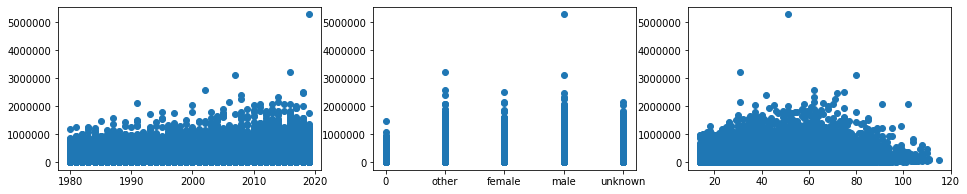

In [22]:
## Visualising

plt.figure(figsize=(16,3))

plt.subplot(131)
plt.scatter(x = Raw['Year of Record'], y = Raw['Income in EUR'])
plt.subplot(132)
plt.scatter(x = Raw['Gender'], y = Raw['Income in EUR'])
plt.subplot(133)
plt.scatter(x = Raw['Age'], y = Raw['Income in EUR'])
# plt.subplot(111)
# plt.scatter(x = Raw['Country'], y = Raw['Income in EUR'])
plt.show()

In [29]:
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(Raw['Income in EUR']))
print(z)
print(z.shape)
count = []
index = []
for i in range(len(z)):
    if z[i] > 2:
        count.append(z[i])
        index.append(i)
        
dropped = Raw.drop(index)

[0.32163766 0.12157727 0.32555287 ... 1.20651194 0.06119611 0.24480686]
(111993,)


(107157, 10)


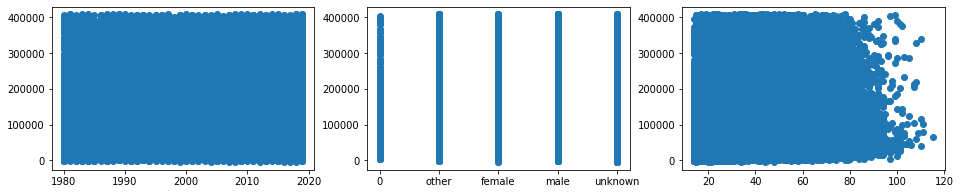

In [33]:
print(dropped.shape)
    
plt.figure(figsize=(16,3))

plt.subplot(131)
plt.scatter(x = dropped['Year of Record'], y = dropped['Income in EUR'])
plt.subplot(132)
plt.scatter(x = dropped['Gender'], y = dropped['Income in EUR'])
plt.subplot(133)
plt.scatter(x = dropped['Age'], y = dropped['Income in EUR'])
# plt.subplot(111)
# plt.scatter(x = Raw['Country'], y = Raw['Income in EUR'])
plt.show()

In [17]:
Raw = main.ReadInData("../data/tcd ml 2019-20 income prediction training (with labels).csv")
Raw = main.HandleMissingData(Raw)
Raw['University Degree'] = Raw['University Degree'].replace(['0'], 'No')

sub_df = Raw[Raw['Profession'].str.contains("senior")]
sub_df.head(5)

37
1999.4212743832472


,Year of Record,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Body Height [cm],Income in EUR
5,1991.0,male,60.0,Liberia,56080,senior security analyst,Bachelor,0,181,125809.99030
15,1987.0,female,31.0,Czechia,781821,senior product manager,Bachelor,0,152,46883.47311
24,2008.0,male,71.0,Slovakia,220873,senior forester for restitution,Bachelor,0,179,106068.38890
25,1983.0,other,28.0,Burundi,855389,senior mainframe programmer analyst,Master,0,201,136612.00430
27,2014.0,male,40.0,Paraguay,164659,senior data analyst,Bachelor,1,153,41306.81831


       Year of Record           Age  Size of City  Wears Glasses  \
count    10818.000000  10818.000000  1.081800e+04   10818.000000   
mean      1999.381679     37.254021  8.563793e+05       0.502034   
std         11.521262     15.919803  2.262229e+06       0.500019   
min       1980.000000     14.000000  1.030000e+02       0.000000   
25%       1989.000000     24.000000  7.254175e+04       0.000000   
50%       1999.000000     35.000000  5.100765e+05       1.000000   
75%       2009.000000     48.000000  1.193456e+06       1.000000   
max       2019.000000    110.000000  4.922248e+07       1.000000   

       Body Height [cm]  Income in EUR  
count      10818.000000   1.081800e+04  
mean         175.463764   1.320943e+05  
std           19.754344   1.763192e+05  
min          116.000000  -1.508508e+02  
25%          161.000000   3.620458e+04  
50%          174.000000   6.838583e+04  
75%          190.000000   1.546654e+05  
max          256.000000   2.515871e+06  


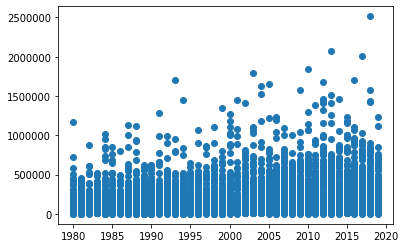

In [20]:
print(sub_df.describe())


plt.scatter(x = sub_df['Year of Record'], y = sub_df['Income in EUR'])
plt.show()